In [2]:

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import AveragePooling2D, Dense, Flatten, Conv2D, MaxPool2D
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

#from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method

import foolbox as fb
import eagerpy as ep
from foolbox import TensorFlowModel, accuracy, samples
import foolbox.attacks as fa
import numpy as np
np.set_printoptions(suppress=True)

### Start with definition and training of the DNN at the bottom of this NB

# C&W L2 Attack

$F(x) = y$  neural network<br>
$F$  model<br>
$x$  input<br>
$y$  output<br>
$m$  amount of classes<br>

$C(x)$  label assigned by model =arg max F(x)<br>
$C*(x)$  correct label<br>
$Z(x) = z$  logits -> output of all layers except softmax<br>

$F(x)$ = $softmax(Z(x))$ = $y$<br>
$F$ = $softmax ◦ F_n ◦ F_n-1 ◦ ... ◦ F_1$  A network consists of layers $F_n$<br>
$F_i(x)$ = $\sigma$ * $(\Theta_i * x)$ + $\hat{\Theta_i}$<br>
$\sigma$  activation function<br>
$\Theta$  Params<br>
$\hat{\Theta}$ Bias<br>

$t$  target class<br>
$x$  input<br>
$x'$ adversarial input <br>

$||x - x'||_p$ the $L_p$ distance
$|| · ||_p$  = $ || v ||_p = ( \sum_{n=1}^{n} | v_i | ^ p)^{1/p}$


# Approach
minimize $D (x, x + \delta)$ <br>
such that <br>
$C(x + \delta) = t$<br>
$x + \delta \in [0,1]$


$\delta$ change
$D$ distance metric

### Alternative Formulation
minimize $D (x, x + \delta) + c * f(x+\delta)$ <br>
such that <br>
$x + \delta \in [0,1]$

$f(x+\delta)$ is one of the following objective functions
$c$ is a constant

### Set norm as distance measure 

minimize $||\delta||_p + c * f(x+\delta)$ <br>
such that <br>
$x + \delta \in [0,1]$

# Objective Functions

$f_1(x) = -loss_{F,t}(x')+1$ <br>
$f_2(x) = (max(F(x')_i) - F(x')_t)^+$ <br>
$f_3(x) = softplus(max(F(x')_i) - F(x')_t) - log(2)$<br>
$f_4(x) = (0.5 - F(x')_t)^+$<br>
$f_5(x) = -log(2F(x')_t -2)$ <br>
$f_6(x) = (max(Z(x')_i) - Z(x')_t)^+$ <br>
$f_7(x) = softplus(max(Z(x')_i) - Z(x')_t) - log(2)$

$(yyy)^+ = max(yyy, o)$<br>
$softplus(yyy) = log(1+exp(yyy))$<br>
$loss_{F,t}(x)$ = cross entropy loss

## ensure box contraint
introduce an new variable $w$<br>
so<br>
$\delta_i = 1/2(tanh(w_i)+1)-x_i$

$x_i+ \delta_i \in [0,1]$ because:<br>
$-1 \leq tanh(x) \leq 1$<br>
so<br>
$0 \leq x_i+\delta_i \leq 1$

# Putting it together
###### for the l2 attack
f1 : minimize $||1/2(tanh(w_i)+1)-x_i||^2_2 +c * f(1/2(tanh(w)+1)$

with $f$ defined as:

f2 : $f(x') = $ max$($max$({Z(x')_i:i\neq t} )-Z(x')_t, -\kappa)$

In [3]:
def loss_function(x, adv_image, const, target):
    l1 = tf.square(tf.norm(adv_image - x))
    logit_of_best_other = get_logit_of_best_except_target(model, adv_image, target)
    logit_of_target = get_logit_of_target(model, adv_image,target)
    l2 = const * tf.math.maximum(
        logit_of_best_other
        - logit_of_target
        , 0 )
    return l1 + l2
    
def alternate_loss_fn(x, adv_image, const, target):
    #print('adv',adv_x)
    #print('clean', x)
    #check why the do not use norm in the cleverhans implementation

    loss1 = tf.square(tf.norm(adv_image - x))
    #loss1 = tf.square(tf.norm(adv_image - x, ord=1))
    loss2 = const * f2(adv_image, target)
    #print('losses: ',loss1.numpy(), loss2.numpy())
    #print('loss:', (loss2 + loss1).numpy())
    return loss2 + loss1
    #return loss1 + loss2

In [4]:

def f2(adv_x, target):
    logit_of_best_other = get_logit_of_best_except_target(model, adv_x, target)
    logit_of_target = get_logit_of_target(model, adv_x, target)
    
    return tf.math.maximum(logit_of_best_other - logit_of_target, 0 )

    

0
l2 dist: 13.336802
target class:  2
pred of adv ex:  3


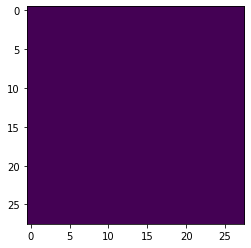

1
l2 dist: 12.947592
target class:  2
pred of adv ex:  3


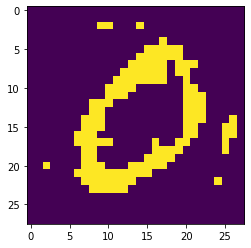

2
l2 dist: 12.56273
target class:  2
pred of adv ex:  8


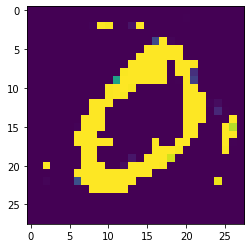

3
l2 dist: 12.17823
target class:  2
pred of adv ex:  8


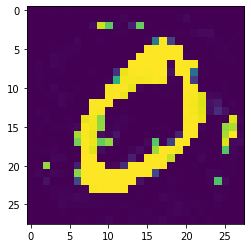

4
l2 dist: 11.795897
target class:  2
pred of adv ex:  8


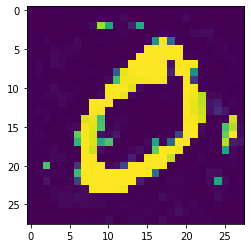

5
l2 dist: 11.423677
target class:  2
pred of adv ex:  8


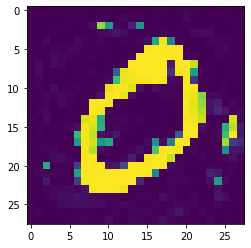

6
l2 dist: 11.060882
target class:  2
pred of adv ex:  3


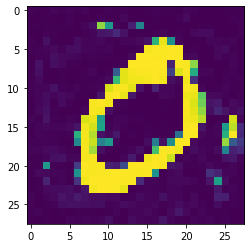

7
l2 dist: 10.705678
target class:  2
pred of adv ex:  3


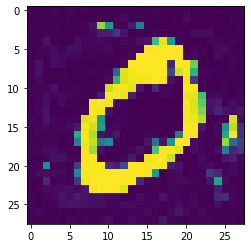

8
l2 dist: 10.359004
target class:  2
pred of adv ex:  2


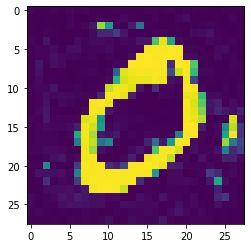

9
l2 dist: 10.013464
target class:  2
pred of adv ex:  2


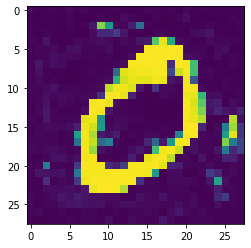

10
l2 dist: 9.672676
target class:  2
pred of adv ex:  2


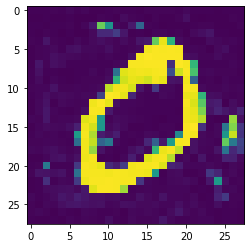

11
l2 dist: 9.338444
target class:  2
pred of adv ex:  2


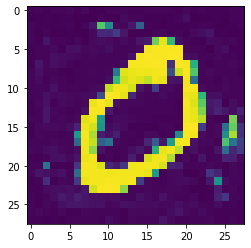

12
l2 dist: 9.011996
target class:  2
pred of adv ex:  2


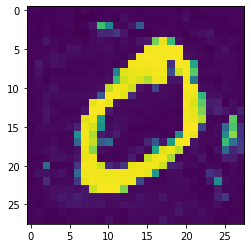

13
l2 dist: 8.694255
target class:  2
pred of adv ex:  2


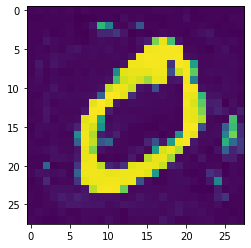

14
l2 dist: 8.385938
target class:  2
pred of adv ex:  2


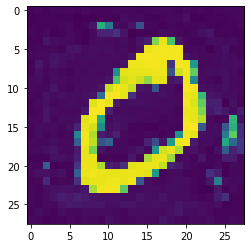

15
l2 dist: 8.087596
target class:  2
pred of adv ex:  2


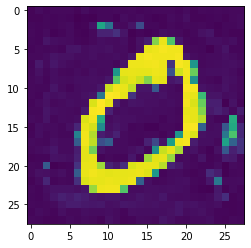

16
l2 dist: 7.7996507
target class:  2
pred of adv ex:  2


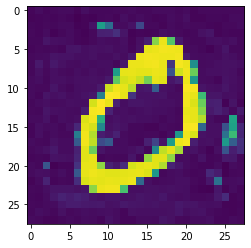

17
l2 dist: 7.5223975
target class:  2
pred of adv ex:  2


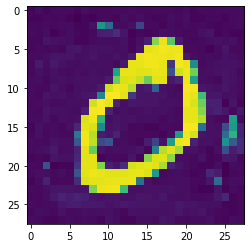

18
l2 dist: 7.2560263
target class:  2
pred of adv ex:  0


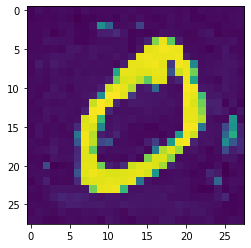

19
l2 dist: 7.0133095
target class:  2
pred of adv ex:  0


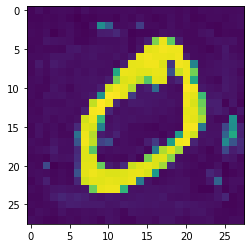

20
l2 dist: 6.7924314
target class:  2
pred of adv ex:  0


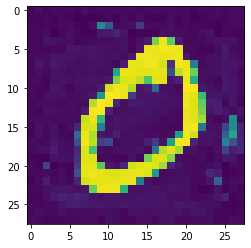

21
l2 dist: 6.5920143
target class:  2
pred of adv ex:  2


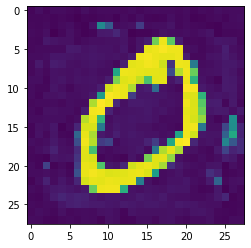

22
l2 dist: 6.3991456
target class:  2
pred of adv ex:  2


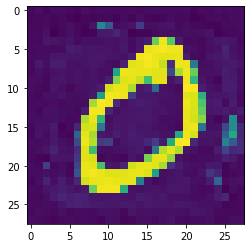

23
l2 dist: 6.2135634
target class:  2
pred of adv ex:  2


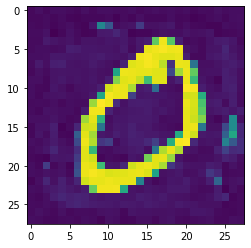

24
l2 dist: 6.0350227
target class:  2
pred of adv ex:  2


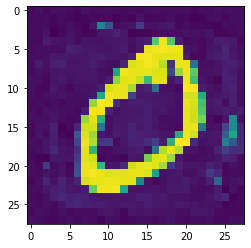

25
l2 dist: 5.863298
target class:  2
pred of adv ex:  2


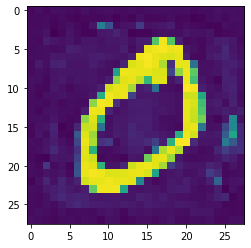

26
l2 dist: 5.698176
target class:  2
pred of adv ex:  2


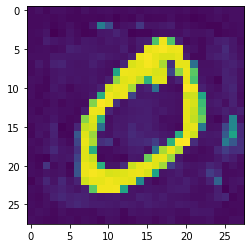

27
l2 dist: 5.539454
target class:  2
pred of adv ex:  2


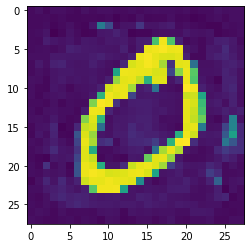

28
l2 dist: 5.386939
target class:  2
pred of adv ex:  2


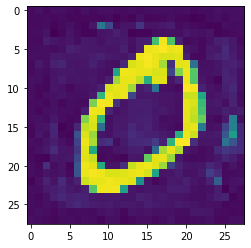

29
l2 dist: 5.240444
target class:  2
pred of adv ex:  2


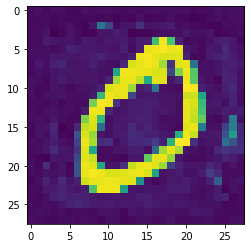

30
l2 dist: 5.0997887
target class:  2
pred of adv ex:  0


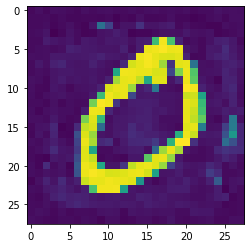

31
l2 dist: 4.9772487
target class:  2
pred of adv ex:  0


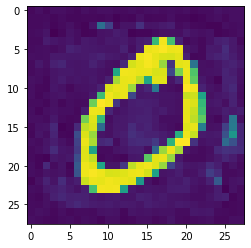

32
l2 dist: 4.8712626
target class:  2
pred of adv ex:  2


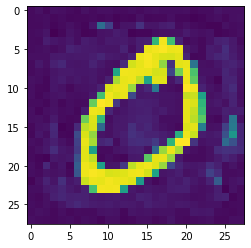

33
l2 dist: 4.768633
target class:  2
pred of adv ex:  2


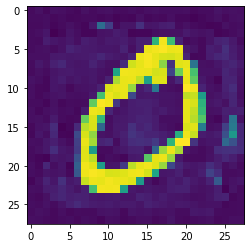

34
l2 dist: 4.6690593
target class:  2
pred of adv ex:  2


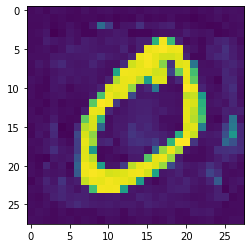

35
l2 dist: 4.572306
target class:  2
pred of adv ex:  2


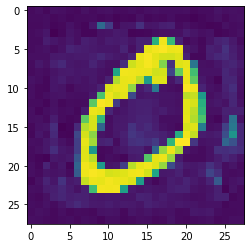

36
l2 dist: 4.478196
target class:  2
pred of adv ex:  2


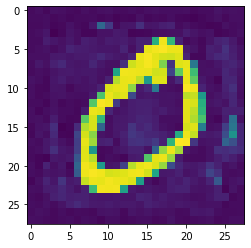

37
l2 dist: 4.3865976
target class:  2
pred of adv ex:  2


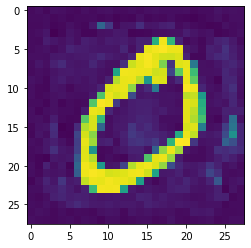

38
l2 dist: 4.297416
target class:  2
pred of adv ex:  2


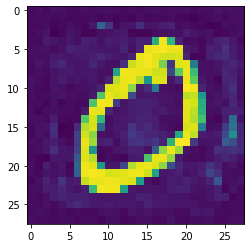

39
l2 dist: 4.2105885
target class:  2
pred of adv ex:  2


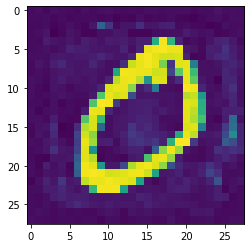

40
l2 dist: 4.126073
target class:  2
pred of adv ex:  2


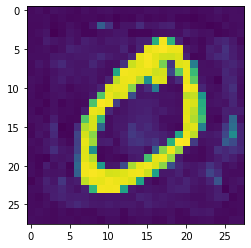

41
l2 dist: 4.043847
target class:  2
pred of adv ex:  0


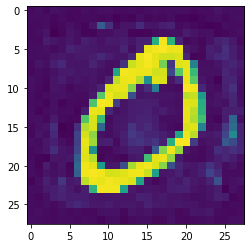

42
l2 dist: 3.977844
target class:  2
pred of adv ex:  0


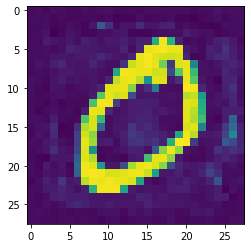

43
l2 dist: 3.9262664
target class:  2
pred of adv ex:  2


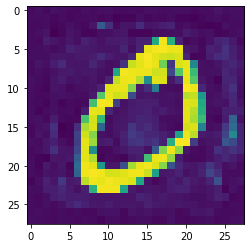

44
l2 dist: 3.8747492
target class:  2
pred of adv ex:  2


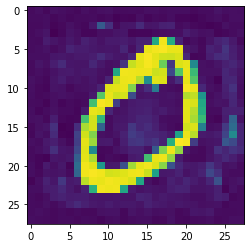

45
l2 dist: 3.8231473
target class:  2
pred of adv ex:  2


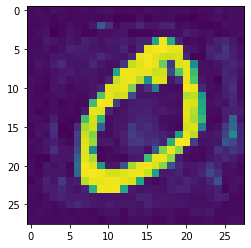

46
l2 dist: 3.7713828
target class:  2
pred of adv ex:  2


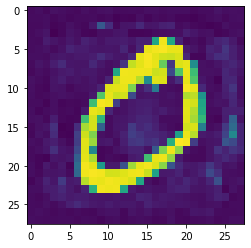

47
l2 dist: 3.7194343
target class:  2
pred of adv ex:  2


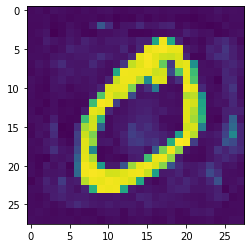

48
l2 dist: 3.6673224
target class:  2
pred of adv ex:  2


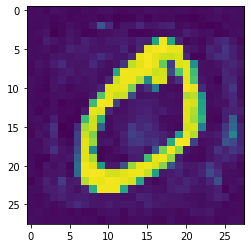

49
l2 dist: 3.6151052
target class:  2
pred of adv ex:  2


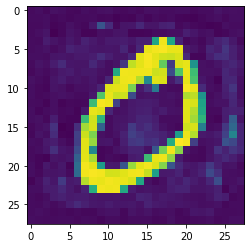

50
l2 dist: 3.5628648
target class:  2
pred of adv ex:  2


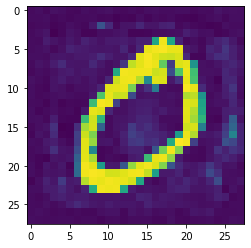

51
l2 dist: 3.5107028
target class:  2
pred of adv ex:  2


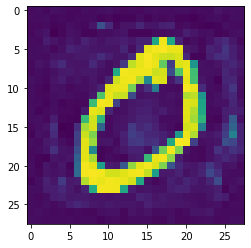

52
l2 dist: 3.4587321
target class:  2
pred of adv ex:  2


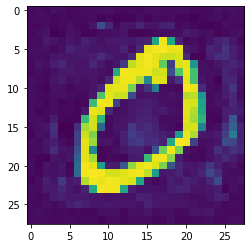

53
l2 dist: 3.407071
target class:  2
pred of adv ex:  0


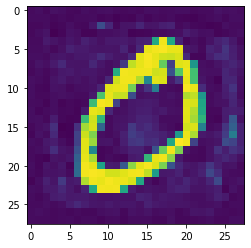

54
l2 dist: 3.3704379
target class:  2
pred of adv ex:  0


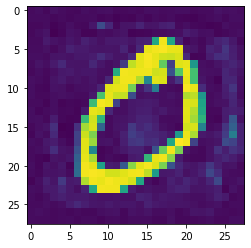

55
l2 dist: 3.3471496
target class:  2
pred of adv ex:  2


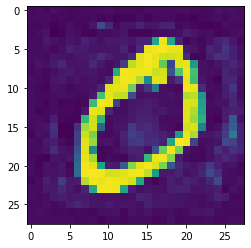

56
l2 dist: 3.321991
target class:  2
pred of adv ex:  2


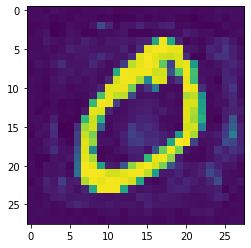

57
l2 dist: 3.2949762
target class:  2
pred of adv ex:  2


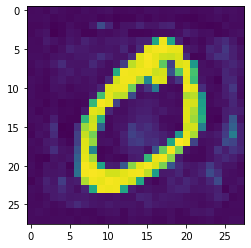

58
l2 dist: 3.266176
target class:  2
pred of adv ex:  2


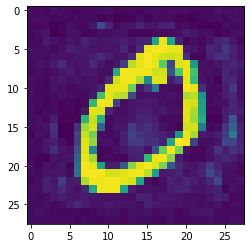

59
l2 dist: 3.2357054
target class:  2
pred of adv ex:  2


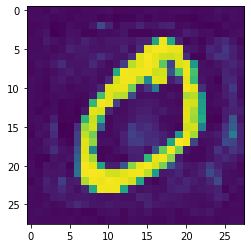

60
l2 dist: 3.203713
target class:  2
pred of adv ex:  2


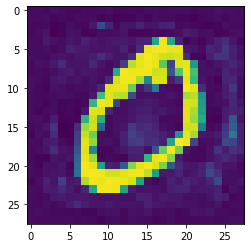

61
l2 dist: 3.1703703
target class:  2
pred of adv ex:  2


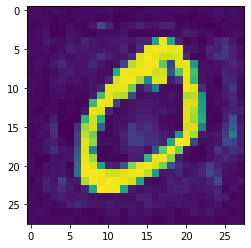

62
l2 dist: 3.1358628
target class:  2
pred of adv ex:  2


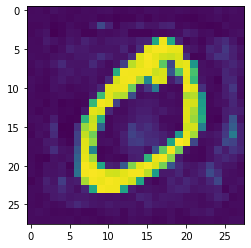

63
l2 dist: 3.1003838
target class:  2
pred of adv ex:  2


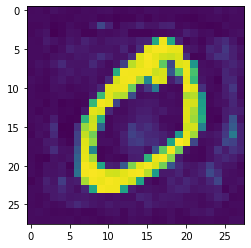

64
l2 dist: 3.064128
target class:  2
pred of adv ex:  2


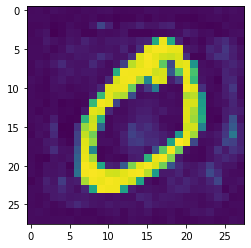

65
l2 dist: 3.027286
target class:  2
pred of adv ex:  0


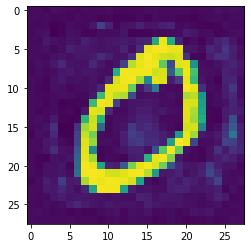

66
l2 dist: 3.005251
target class:  2
pred of adv ex:  0


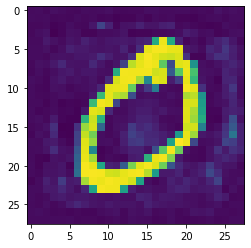

67
l2 dist: 2.9963694
target class:  2
pred of adv ex:  2


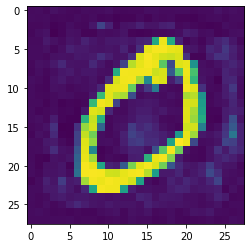

68
l2 dist: 2.9846818
target class:  2
pred of adv ex:  2


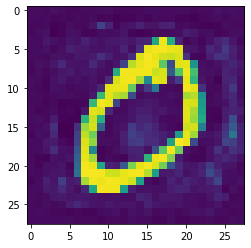

69
l2 dist: 2.9702792
target class:  2
pred of adv ex:  2


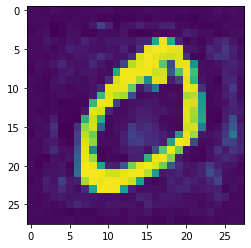

70
l2 dist: 2.953302
target class:  2
pred of adv ex:  2


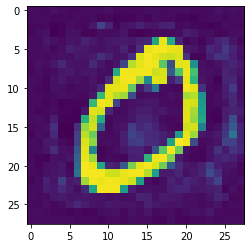

71
l2 dist: 2.9339273
target class:  2
pred of adv ex:  2


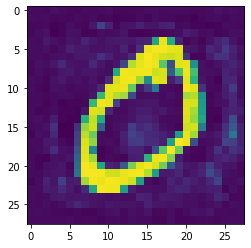

72
l2 dist: 2.9123592
target class:  2
pred of adv ex:  2


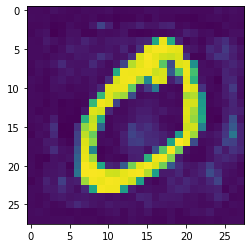

73
l2 dist: 2.888818
target class:  2
pred of adv ex:  2


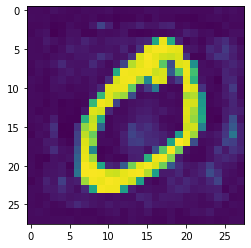

74
l2 dist: 2.8635347
target class:  2
pred of adv ex:  2


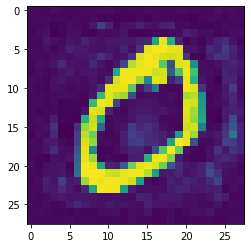

75
l2 dist: 2.8367429
target class:  2
pred of adv ex:  2


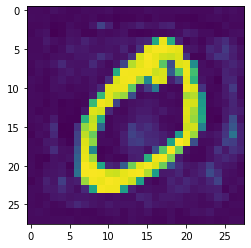

76
l2 dist: 2.8086746
target class:  2
pred of adv ex:  2


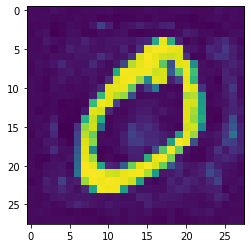

77
l2 dist: 2.7795558
target class:  2
pred of adv ex:  2


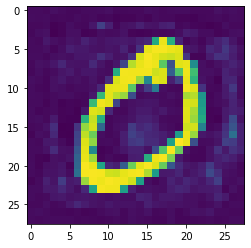

78
l2 dist: 2.7496028
target class:  2
pred of adv ex:  0


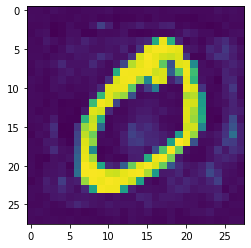

79
l2 dist: 2.7355816
target class:  2
pred of adv ex:  0


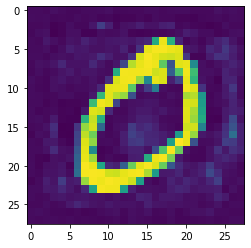

80
l2 dist: 2.735651
target class:  2
pred of adv ex:  2


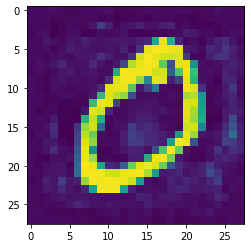

81
l2 dist: 2.732514
target class:  2
pred of adv ex:  2


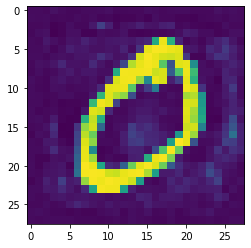

82
l2 dist: 2.7262611
target class:  2
pred of adv ex:  2


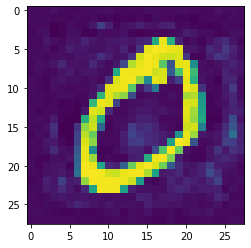

83
l2 dist: 2.7170346
target class:  2
pred of adv ex:  2


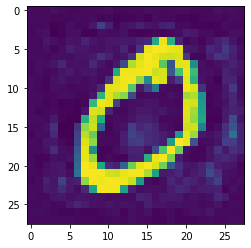

84
l2 dist: 2.7050166
target class:  2
pred of adv ex:  2


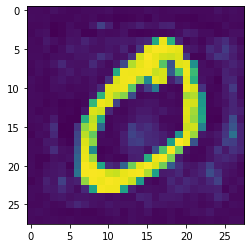

85
l2 dist: 2.690419
target class:  2
pred of adv ex:  2


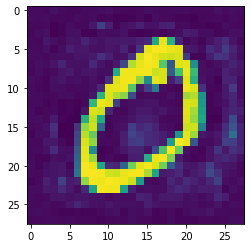

86
l2 dist: 2.673473
target class:  2
pred of adv ex:  2


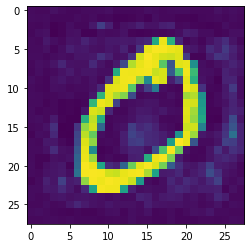

87
l2 dist: 2.6544223
target class:  2
pred of adv ex:  2


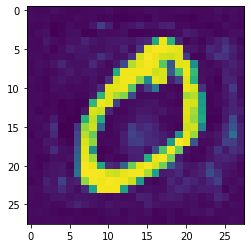

88
l2 dist: 2.6335156
target class:  2
pred of adv ex:  2


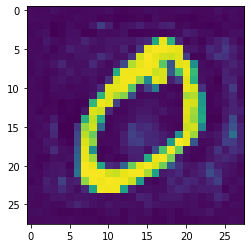

89
l2 dist: 2.6110024
target class:  2
pred of adv ex:  2


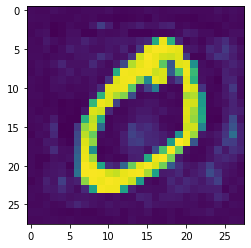

90
l2 dist: 2.5871263
target class:  2
pred of adv ex:  2


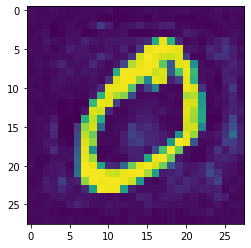

91
l2 dist: 2.562122
target class:  2
pred of adv ex:  2


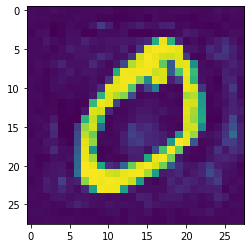

92
l2 dist: 2.5362136
target class:  2
pred of adv ex:  0


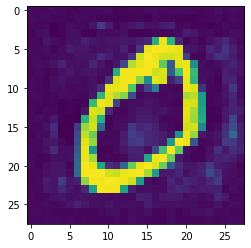

93
l2 dist: 2.526643
target class:  2
pred of adv ex:  2


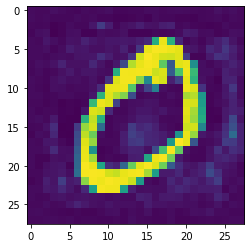

94
l2 dist: 2.514721
target class:  2
pred of adv ex:  2


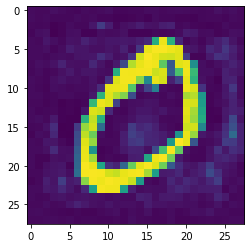

95
l2 dist: 2.5006576
target class:  2
pred of adv ex:  2


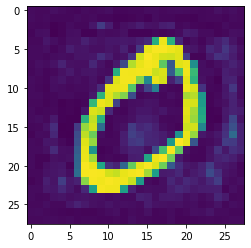

96
l2 dist: 2.4846737
target class:  2
pred of adv ex:  0


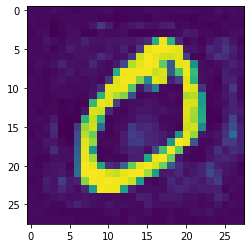

97
l2 dist: 2.483988
target class:  2
pred of adv ex:  2


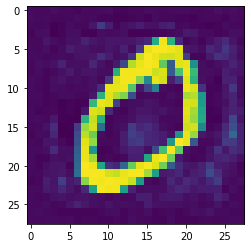

98
l2 dist: 2.4802587
target class:  2
pred of adv ex:  2


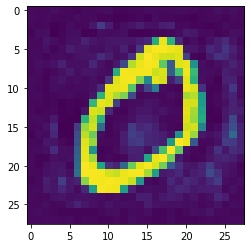

99
l2 dist: 2.4736586
target class:  2
pred of adv ex:  2


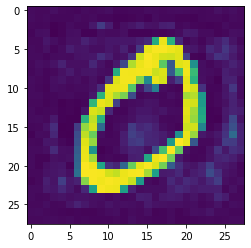

100
l2 dist: 2.4643903
target class:  2
pred of adv ex:  2


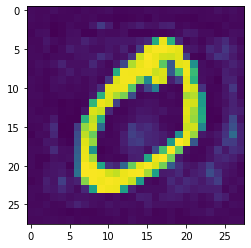

101
l2 dist: 2.452678
target class:  2
pred of adv ex:  2


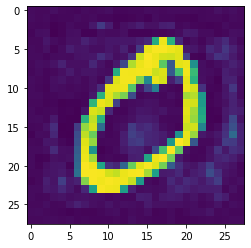

102
l2 dist: 2.4387577
target class:  2
pred of adv ex:  2


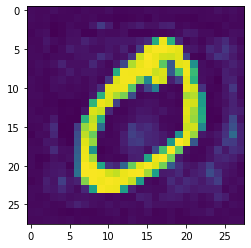

103
l2 dist: 2.4228725
target class:  2
pred of adv ex:  2


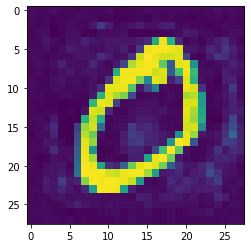

104
l2 dist: 2.405265
target class:  2
pred of adv ex:  2


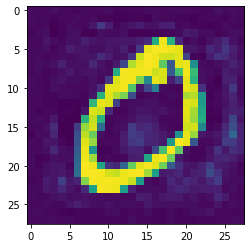

105
l2 dist: 2.386174
target class:  2
pred of adv ex:  0


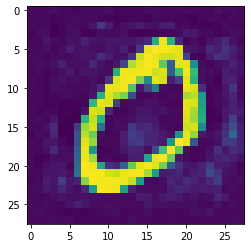

106
l2 dist: 2.3832803
target class:  2
pred of adv ex:  2


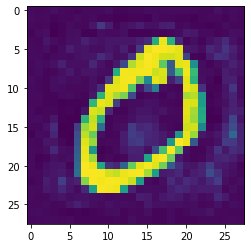

107
l2 dist: 2.3775668
target class:  2
pred of adv ex:  2


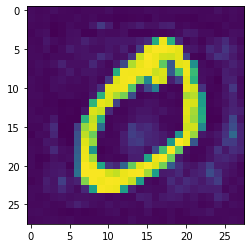

108
l2 dist: 2.3692434
target class:  2
pred of adv ex:  2


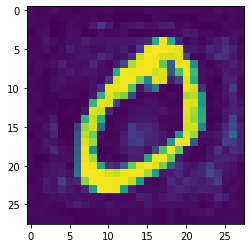

109
l2 dist: 2.358537
target class:  2
pred of adv ex:  2


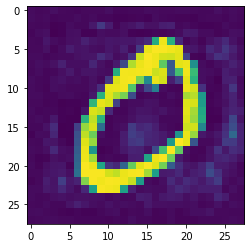

110
l2 dist: 2.345684
target class:  2
pred of adv ex:  2


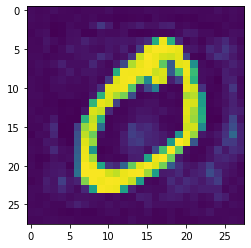

111
l2 dist: 2.3309255
target class:  2
pred of adv ex:  2


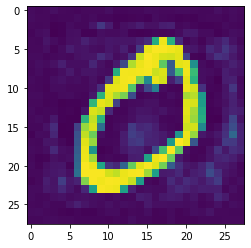

112
l2 dist: 2.3144994
target class:  2
pred of adv ex:  0


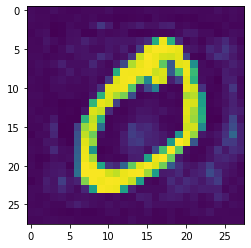

113
l2 dist: 2.3144896
target class:  2
pred of adv ex:  2


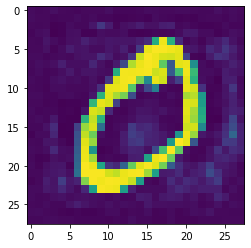

114
l2 dist: 2.311492
target class:  2
pred of adv ex:  2


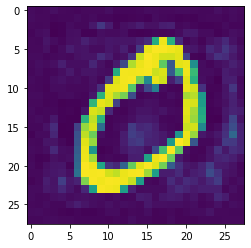

115
l2 dist: 2.3057125
target class:  2
pred of adv ex:  2


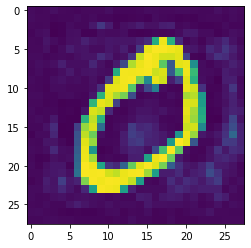

116
l2 dist: 2.2973757
target class:  2
pred of adv ex:  2


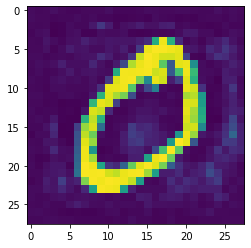

117
l2 dist: 2.2867208
target class:  2
pred of adv ex:  2


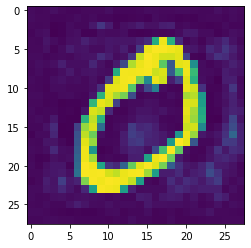

118
l2 dist: 2.273991
target class:  2
pred of adv ex:  2


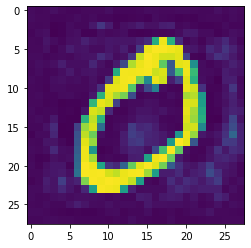

119
l2 dist: 2.259431
target class:  2
pred of adv ex:  2


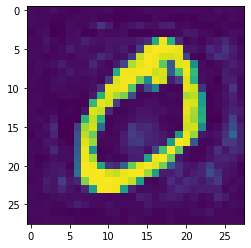

120
l2 dist: 2.2432795
target class:  2
pred of adv ex:  0


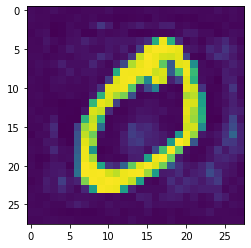

121
l2 dist: 2.2438104
target class:  2
pred of adv ex:  2


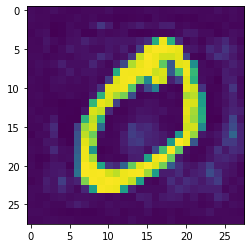

122
l2 dist: 2.2413728
target class:  2
pred of adv ex:  2


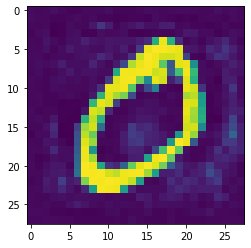

123
l2 dist: 2.236177
target class:  2
pred of adv ex:  2


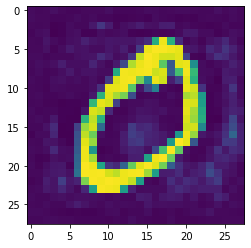

124
l2 dist: 2.2284515
target class:  2
pred of adv ex:  2


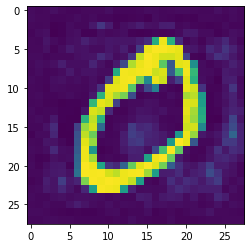

125
l2 dist: 2.2184365
target class:  2
pred of adv ex:  2


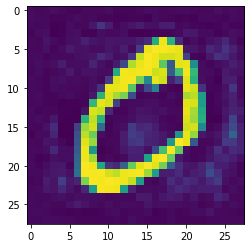

126
l2 dist: 2.2063756
target class:  2
pred of adv ex:  2


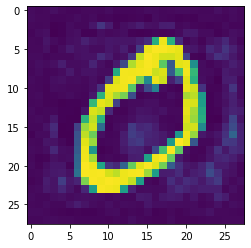

127
l2 dist: 2.1925113
target class:  2
pred of adv ex:  0


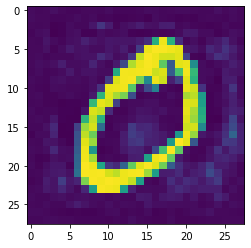

128
l2 dist: 2.194925
target class:  2
pred of adv ex:  2


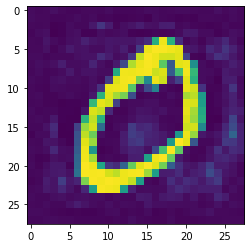

129
l2 dist: 2.1942346
target class:  2
pred of adv ex:  2


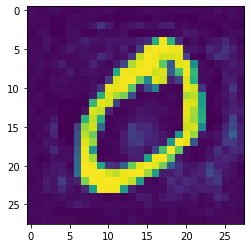

130
l2 dist: 2.1906502
target class:  2
pred of adv ex:  2


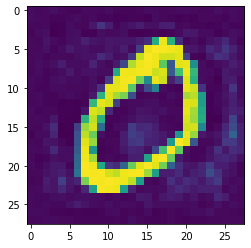

131
l2 dist: 2.1844032
target class:  2
pred of adv ex:  2


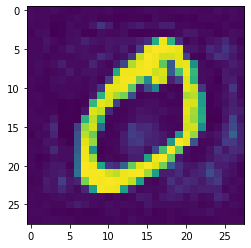

132
l2 dist: 2.1757376
target class:  2
pred of adv ex:  2


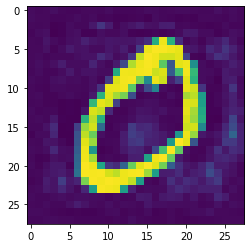

133
l2 dist: 2.164903
target class:  2
pred of adv ex:  2


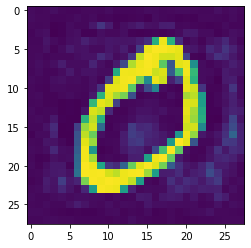

134
l2 dist: 2.152149
target class:  2
pred of adv ex:  2


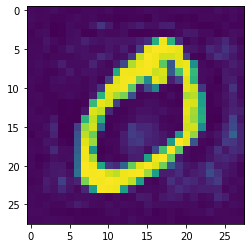

135
l2 dist: 2.137721
target class:  2
pred of adv ex:  0


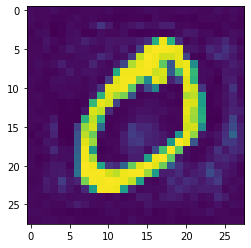

136
l2 dist: 2.140341
target class:  2
pred of adv ex:  2


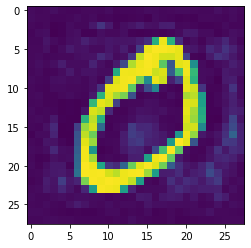

137
l2 dist: 2.139863
target class:  2
pred of adv ex:  2


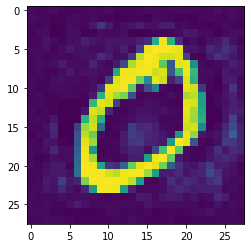

138
l2 dist: 2.1365068
target class:  2
pred of adv ex:  2


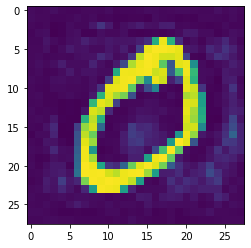

139
l2 dist: 2.1305108
target class:  2
pred of adv ex:  2


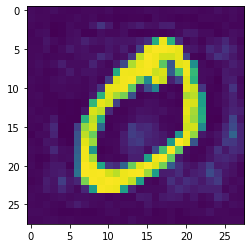

140
l2 dist: 2.1221232
target class:  2
pred of adv ex:  2


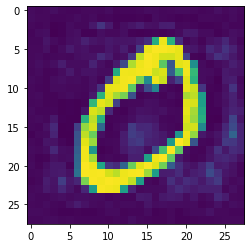

141
l2 dist: 2.111597
target class:  2
pred of adv ex:  2


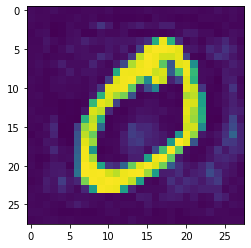

142
l2 dist: 2.0991824
target class:  2
pred of adv ex:  0


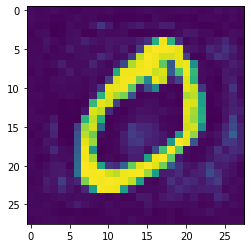

143
l2 dist: 2.1038148
target class:  2
pred of adv ex:  2


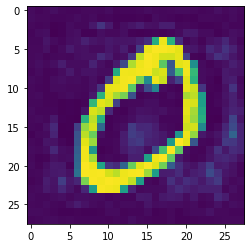

144
l2 dist: 2.1051767
target class:  2
pred of adv ex:  2


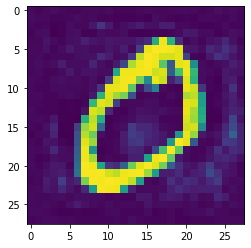

145
l2 dist: 2.1034856
target class:  2
pred of adv ex:  2


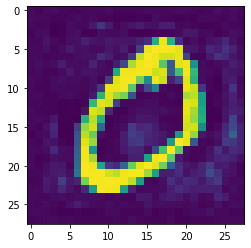

146
l2 dist: 2.0989828
target class:  2
pred of adv ex:  2


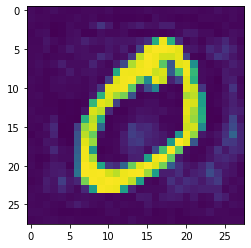

147
l2 dist: 2.0919223
target class:  2
pred of adv ex:  2


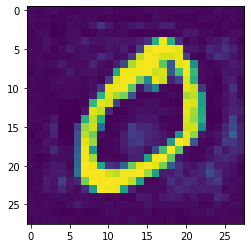

148
l2 dist: 2.0825644
target class:  2
pred of adv ex:  2


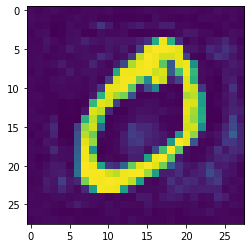

149
l2 dist: 2.0711691
target class:  2
pred of adv ex:  2


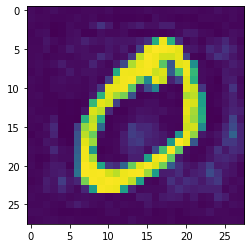

150
l2 dist: 2.0579925
target class:  2
pred of adv ex:  0


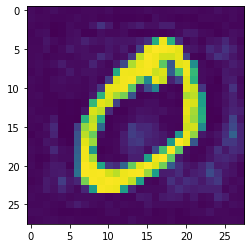

151
l2 dist: 2.0622478
target class:  2
pred of adv ex:  2


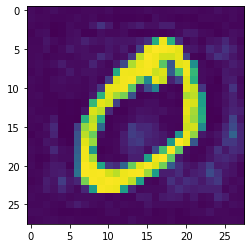

152
l2 dist: 2.0632646
target class:  2
pred of adv ex:  2


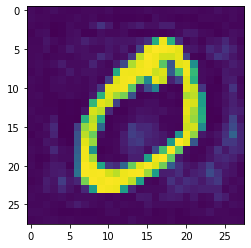

153
l2 dist: 2.061273
target class:  2
pred of adv ex:  2


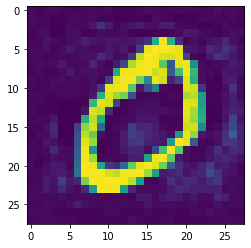

154
l2 dist: 2.056521
target class:  2
pred of adv ex:  2


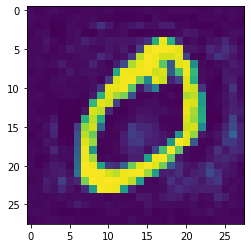

155
l2 dist: 2.0492687
target class:  2
pred of adv ex:  2


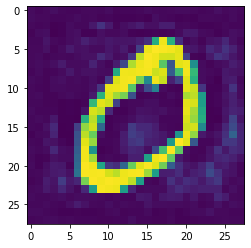

156
l2 dist: 2.039778
target class:  2
pred of adv ex:  2


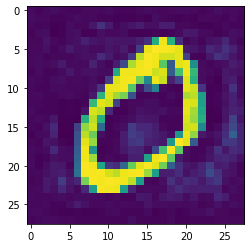

157
l2 dist: 2.0283115
target class:  2
pred of adv ex:  2


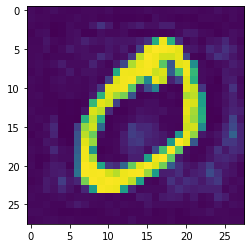

158
l2 dist: 2.0151236
target class:  2
pred of adv ex:  0


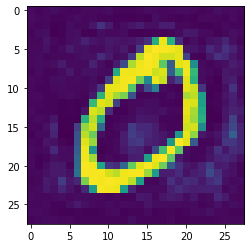

159
l2 dist: 2.01947
target class:  2
pred of adv ex:  2


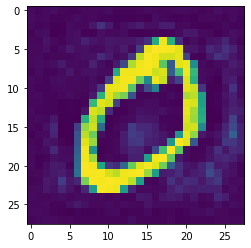

160
l2 dist: 2.020608
target class:  2
pred of adv ex:  2


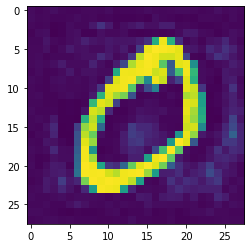

161
l2 dist: 2.01877
target class:  2
pred of adv ex:  2


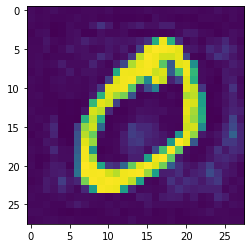

162
l2 dist: 2.0142055
target class:  2
pred of adv ex:  2


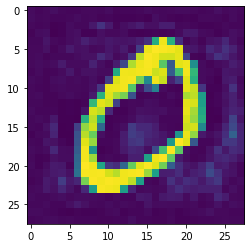

163
l2 dist: 2.0071738
target class:  2
pred of adv ex:  2


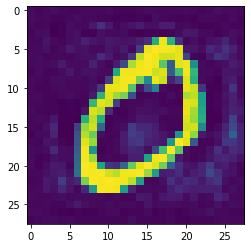

164
l2 dist: 1.9979368
target class:  2
pred of adv ex:  2


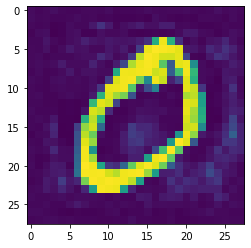

165
l2 dist: 1.9867543
target class:  2
pred of adv ex:  0


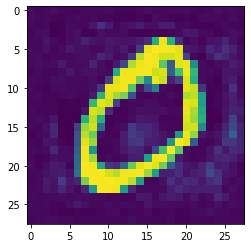

166
l2 dist: 1.9930905
target class:  2
pred of adv ex:  2


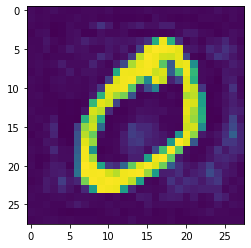

167
l2 dist: 1.9960468
target class:  2
pred of adv ex:  2


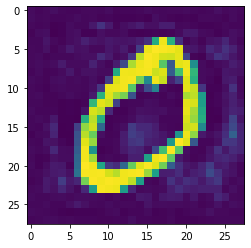

168
l2 dist: 1.9958504
target class:  2
pred of adv ex:  2


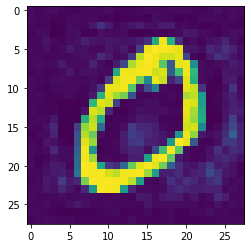

169
l2 dist: 1.9927505
target class:  2
pred of adv ex:  2


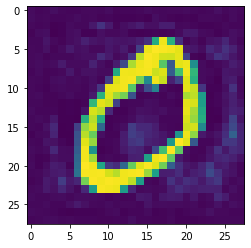

170
l2 dist: 1.9870094
target class:  2
pred of adv ex:  2


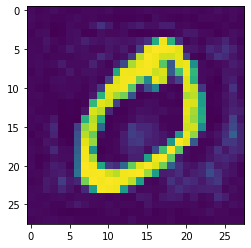

171
l2 dist: 1.9788966
target class:  2
pred of adv ex:  2


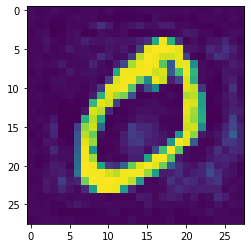

172
l2 dist: 1.9686817
target class:  2
pred of adv ex:  2


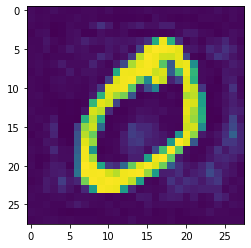

173
l2 dist: 1.95663
target class:  2
pred of adv ex:  0


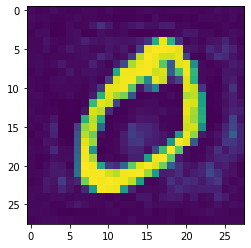

174
l2 dist: 1.9624403
target class:  2
pred of adv ex:  2


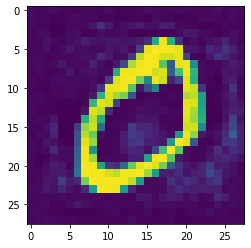

175
l2 dist: 1.9649013
target class:  2
pred of adv ex:  2


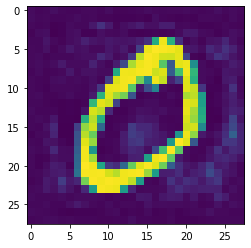

176
l2 dist: 1.964255
target class:  2
pred of adv ex:  2


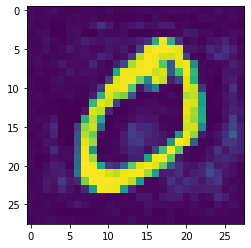

177
l2 dist: 1.960762
target class:  2
pred of adv ex:  2


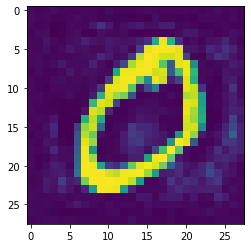

178
l2 dist: 1.9546926
target class:  2
pred of adv ex:  2


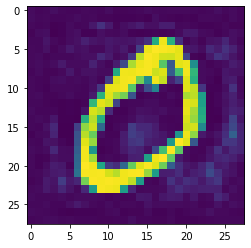

179
l2 dist: 1.9463203
target class:  2
pred of adv ex:  2


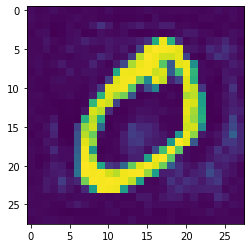

180
l2 dist: 1.9359151
target class:  2
pred of adv ex:  2


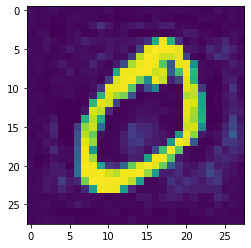

181
l2 dist: 1.9237396
target class:  2
pred of adv ex:  0


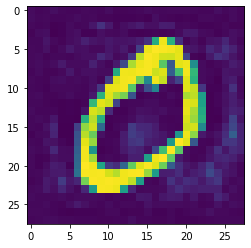

182
l2 dist: 1.9295609
target class:  2
pred of adv ex:  2


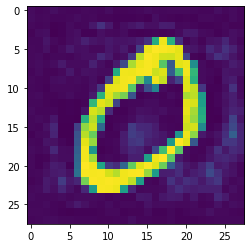

183
l2 dist: 1.93207
target class:  2
pred of adv ex:  2


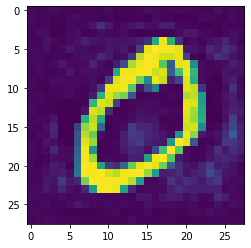

184
l2 dist: 1.9315075
target class:  2
pred of adv ex:  2


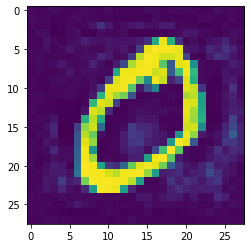

185
l2 dist: 1.9281315
target class:  2
pred of adv ex:  2


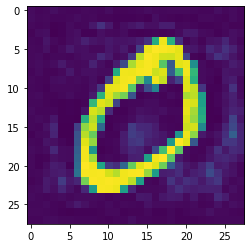

186
l2 dist: 1.9222089
target class:  2
pred of adv ex:  2


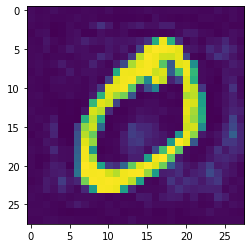

187
l2 dist: 1.91401
target class:  2
pred of adv ex:  2


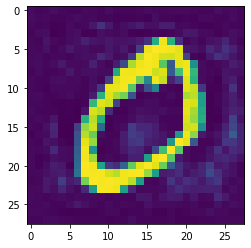

188
l2 dist: 1.9038017
target class:  2
pred of adv ex:  0


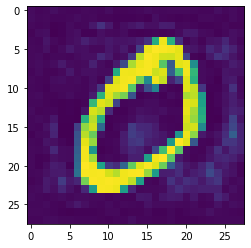

189
l2 dist: 1.91153
target class:  2
pred of adv ex:  2


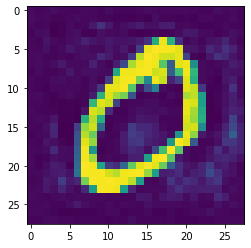

190
l2 dist: 1.9157685
target class:  2
pred of adv ex:  2


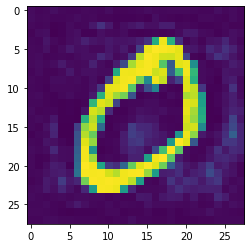

191
l2 dist: 1.9167515
target class:  2
pred of adv ex:  2


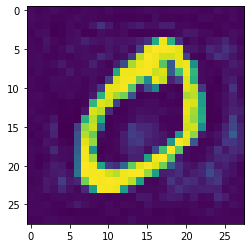

192
l2 dist: 1.9147362
target class:  2
pred of adv ex:  2


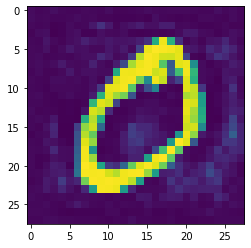

193
l2 dist: 1.9099927
target class:  2
pred of adv ex:  2


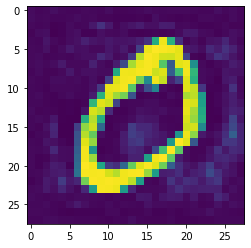

194
l2 dist: 1.9027987
target class:  2
pred of adv ex:  2


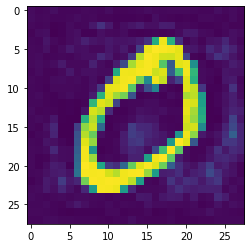

195
l2 dist: 1.8934319
target class:  2
pred of adv ex:  2


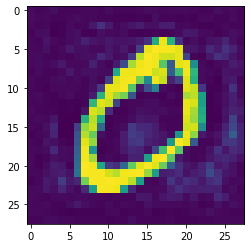

196
l2 dist: 1.8821654
target class:  2
pred of adv ex:  2


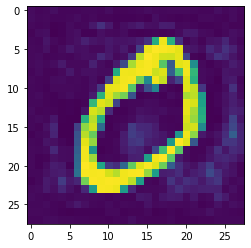

197
l2 dist: 1.8692627
target class:  2
pred of adv ex:  0


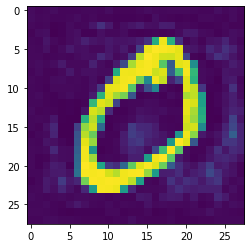

198
l2 dist: 1.8747281
target class:  2
pred of adv ex:  0


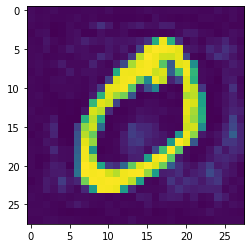

199
l2 dist: 1.8968259
target class:  2
pred of adv ex:  2


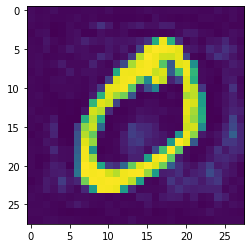

200
l2 dist: 1.9143414
target class:  2
pred of adv ex:  2


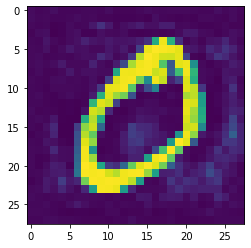

201
l2 dist: 1.9273998
target class:  2
pred of adv ex:  2


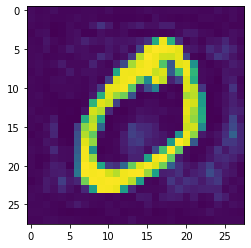

202
l2 dist: 1.9362006
target class:  2
pred of adv ex:  2


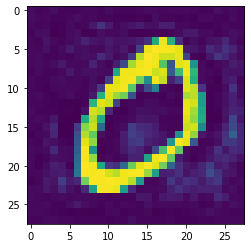

203
l2 dist: 1.9409975
target class:  2
pred of adv ex:  2


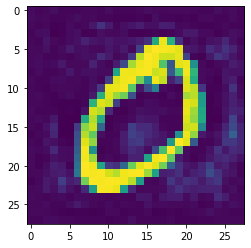

204
l2 dist: 1.9420825
target class:  2
pred of adv ex:  2


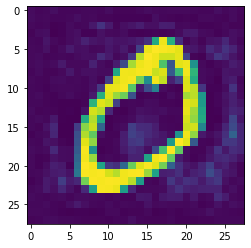

205
l2 dist: 1.939773
target class:  2
pred of adv ex:  2


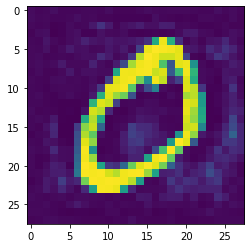

206
l2 dist: 1.9343985
target class:  2
pred of adv ex:  2


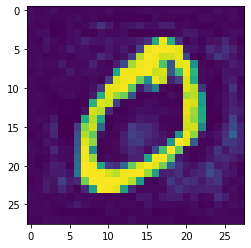

207
l2 dist: 1.9262937
target class:  2
pred of adv ex:  2


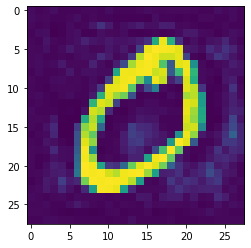

208
l2 dist: 1.9157889
target class:  2
pred of adv ex:  2


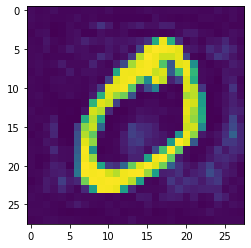

209
l2 dist: 1.9032044
target class:  2
pred of adv ex:  2


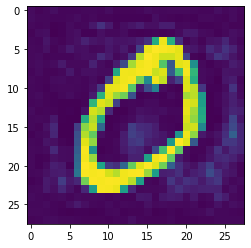

210
l2 dist: 1.8888462
target class:  2
pred of adv ex:  2


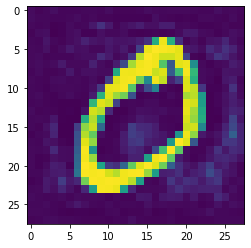

211
l2 dist: 1.8730011
target class:  2
pred of adv ex:  2


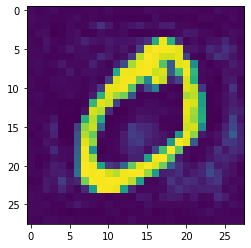

212
l2 dist: 1.8559352
target class:  2
pred of adv ex:  2


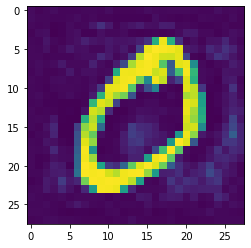

213
l2 dist: 1.8378923
target class:  2
pred of adv ex:  2


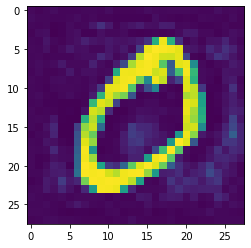

214
l2 dist: 1.8190924
target class:  2
pred of adv ex:  0


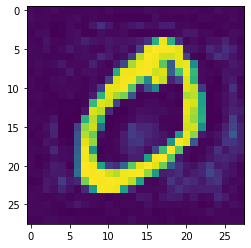

215
l2 dist: 1.8194333
target class:  2
pred of adv ex:  0


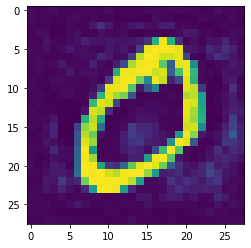

216
l2 dist: 1.8368719
target class:  2
pred of adv ex:  2


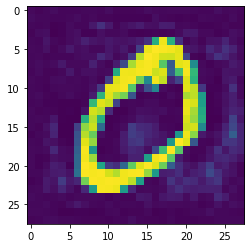

217
l2 dist: 1.8502188
target class:  2
pred of adv ex:  2


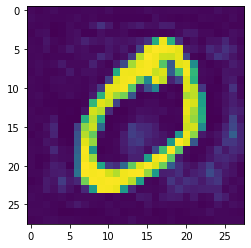

218
l2 dist: 1.8596226
target class:  2
pred of adv ex:  2


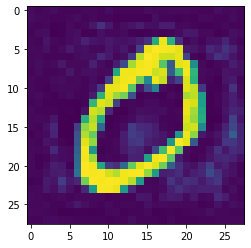

219
l2 dist: 1.8652817
target class:  2
pred of adv ex:  2


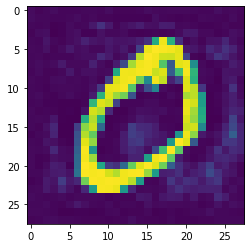

220
l2 dist: 1.8674353
target class:  2
pred of adv ex:  2


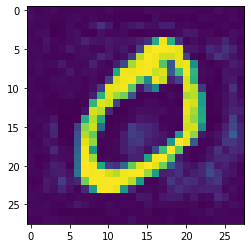

221
l2 dist: 1.8663541
target class:  2
pred of adv ex:  2


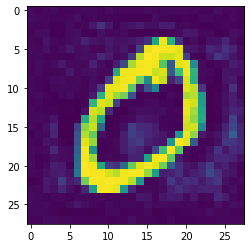

222
l2 dist: 1.8623301
target class:  2
pred of adv ex:  2


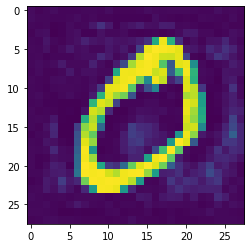

223
l2 dist: 1.8556668
target class:  2
pred of adv ex:  2


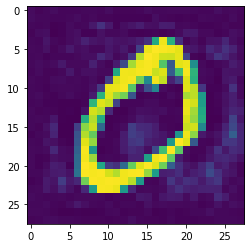

224
l2 dist: 1.846671
target class:  2
pred of adv ex:  2


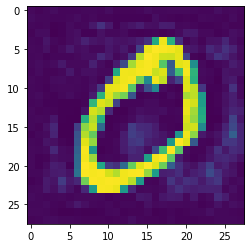

225
l2 dist: 1.835643
target class:  2
pred of adv ex:  2


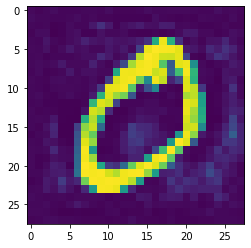

226
l2 dist: 1.8228713
target class:  2
pred of adv ex:  2


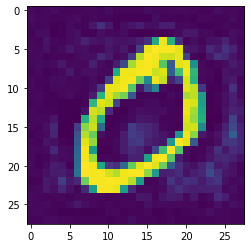

227
l2 dist: 1.8086264
target class:  2
pred of adv ex:  2


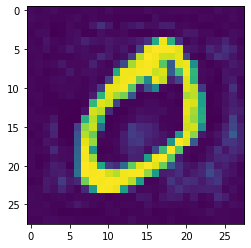

228
l2 dist: 1.7931579
target class:  2
pred of adv ex:  0


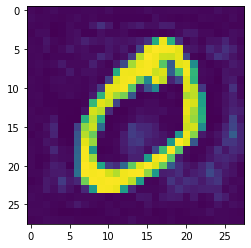

229
l2 dist: 1.7967688
target class:  2
pred of adv ex:  0


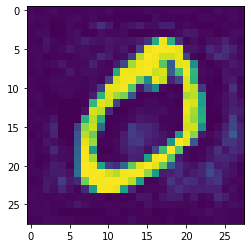

230
l2 dist: 1.8176858
target class:  2
pred of adv ex:  2


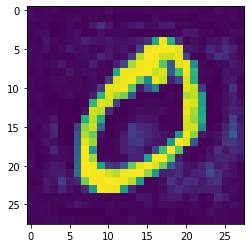

231
l2 dist: 1.8341794
target class:  2
pred of adv ex:  2


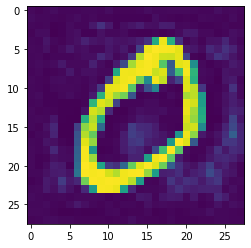

232
l2 dist: 1.846382
target class:  2
pred of adv ex:  2


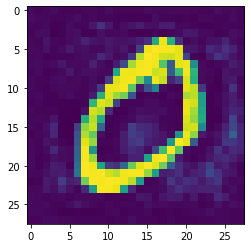

233
l2 dist: 1.8544933
target class:  2
pred of adv ex:  2


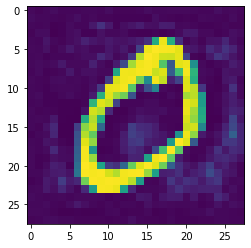

234
l2 dist: 1.8587613
target class:  2
pred of adv ex:  2


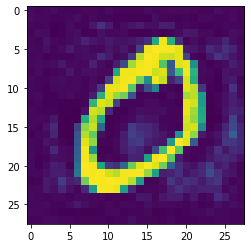

235
l2 dist: 1.859471
target class:  2
pred of adv ex:  2


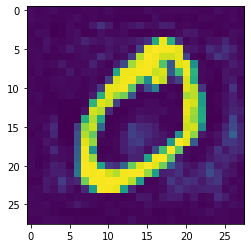

236
l2 dist: 1.8569295
target class:  2
pred of adv ex:  2


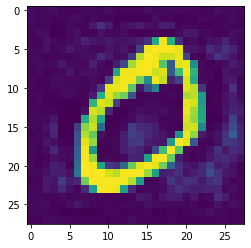

237
l2 dist: 1.8514577
target class:  2
pred of adv ex:  2


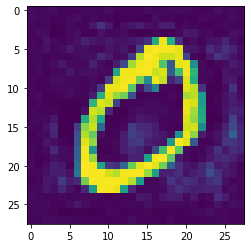

238
l2 dist: 1.8433787
target class:  2
pred of adv ex:  2


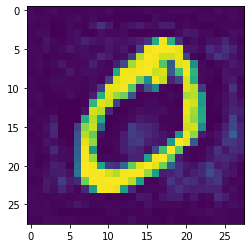

239
l2 dist: 1.8330128
target class:  2
pred of adv ex:  2


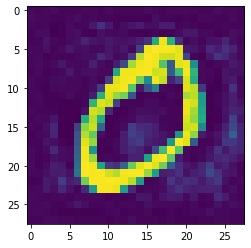

240
l2 dist: 1.8206699
target class:  2
pred of adv ex:  2


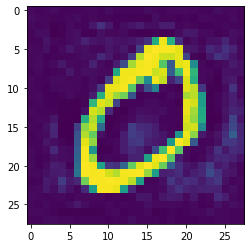

241
l2 dist: 1.8066449
target class:  2
pred of adv ex:  2


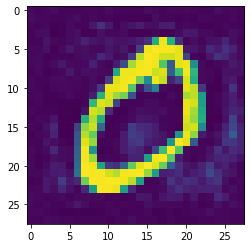

242
l2 dist: 1.7912145
target class:  2
pred of adv ex:  2


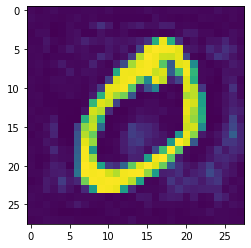

243
l2 dist: 1.7746342
target class:  2
pred of adv ex:  2


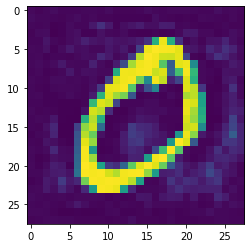

244
l2 dist: 1.7571375
target class:  2
pred of adv ex:  0


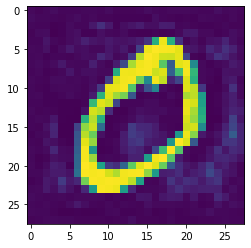

245
l2 dist: 1.7592747
target class:  2
pred of adv ex:  0


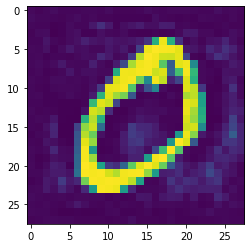

246
l2 dist: 1.7790126
target class:  2
pred of adv ex:  2


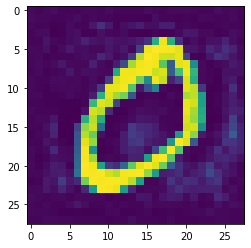

247
l2 dist: 1.7944273
target class:  2
pred of adv ex:  2


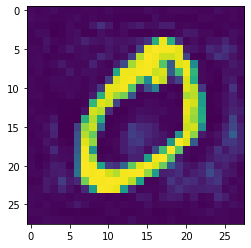

248
l2 dist: 1.8056706
target class:  2
pred of adv ex:  2


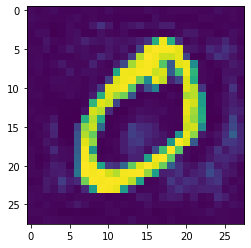

249
l2 dist: 1.8129541
target class:  2
pred of adv ex:  2


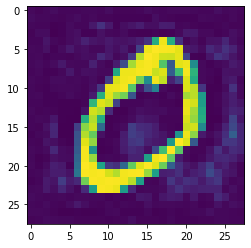

250
l2 dist: 1.8165308
target class:  2
pred of adv ex:  2


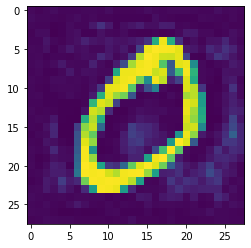

251
l2 dist: 1.8166852
target class:  2
pred of adv ex:  2


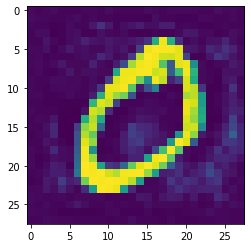

252
l2 dist: 1.8137201
target class:  2
pred of adv ex:  2


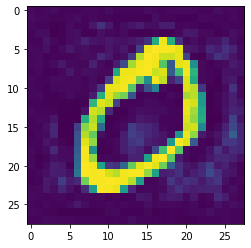

253
l2 dist: 1.8079486
target class:  2
pred of adv ex:  2


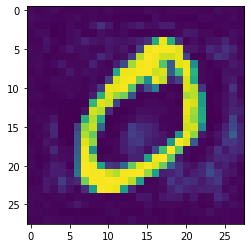

254
l2 dist: 1.7996856
target class:  2
pred of adv ex:  2


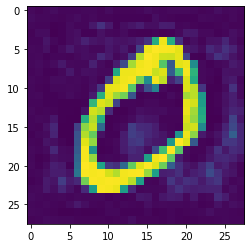

255
l2 dist: 1.7892408
target class:  2
pred of adv ex:  2


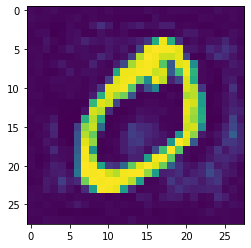

256
l2 dist: 1.7769141
target class:  2
pred of adv ex:  2


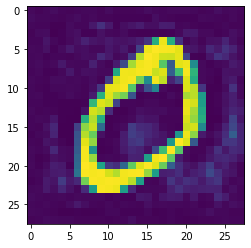

257
l2 dist: 1.7629902
target class:  2
pred of adv ex:  2


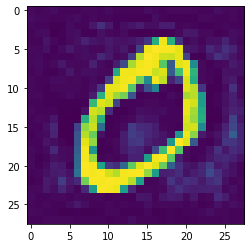

258
l2 dist: 1.7477366
target class:  2
pred of adv ex:  2


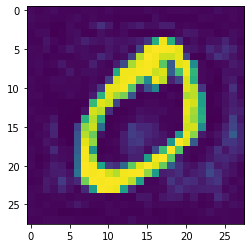

259
l2 dist: 1.7313999
target class:  2
pred of adv ex:  0


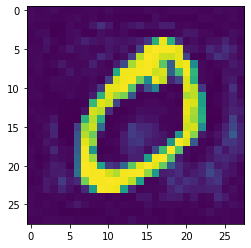

260
l2 dist: 1.7348058
target class:  2
pred of adv ex:  0


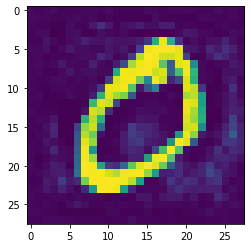

261
l2 dist: 1.7559626
target class:  2
pred of adv ex:  2


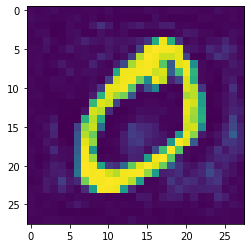

262
l2 dist: 1.7726889
target class:  2
pred of adv ex:  2


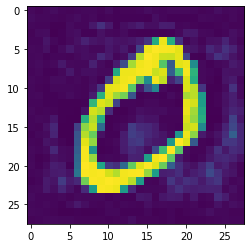

263
l2 dist: 1.785114
target class:  2
pred of adv ex:  2


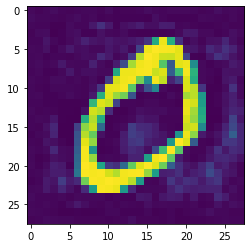

264
l2 dist: 1.7934328
target class:  2
pred of adv ex:  2


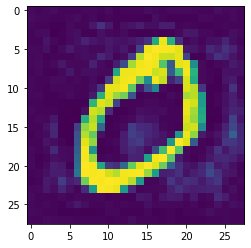

265
l2 dist: 1.7978925
target class:  2
pred of adv ex:  2


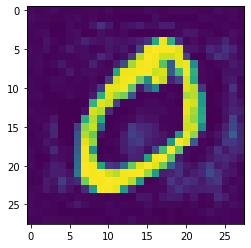

266
l2 dist: 1.7987803
target class:  2
pred of adv ex:  2


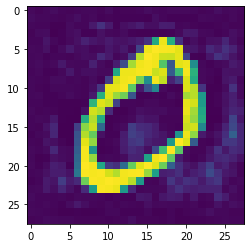

267
l2 dist: 1.796412
target class:  2
pred of adv ex:  2


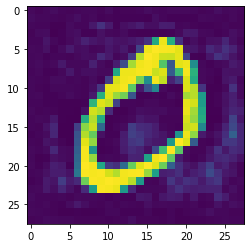

268
l2 dist: 1.7911186
target class:  2
pred of adv ex:  2


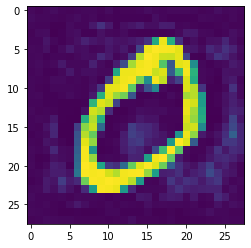

269
l2 dist: 1.7832364
target class:  2
pred of adv ex:  2


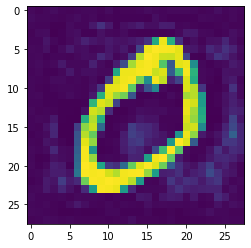

270
l2 dist: 1.7730969
target class:  2
pred of adv ex:  2


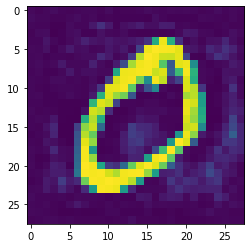

271
l2 dist: 1.7610184
target class:  2
pred of adv ex:  2


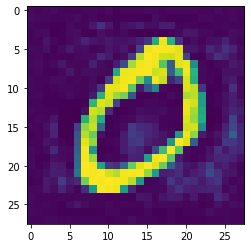

272
l2 dist: 1.7473005
target class:  2
pred of adv ex:  2


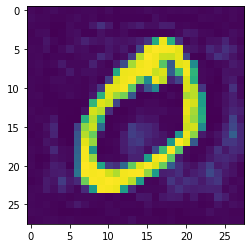

273
l2 dist: 1.7322204
target class:  2
pred of adv ex:  2


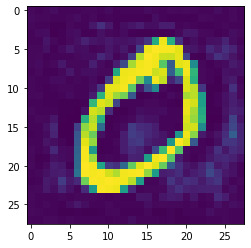

274
l2 dist: 1.7160308
target class:  2
pred of adv ex:  2


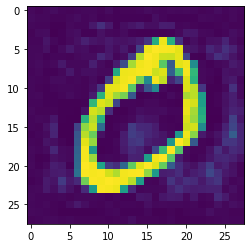

275
l2 dist: 1.6989596
target class:  2
pred of adv ex:  0


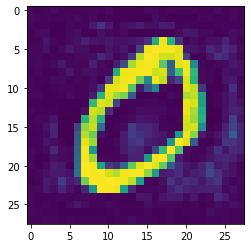

276
l2 dist: 1.7016976
target class:  2
pred of adv ex:  0


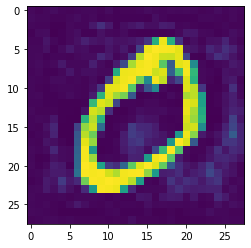

277
l2 dist: 1.7222351
target class:  2
pred of adv ex:  2


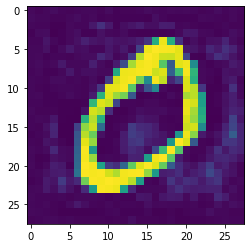

278
l2 dist: 1.7384394
target class:  2
pred of adv ex:  2


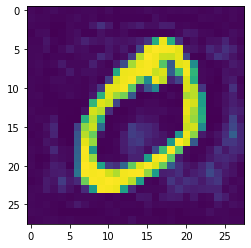

279
l2 dist: 1.7504567
target class:  2
pred of adv ex:  2


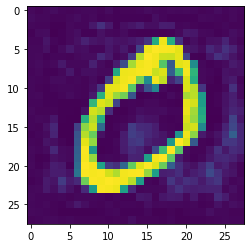

280
l2 dist: 1.758493
target class:  2
pred of adv ex:  2


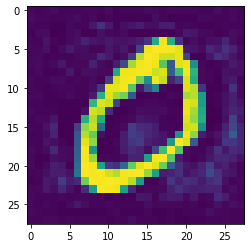

281
l2 dist: 1.7627985
target class:  2
pred of adv ex:  2


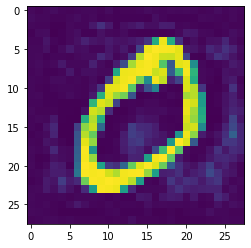

282
l2 dist: 1.7636552
target class:  2
pred of adv ex:  2


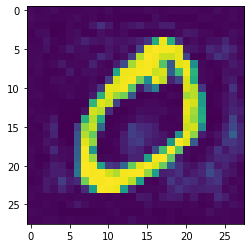

283
l2 dist: 1.7613646
target class:  2
pred of adv ex:  2


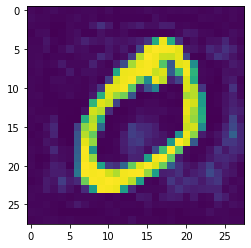

284
l2 dist: 1.7562392
target class:  2
pred of adv ex:  2


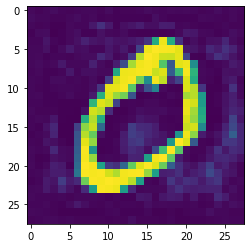

285
l2 dist: 1.7485938
target class:  2
pred of adv ex:  2


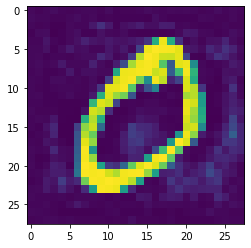

286
l2 dist: 1.7387393
target class:  2
pred of adv ex:  2


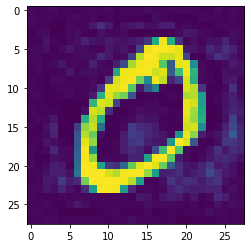

287
l2 dist: 1.726976
target class:  2
pred of adv ex:  2


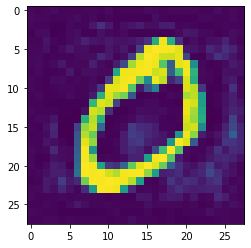

288
l2 dist: 1.7135903
target class:  2
pred of adv ex:  2


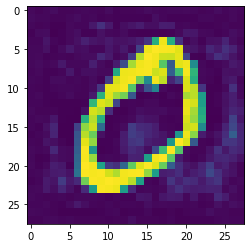

289
l2 dist: 1.6988504
target class:  2
pred of adv ex:  2


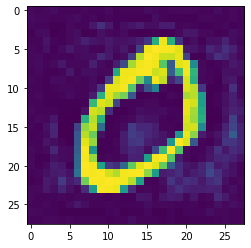

290
l2 dist: 1.6830043
target class:  2
pred of adv ex:  0


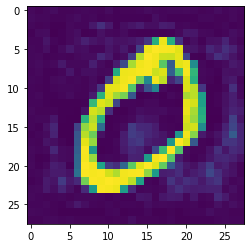

291
l2 dist: 1.6871741
target class:  2
pred of adv ex:  0


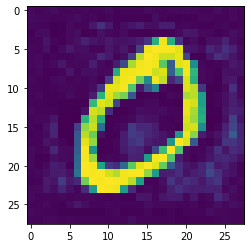

292
l2 dist: 1.7093925
target class:  2
pred of adv ex:  2


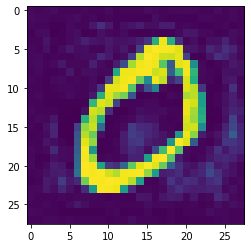

293
l2 dist: 1.7270689
target class:  2
pred of adv ex:  2


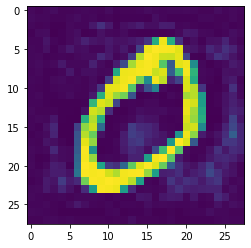

294
l2 dist: 1.7403477
target class:  2
pred of adv ex:  2


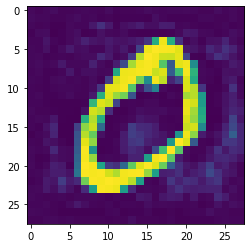

295
l2 dist: 1.7494406
target class:  2
pred of adv ex:  2


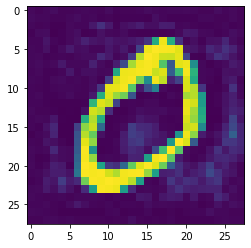

296
l2 dist: 1.7546085
target class:  2
pred of adv ex:  2


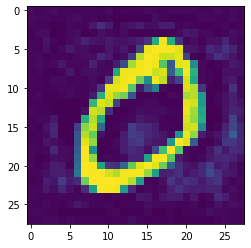

297
l2 dist: 1.7561476
target class:  2
pred of adv ex:  2


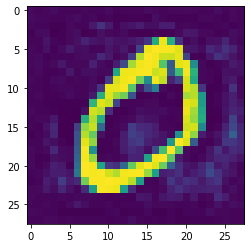

298
l2 dist: 1.7543763
target class:  2
pred of adv ex:  2


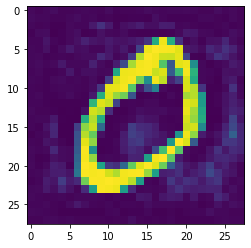

299
l2 dist: 1.7496247
target class:  2
pred of adv ex:  2


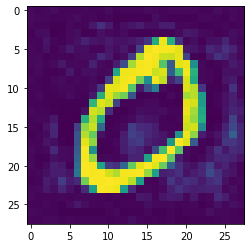

300
l2 dist: 1.7422261
target class:  2
pred of adv ex:  2


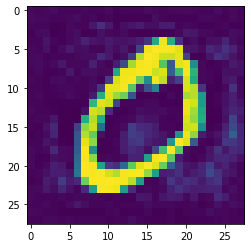

301
l2 dist: 1.7325083
target class:  2
pred of adv ex:  2


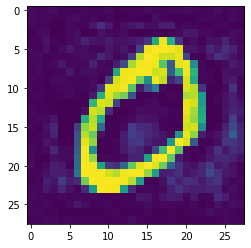

302
l2 dist: 1.7207887
target class:  2
pred of adv ex:  2


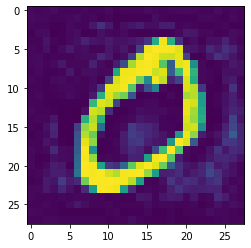

303
l2 dist: 1.7073686
target class:  2
pred of adv ex:  2


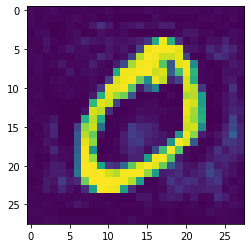

304
l2 dist: 1.69253
target class:  2
pred of adv ex:  2


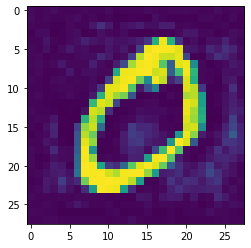

305
l2 dist: 1.6765332
target class:  2
pred of adv ex:  2


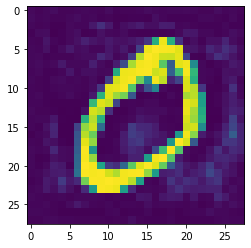

306
l2 dist: 1.6596153
target class:  2
pred of adv ex:  0


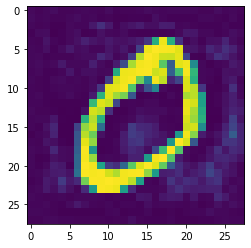

307
l2 dist: 1.6628902
target class:  2
pred of adv ex:  0


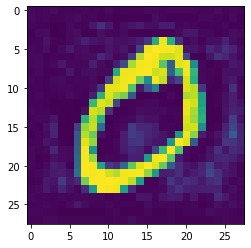

308
l2 dist: 1.6843785
target class:  2
pred of adv ex:  2


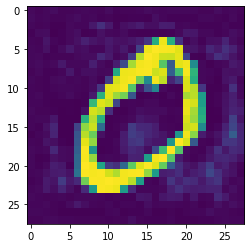

309
l2 dist: 1.7014606
target class:  2
pred of adv ex:  2


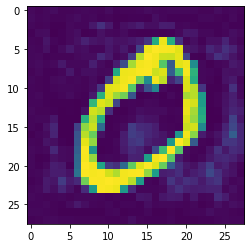

310
l2 dist: 1.7142631
target class:  2
pred of adv ex:  2


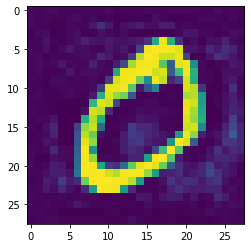

311
l2 dist: 1.7229761
target class:  2
pred of adv ex:  2


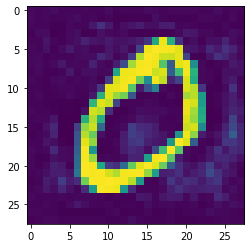

312
l2 dist: 1.7278432
target class:  2
pred of adv ex:  2


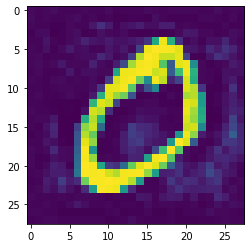

313
l2 dist: 1.7291497
target class:  2
pred of adv ex:  2


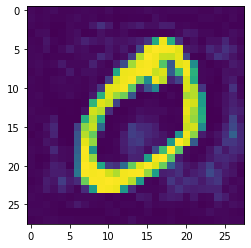

314
l2 dist: 1.72721
target class:  2
pred of adv ex:  2


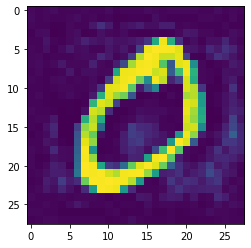

315
l2 dist: 1.7223566
target class:  2
pred of adv ex:  2


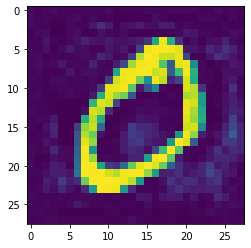

316
l2 dist: 1.7149262
target class:  2
pred of adv ex:  2


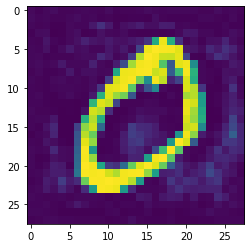

317
l2 dist: 1.7052503
target class:  2
pred of adv ex:  2


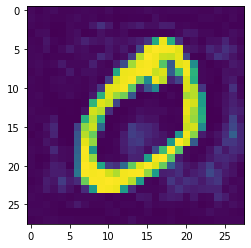

318
l2 dist: 1.6936467
target class:  2
pred of adv ex:  2


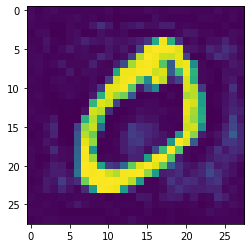

319
l2 dist: 1.680413
target class:  2
pred of adv ex:  2


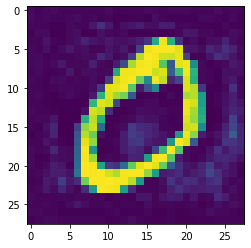

320
l2 dist: 1.6658232
target class:  2
pred of adv ex:  2


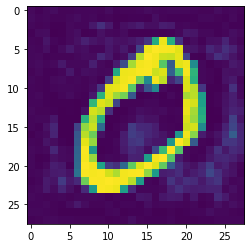

321
l2 dist: 1.6501269
target class:  2
pred of adv ex:  0


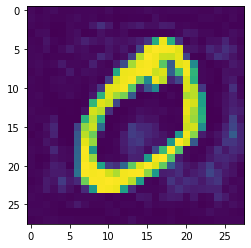

322
l2 dist: 1.654749
target class:  2
pred of adv ex:  2


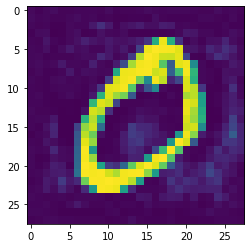

323
l2 dist: 1.6562852
target class:  2
pred of adv ex:  2


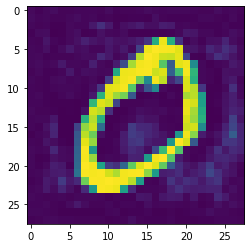

324
l2 dist: 1.6549981
target class:  2
pred of adv ex:  2


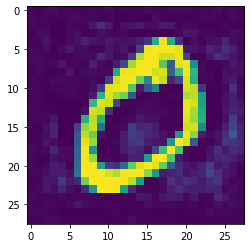

325
l2 dist: 1.6511565
target class:  2
pred of adv ex:  2


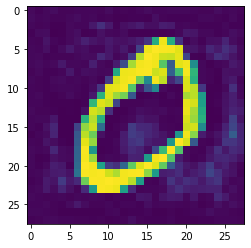

326
l2 dist: 1.6450309
target class:  2
pred of adv ex:  0


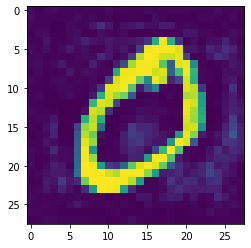

327
l2 dist: 1.6582838
target class:  2
pred of adv ex:  2


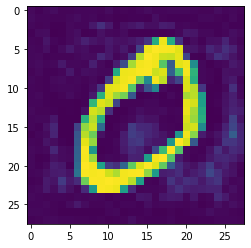

328
l2 dist: 1.6676855
target class:  2
pred of adv ex:  2


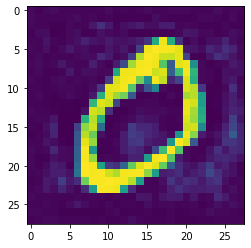

329
l2 dist: 1.6734555
target class:  2
pred of adv ex:  2


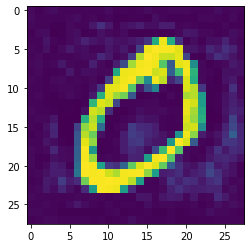

330
l2 dist: 1.6758462
target class:  2
pred of adv ex:  2


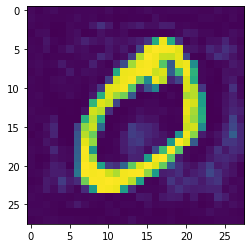

331
l2 dist: 1.6751335
target class:  2
pred of adv ex:  2


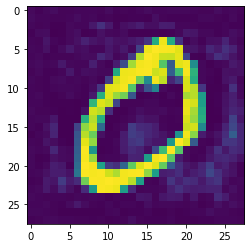

332
l2 dist: 1.6716062
target class:  2
pred of adv ex:  2


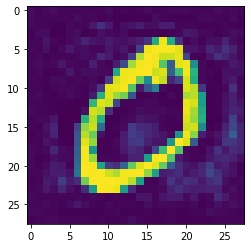

333
l2 dist: 1.6655599
target class:  2
pred of adv ex:  2


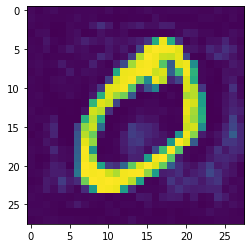

334
l2 dist: 1.6572894
target class:  2
pred of adv ex:  2


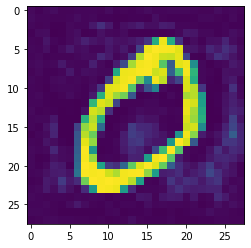

335
l2 dist: 1.6470832
target class:  2
pred of adv ex:  2


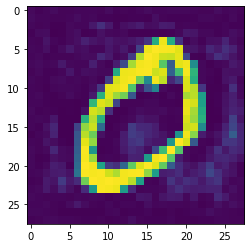

336
l2 dist: 1.6352177
target class:  2
pred of adv ex:  0


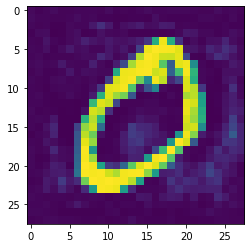

337
l2 dist: 1.6437358
target class:  2
pred of adv ex:  2


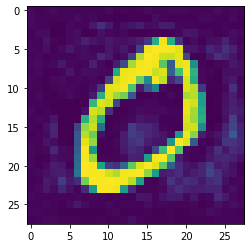

338
l2 dist: 1.648762
target class:  2
pred of adv ex:  2


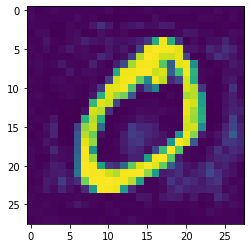

339
l2 dist: 1.6505544
target class:  2
pred of adv ex:  2


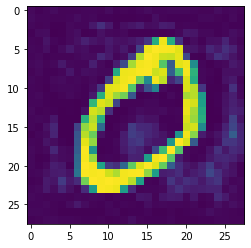

340
l2 dist: 1.6493881
target class:  2
pred of adv ex:  2


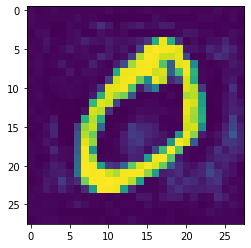

341
l2 dist: 1.6455468
target class:  2
pred of adv ex:  2


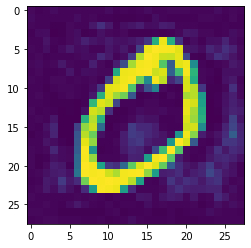

342
l2 dist: 1.6393169
target class:  2
pred of adv ex:  2


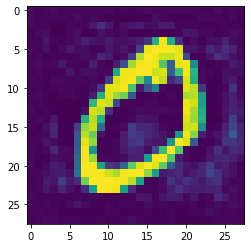

343
l2 dist: 1.6309801
target class:  2
pred of adv ex:  0


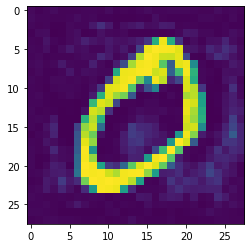

344
l2 dist: 1.6427758
target class:  2
pred of adv ex:  2


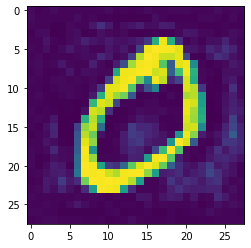

345
l2 dist: 1.6507627
target class:  2
pred of adv ex:  2


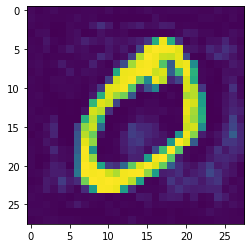

346
l2 dist: 1.6551837
target class:  2
pred of adv ex:  2


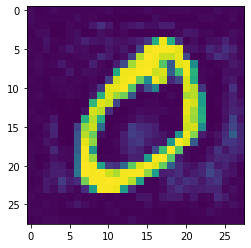

347
l2 dist: 1.6563106
target class:  2
pred of adv ex:  2


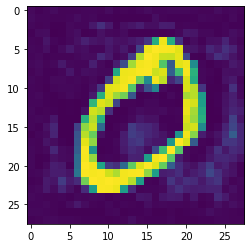

348
l2 dist: 1.654434
target class:  2
pred of adv ex:  2


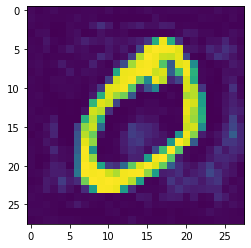

349
l2 dist: 1.6498549
target class:  2
pred of adv ex:  2


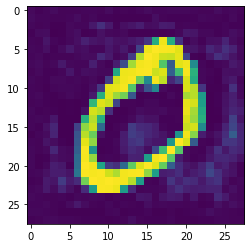

350
l2 dist: 1.6428773
target class:  2
pred of adv ex:  2


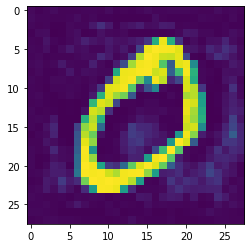

351
l2 dist: 1.6338012
target class:  2
pred of adv ex:  2


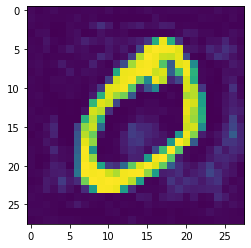

352
l2 dist: 1.6229159
target class:  2
pred of adv ex:  0


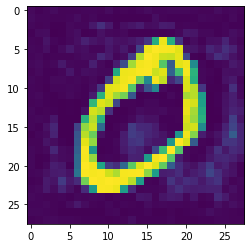

353
l2 dist: 1.6325458
target class:  2
pred of adv ex:  2


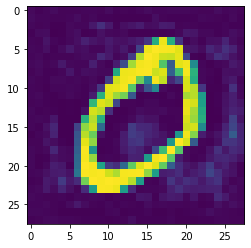

354
l2 dist: 1.6385391
target class:  2
pred of adv ex:  2


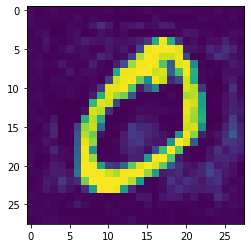

355
l2 dist: 1.6411633
target class:  2
pred of adv ex:  2


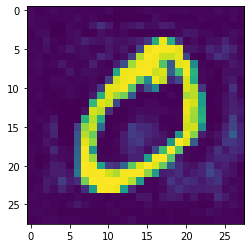

356
l2 dist: 1.6407038
target class:  2
pred of adv ex:  2


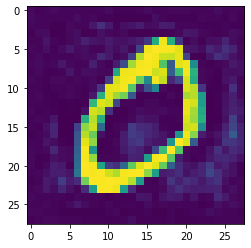

357
l2 dist: 1.6374549
target class:  2
pred of adv ex:  2


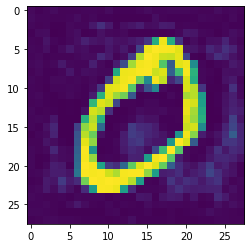

358
l2 dist: 1.6317129
target class:  2
pred of adv ex:  2


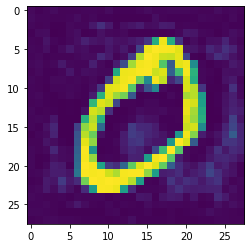

359
l2 dist: 1.6237705
target class:  2
pred of adv ex:  2


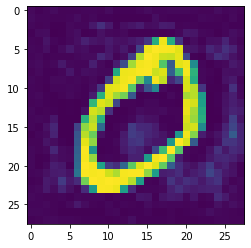

360
l2 dist: 1.613911
target class:  2
pred of adv ex:  0


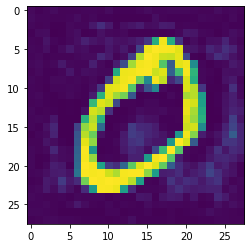

361
l2 dist: 1.624474
target class:  2
pred of adv ex:  2


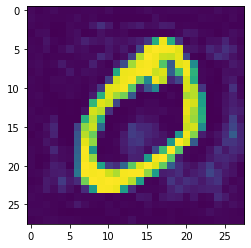

362
l2 dist: 1.6313373
target class:  2
pred of adv ex:  2


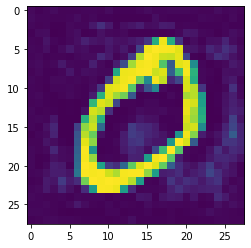

363
l2 dist: 1.6347598
target class:  2
pred of adv ex:  2


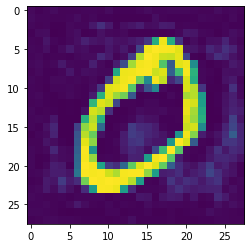

364
l2 dist: 1.6350205
target class:  2
pred of adv ex:  2


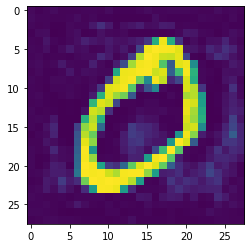

365
l2 dist: 1.6324103
target class:  2
pred of adv ex:  2


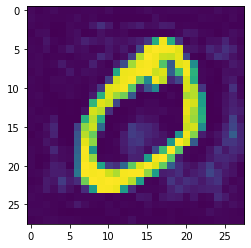

366
l2 dist: 1.6272252
target class:  2
pred of adv ex:  2


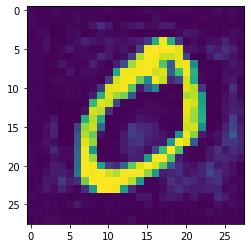

367
l2 dist: 1.6197606
target class:  2
pred of adv ex:  2


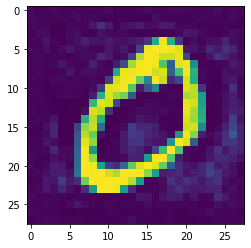

368
l2 dist: 1.6103055
target class:  2
pred of adv ex:  2


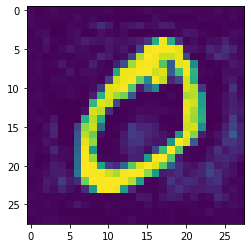

369
l2 dist: 1.5991391
target class:  2
pred of adv ex:  0


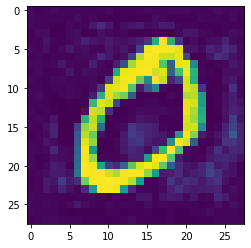

370
l2 dist: 1.6084704
target class:  2
pred of adv ex:  2


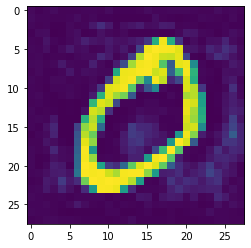

371
l2 dist: 1.6142495
target class:  2
pred of adv ex:  2


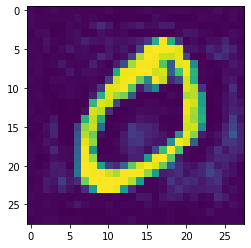

372
l2 dist: 1.616738
target class:  2
pred of adv ex:  2


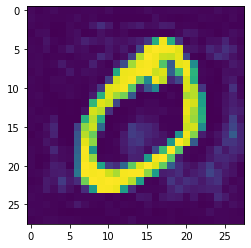

373
l2 dist: 1.6162149
target class:  2
pred of adv ex:  2


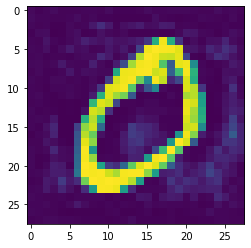

374
l2 dist: 1.6129677
target class:  2
pred of adv ex:  2


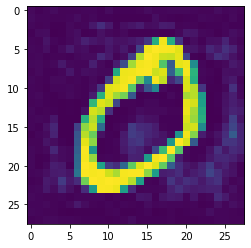

375
l2 dist: 1.6072856
target class:  2
pred of adv ex:  2


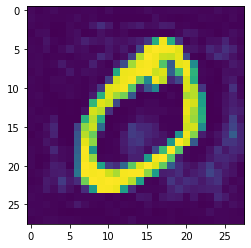

376
l2 dist: 1.5994542
target class:  2
pred of adv ex:  0


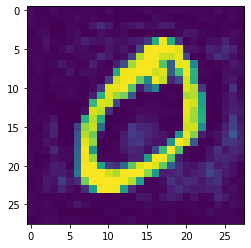

377
l2 dist: 1.6120349
target class:  2
pred of adv ex:  2


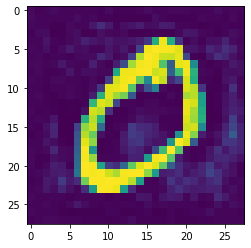

378
l2 dist: 1.6207294
target class:  2
pred of adv ex:  2


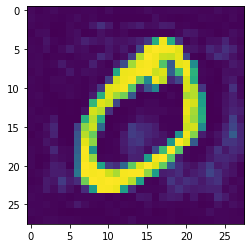

379
l2 dist: 1.6257858
target class:  2
pred of adv ex:  2


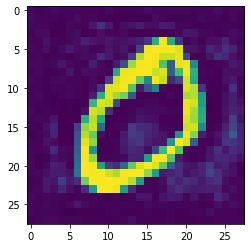

380
l2 dist: 1.6274823
target class:  2
pred of adv ex:  2


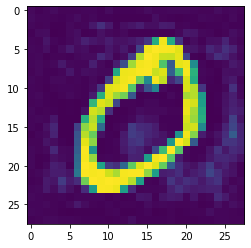

381
l2 dist: 1.6261151
target class:  2
pred of adv ex:  2


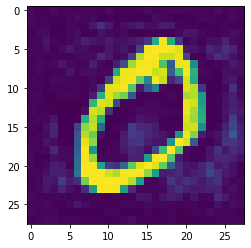

382
l2 dist: 1.6219901
target class:  2
pred of adv ex:  2


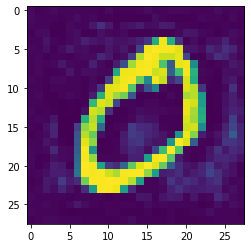

383
l2 dist: 1.615414
target class:  2
pred of adv ex:  2


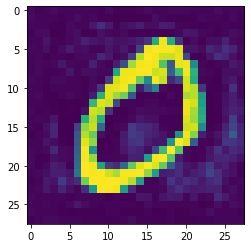

384
l2 dist: 1.6066893
target class:  2
pred of adv ex:  2


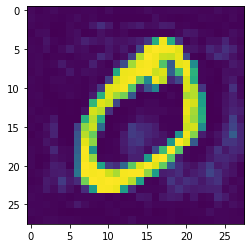

385
l2 dist: 1.5961071
target class:  2
pred of adv ex:  0


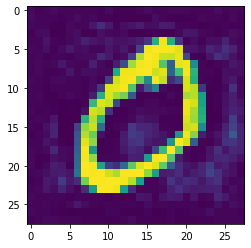

386
l2 dist: 1.606306
target class:  2
pred of adv ex:  2


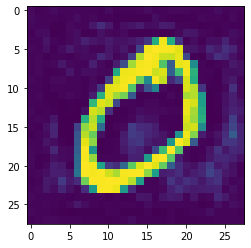

387
l2 dist: 1.6128105
target class:  2
pred of adv ex:  2


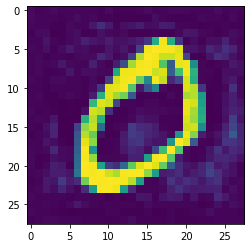

388
l2 dist: 1.615883
target class:  2
pred of adv ex:  2


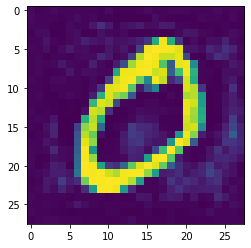

389
l2 dist: 1.6158055
target class:  2
pred of adv ex:  2


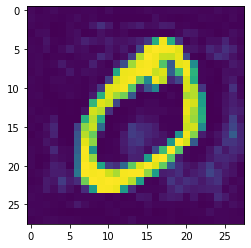

390
l2 dist: 1.612874
target class:  2
pred of adv ex:  2


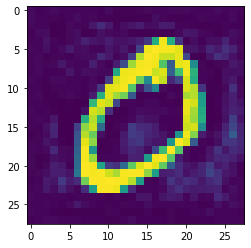

391
l2 dist: 1.6073898
target class:  2
pred of adv ex:  2


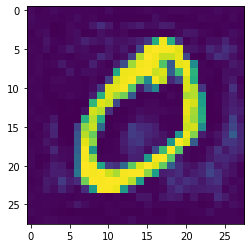

392
l2 dist: 1.5996546
target class:  2
pred of adv ex:  2


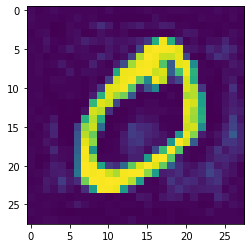

393
l2 dist: 1.5899627
target class:  2
pred of adv ex:  0


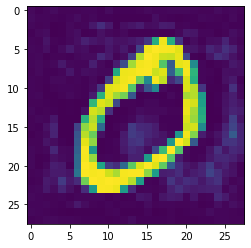

394
l2 dist: 1.6010478
target class:  2
pred of adv ex:  2


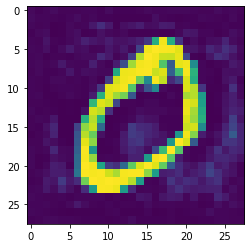

395
l2 dist: 1.6083499
target class:  2
pred of adv ex:  2


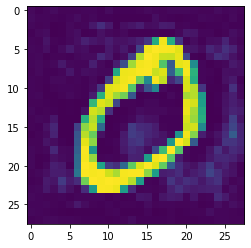

396
l2 dist: 1.6121386
target class:  2
pred of adv ex:  2


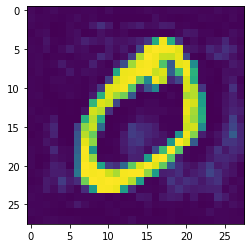

397
l2 dist: 1.6127042
target class:  2
pred of adv ex:  2


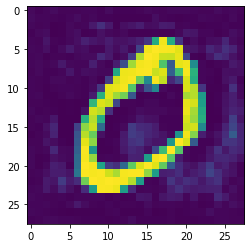

398
l2 dist: 1.6103479
target class:  2
pred of adv ex:  2


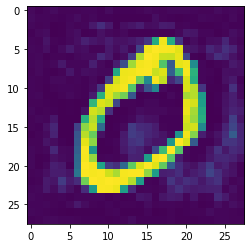

399
l2 dist: 1.6053743
target class:  2
pred of adv ex:  2


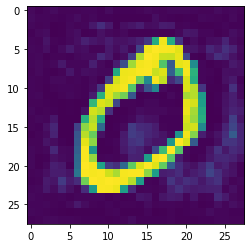

400
l2 dist: 1.5980856
target class:  2
pred of adv ex:  2


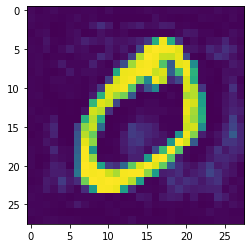

401
l2 dist: 1.588775
target class:  2
pred of adv ex:  2


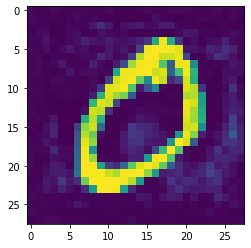

402
l2 dist: 1.5777243
target class:  2
pred of adv ex:  0


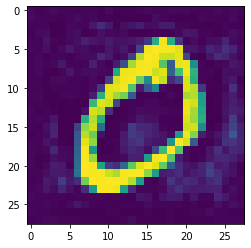

403
l2 dist: 1.587482
target class:  2
pred of adv ex:  2


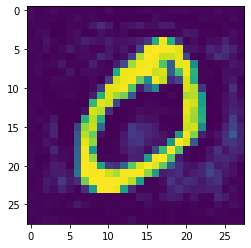

404
l2 dist: 1.5936345
target class:  2
pred of adv ex:  2


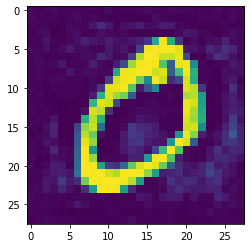

405
l2 dist: 1.5964446
target class:  2
pred of adv ex:  2


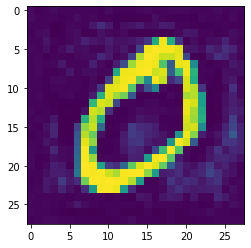

406
l2 dist: 1.5961919
target class:  2
pred of adv ex:  2


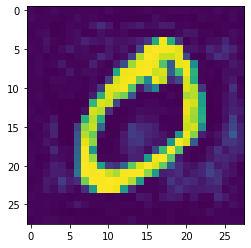

407
l2 dist: 1.5931648
target class:  2
pred of adv ex:  2


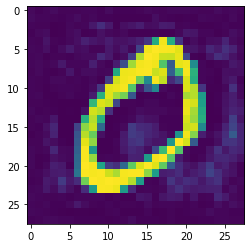

408
l2 dist: 1.5876551
target class:  2
pred of adv ex:  2


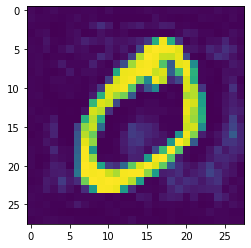

409
l2 dist: 1.5799526
target class:  2
pred of adv ex:  2


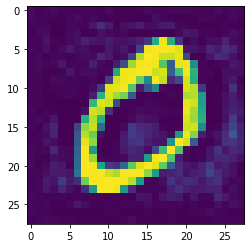

410
l2 dist: 1.5703408
target class:  2
pred of adv ex:  0


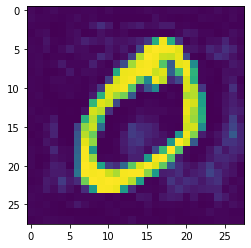

411
l2 dist: 1.5813899
target class:  2
pred of adv ex:  2


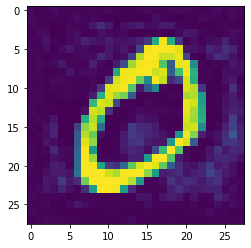

412
l2 dist: 1.5887188
target class:  2
pred of adv ex:  2


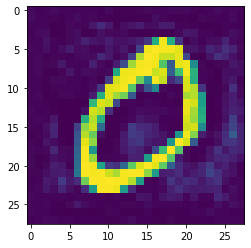

413
l2 dist: 1.5925857
target class:  2
pred of adv ex:  2


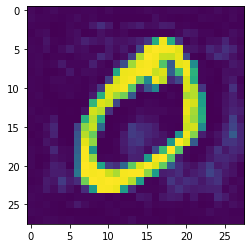

414
l2 dist: 1.5932715
target class:  2
pred of adv ex:  2


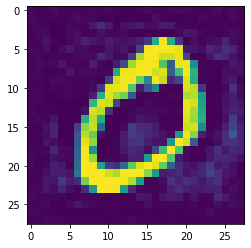

415
l2 dist: 1.5910693
target class:  2
pred of adv ex:  2


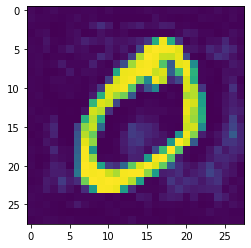

416
l2 dist: 1.5862768
target class:  2
pred of adv ex:  2


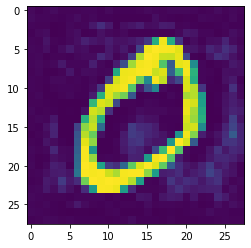

417
l2 dist: 1.5791883
target class:  2
pred of adv ex:  2


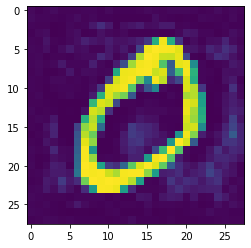

418
l2 dist: 1.5700927
target class:  2
pred of adv ex:  0


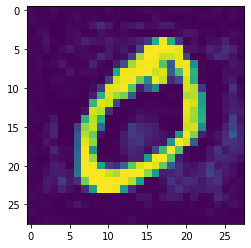

419
l2 dist: 1.5818666
target class:  2
pred of adv ex:  2


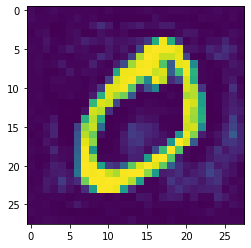

420
l2 dist: 1.5898113
target class:  2
pred of adv ex:  2


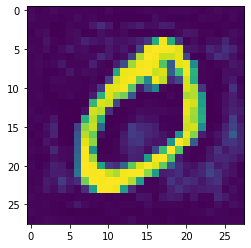

421
l2 dist: 1.5941852
target class:  2
pred of adv ex:  2


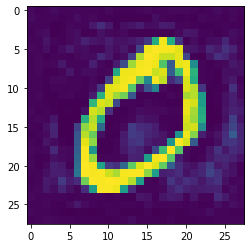

422
l2 dist: 1.5952721
target class:  2
pred of adv ex:  2


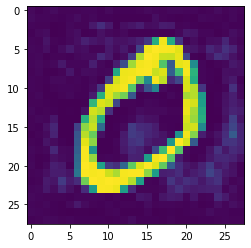

423
l2 dist: 1.5933721
target class:  2
pred of adv ex:  2


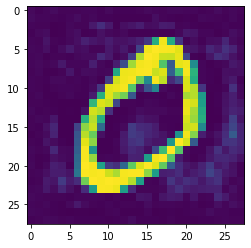

424
l2 dist: 1.5887917
target class:  2
pred of adv ex:  2


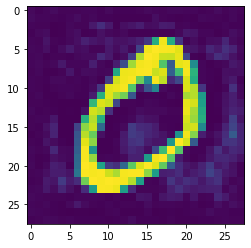

425
l2 dist: 1.5818372
target class:  2
pred of adv ex:  2


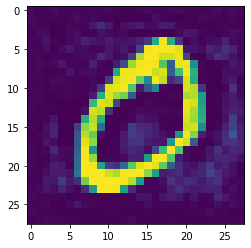

426
l2 dist: 1.5728077
target class:  2
pred of adv ex:  2


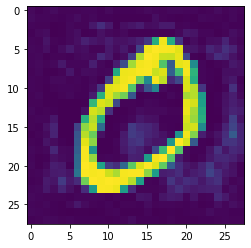

427
l2 dist: 1.5619911
target class:  2
pred of adv ex:  0


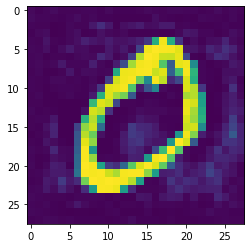

428
l2 dist: 1.5721778
target class:  2
pred of adv ex:  2


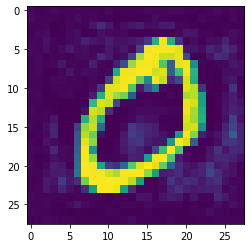

429
l2 dist: 1.5787065
target class:  2
pred of adv ex:  2


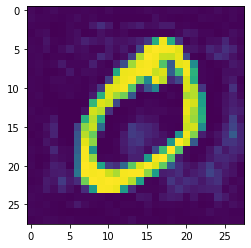

430
l2 dist: 1.5818349
target class:  2
pred of adv ex:  2


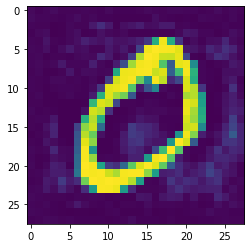

431
l2 dist: 1.5818404
target class:  2
pred of adv ex:  2


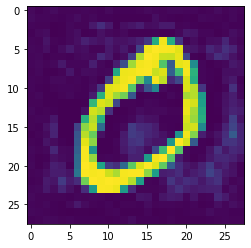

432
l2 dist: 1.5790149
target class:  2
pred of adv ex:  2


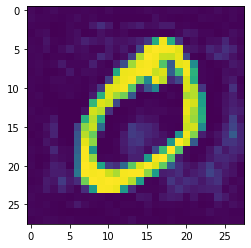

433
l2 dist: 1.5736564
target class:  2
pred of adv ex:  2


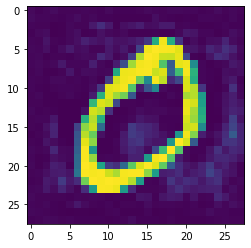

434
l2 dist: 1.5660645
target class:  2
pred of adv ex:  2


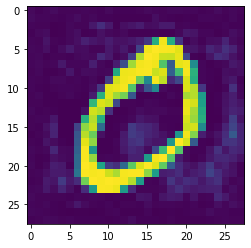

435
l2 dist: 1.556532
target class:  2
pred of adv ex:  0


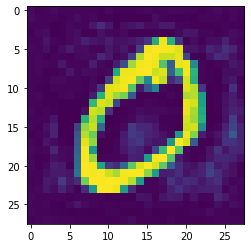

436
l2 dist: 1.5679543
target class:  2
pred of adv ex:  2


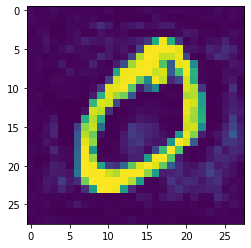

437
l2 dist: 1.5755947
target class:  2
pred of adv ex:  2


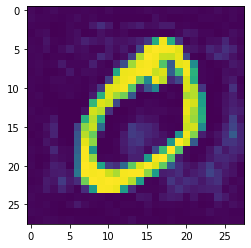

438
l2 dist: 1.5797182
target class:  2
pred of adv ex:  2


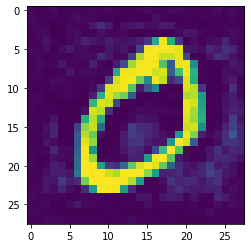

439
l2 dist: 1.5806118
target class:  2
pred of adv ex:  2


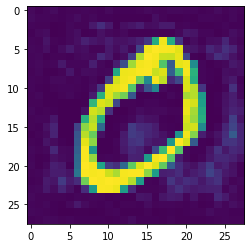

440
l2 dist: 1.5785738
target class:  2
pred of adv ex:  2


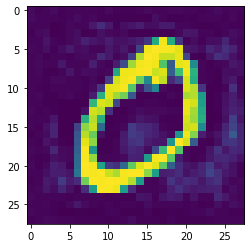

441
l2 dist: 1.5739073
target class:  2
pred of adv ex:  2


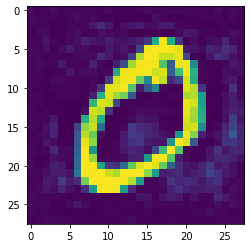

442
l2 dist: 1.5669128
target class:  2
pred of adv ex:  2


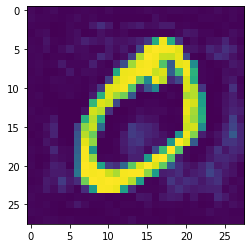

443
l2 dist: 1.5578835
target class:  2
pred of adv ex:  0


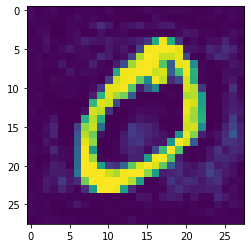

444
l2 dist: 1.5698673
target class:  2
pred of adv ex:  2


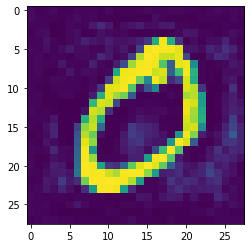

445
l2 dist: 1.5779874
target class:  2
pred of adv ex:  2


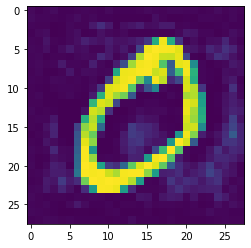

446
l2 dist: 1.5825076
target class:  2
pred of adv ex:  2


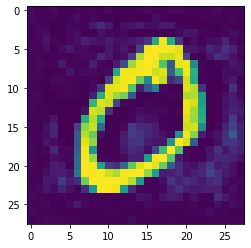

447
l2 dist: 1.5837147
target class:  2
pred of adv ex:  2


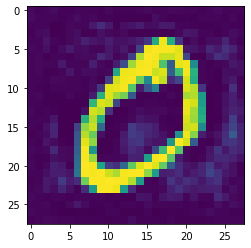

448
l2 dist: 1.5819099
target class:  2
pred of adv ex:  2


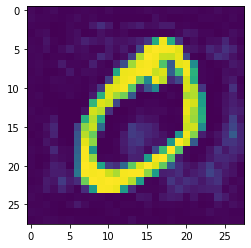

449
l2 dist: 1.5774015
target class:  2
pred of adv ex:  2


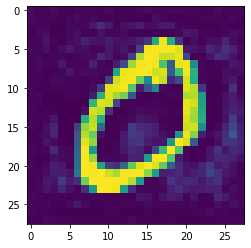

450
l2 dist: 1.5704978
target class:  2
pred of adv ex:  2


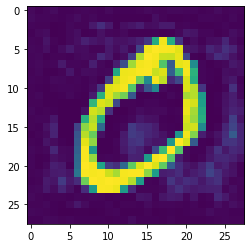

451
l2 dist: 1.5615016
target class:  2
pred of adv ex:  2


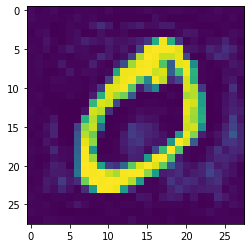

452
l2 dist: 1.5507048
target class:  2
pred of adv ex:  0


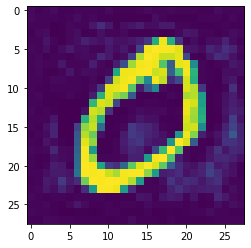

453
l2 dist: 1.5610814
target class:  2
pred of adv ex:  2


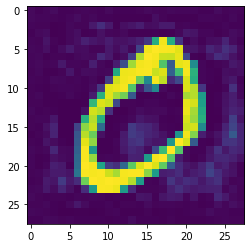

454
l2 dist: 1.5677551
target class:  2
pred of adv ex:  2


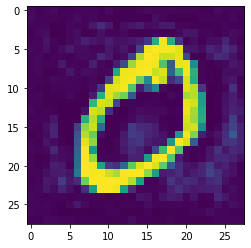

455
l2 dist: 1.5709987
target class:  2
pred of adv ex:  2


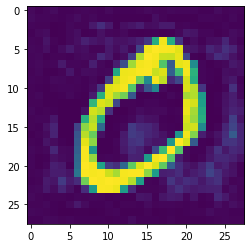

456
l2 dist: 1.5711023
target class:  2
pred of adv ex:  2


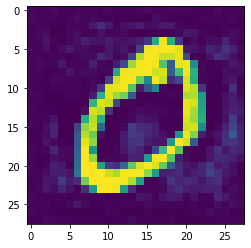

457
l2 dist: 1.5683655
target class:  2
pred of adv ex:  2


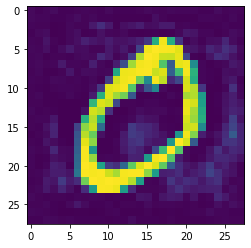

458
l2 dist: 1.5630885
target class:  2
pred of adv ex:  2


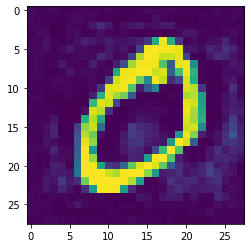

459
l2 dist: 1.5555687
target class:  2
pred of adv ex:  2


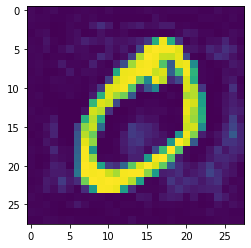

460
l2 dist: 1.5460933
target class:  2
pred of adv ex:  0


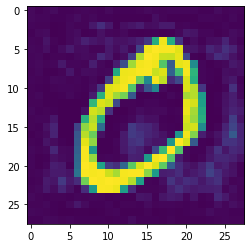

461
l2 dist: 1.5576996
target class:  2
pred of adv ex:  2


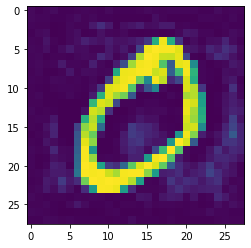

462
l2 dist: 1.5655057
target class:  2
pred of adv ex:  2


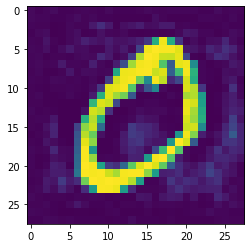

463
l2 dist: 1.5697718
target class:  2
pred of adv ex:  2


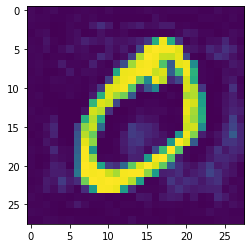

464
l2 dist: 1.5707787
target class:  2
pred of adv ex:  2


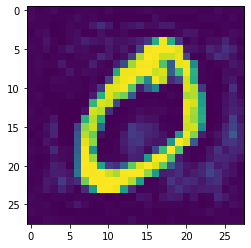

465
l2 dist: 1.5688211
target class:  2
pred of adv ex:  2


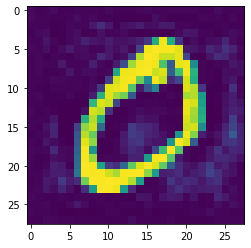

466
l2 dist: 1.5642009
target class:  2
pred of adv ex:  2


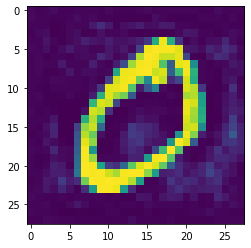

467
l2 dist: 1.5572208
target class:  2
pred of adv ex:  2


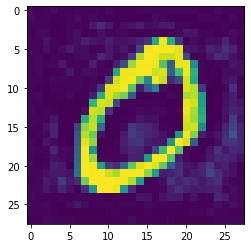

468
l2 dist: 1.5481787
target class:  2
pred of adv ex:  2


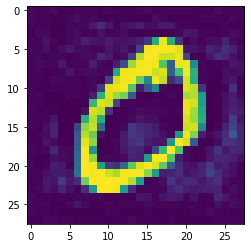

469
l2 dist: 1.5373625
target class:  2
pred of adv ex:  0


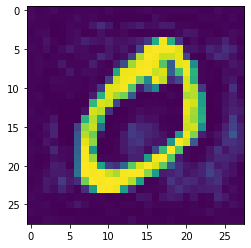

470
l2 dist: 1.5478221
target class:  2
pred of adv ex:  2


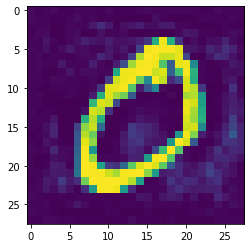

471
l2 dist: 1.5545931
target class:  2
pred of adv ex:  2


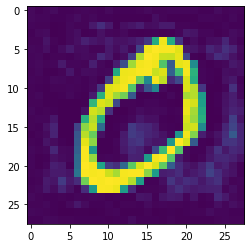

472
l2 dist: 1.5579429
target class:  2
pred of adv ex:  2


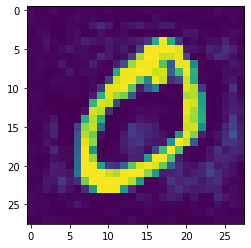

473
l2 dist: 1.5581579
target class:  2
pred of adv ex:  2


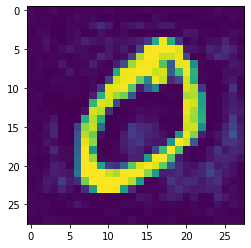

474
l2 dist: 1.5555359
target class:  2
pred of adv ex:  2


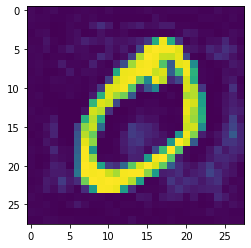

475
l2 dist: 1.5503769
target class:  2
pred of adv ex:  2


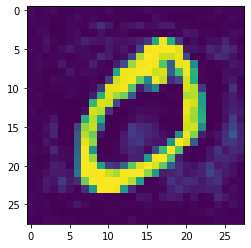

476
l2 dist: 1.542978
target class:  2
pred of adv ex:  0


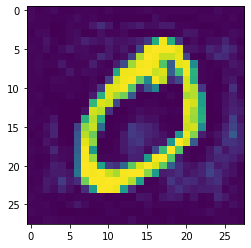

477
l2 dist: 1.5567429
target class:  2
pred of adv ex:  2


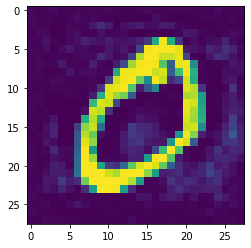

478
l2 dist: 1.5664603
target class:  2
pred of adv ex:  2


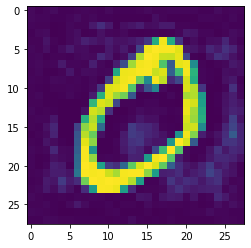

479
l2 dist: 1.572387
target class:  2
pred of adv ex:  2


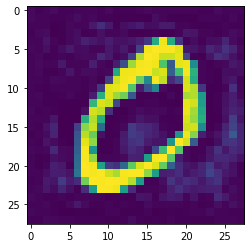

480
l2 dist: 1.5748115
target class:  2
pred of adv ex:  2


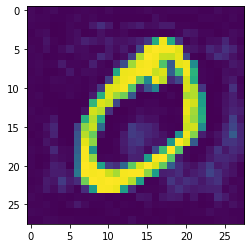

481
l2 dist: 1.5740428
target class:  2
pred of adv ex:  2


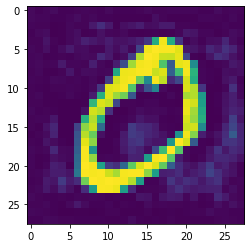

482
l2 dist: 1.5704008
target class:  2
pred of adv ex:  2


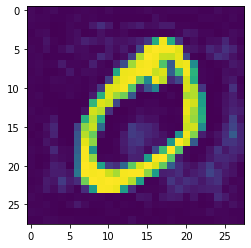

483
l2 dist: 1.5642073
target class:  2
pred of adv ex:  2


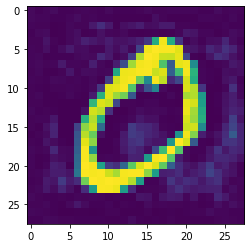

484
l2 dist: 1.5557773
target class:  2
pred of adv ex:  2


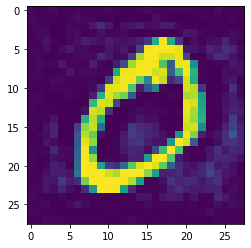

485
l2 dist: 1.5454159
target class:  2
pred of adv ex:  2


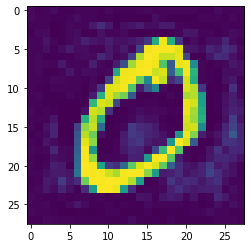

486
l2 dist: 1.5334111
target class:  2
pred of adv ex:  0


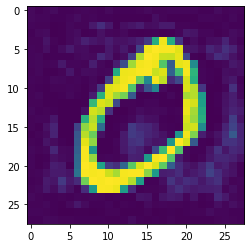

487
l2 dist: 1.542974
target class:  2
pred of adv ex:  2


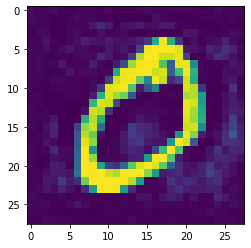

488
l2 dist: 1.5489228
target class:  2
pred of adv ex:  2


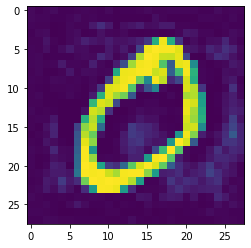

489
l2 dist: 1.5515237
target class:  2
pred of adv ex:  2


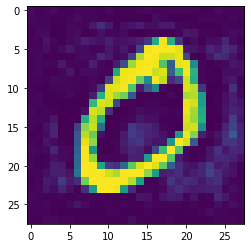

490
l2 dist: 1.5510595
target class:  2
pred of adv ex:  2


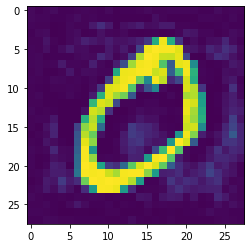

491
l2 dist: 1.547824
target class:  2
pred of adv ex:  2


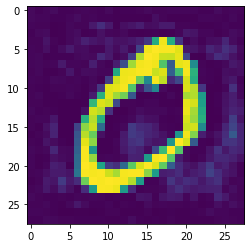

492
l2 dist: 1.5421154
target class:  2
pred of adv ex:  2


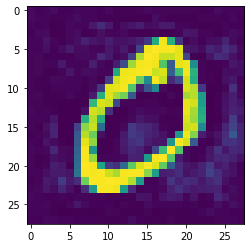

493
l2 dist: 1.53423
target class:  2
pred of adv ex:  0


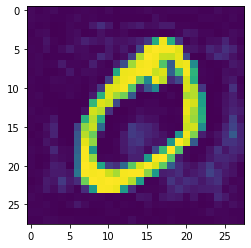

494
l2 dist: 1.5475684
target class:  2
pred of adv ex:  2


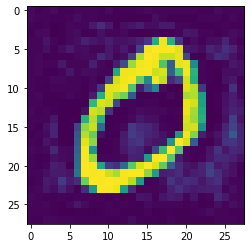

495
l2 dist: 1.5569162
target class:  2
pred of adv ex:  2


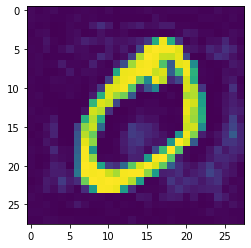

496
l2 dist: 1.562535
target class:  2
pred of adv ex:  2


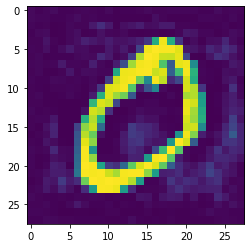

497
l2 dist: 1.5647131
target class:  2
pred of adv ex:  2


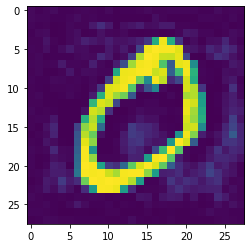

498
l2 dist: 1.5637547
target class:  2
pred of adv ex:  2


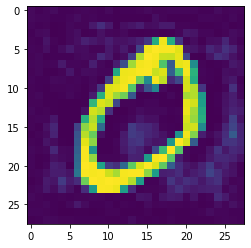

499
l2 dist: 1.5599718
target class:  2
pred of adv ex:  2


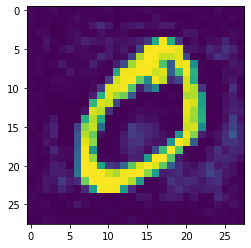

500
l2 dist: 1.5536764
target class:  2
pred of adv ex:  2


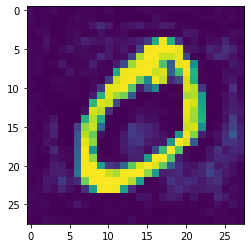

501
l2 dist: 1.545176
target class:  2
pred of adv ex:  2


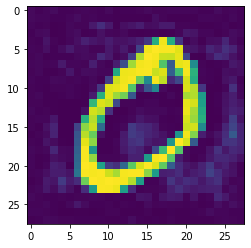

502
l2 dist: 1.5347672
target class:  2
pred of adv ex:  2


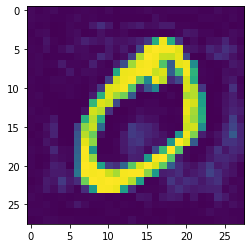

503
l2 dist: 1.522733
target class:  2
pred of adv ex:  0


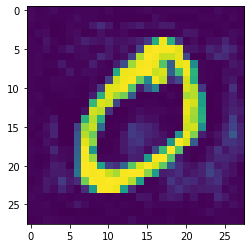

504
l2 dist: 1.5322902
target class:  2
pred of adv ex:  2


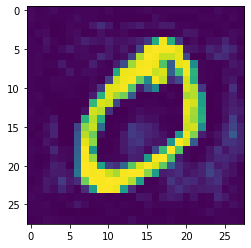

505
l2 dist: 1.5382551
target class:  2
pred of adv ex:  2


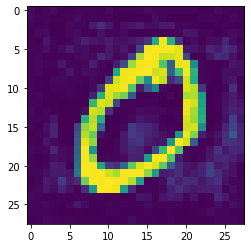

506
l2 dist: 1.5408945
target class:  2
pred of adv ex:  2


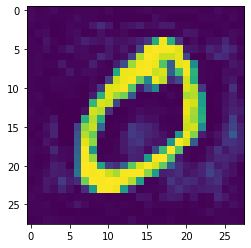

507
l2 dist: 1.5404888
target class:  2
pred of adv ex:  2


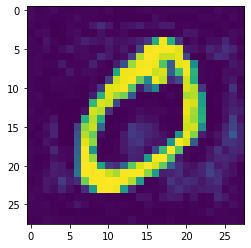

508
l2 dist: 1.5373268
target class:  2
pred of adv ex:  2


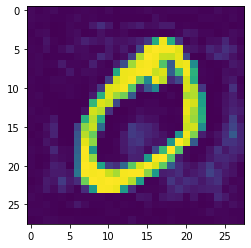

509
l2 dist: 1.5317003
target class:  2
pred of adv ex:  2


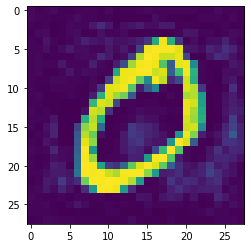

510
l2 dist: 1.5238993
target class:  2
pred of adv ex:  0


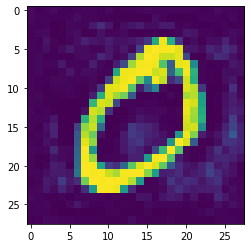

511
l2 dist: 1.5374396
target class:  2
pred of adv ex:  2


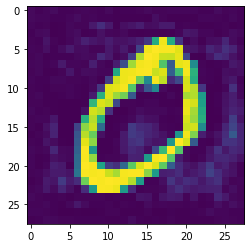

512
l2 dist: 1.5469736
target class:  2
pred of adv ex:  2


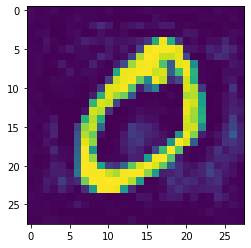

513
l2 dist: 1.5527588
target class:  2
pred of adv ex:  2


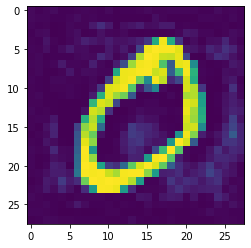

514
l2 dist: 1.5550839
target class:  2
pred of adv ex:  2


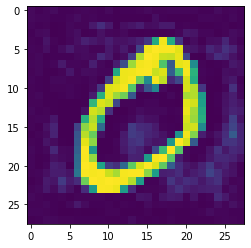

515
l2 dist: 1.5542562
target class:  2
pred of adv ex:  2


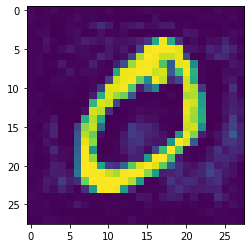

516
l2 dist: 1.550593
target class:  2
pred of adv ex:  2


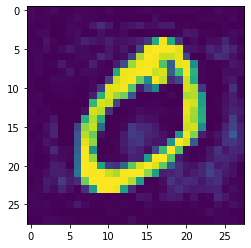

517
l2 dist: 1.5444123
target class:  2
pred of adv ex:  2


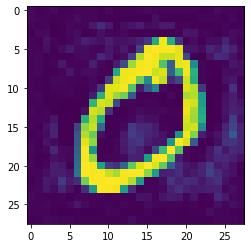

518
l2 dist: 1.5360247
target class:  2
pred of adv ex:  2


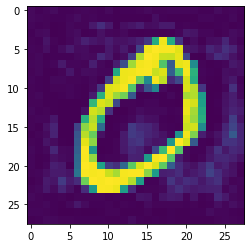

519
l2 dist: 1.5257304
target class:  2
pred of adv ex:  0


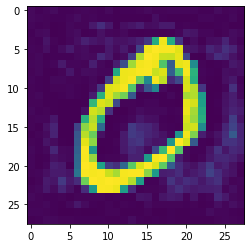

520
l2 dist: 1.5372136
target class:  2
pred of adv ex:  2


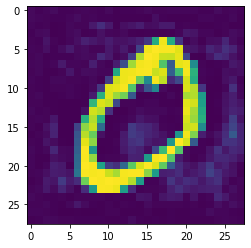

521
l2 dist: 1.5448407
target class:  2
pred of adv ex:  2


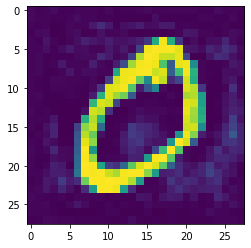

522
l2 dist: 1.548887
target class:  2
pred of adv ex:  2


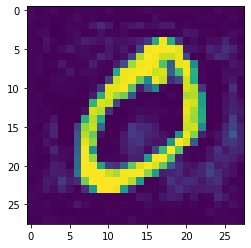

523
l2 dist: 1.5496484
target class:  2
pred of adv ex:  2


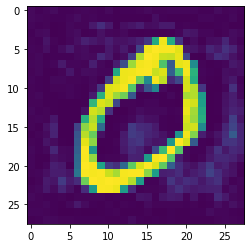

524
l2 dist: 1.5474335
target class:  2
pred of adv ex:  2


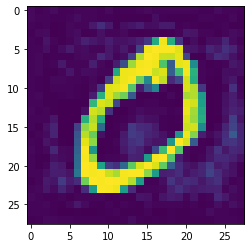

525
l2 dist: 1.5425553
target class:  2
pred of adv ex:  2


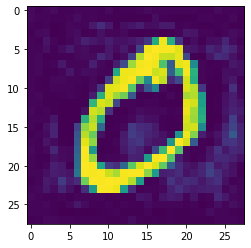

526
l2 dist: 1.5353255
target class:  2
pred of adv ex:  2


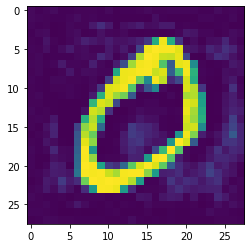

527
l2 dist: 1.5260475
target class:  2
pred of adv ex:  2


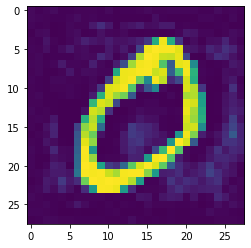

528
l2 dist: 1.5150125
target class:  2
pred of adv ex:  0


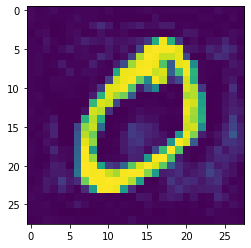

529
l2 dist: 1.5256698
target class:  2
pred of adv ex:  2


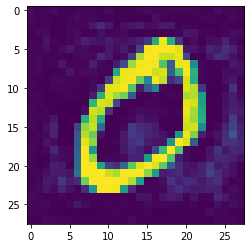

530
l2 dist: 1.5326091
target class:  2
pred of adv ex:  2


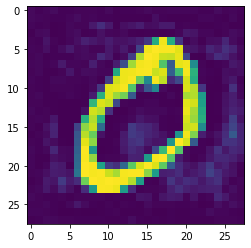

531
l2 dist: 1.5361003
target class:  2
pred of adv ex:  2


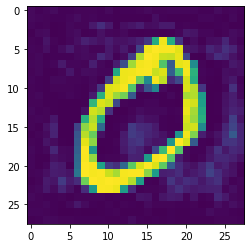

532
l2 dist: 1.536431
target class:  2
pred of adv ex:  2


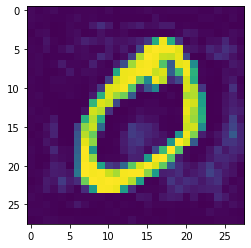

533
l2 dist: 1.5338993
target class:  2
pred of adv ex:  2


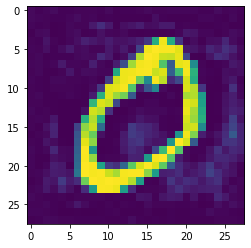

534
l2 dist: 1.5288055
target class:  2
pred of adv ex:  2


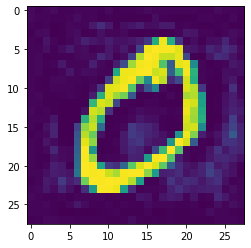

535
l2 dist: 1.5214474
target class:  2
pred of adv ex:  2


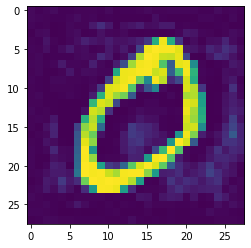

536
l2 dist: 1.5121139
target class:  2
pred of adv ex:  0


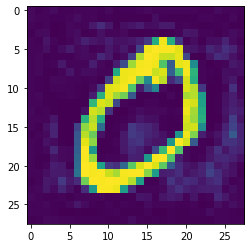

537
l2 dist: 1.52437
target class:  2
pred of adv ex:  2


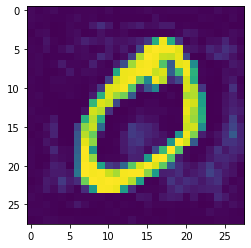

538
l2 dist: 1.5327688
target class:  2
pred of adv ex:  2


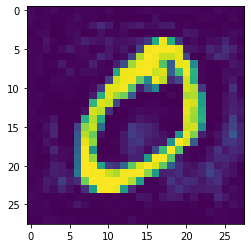

539
l2 dist: 1.5375655
target class:  2
pred of adv ex:  2


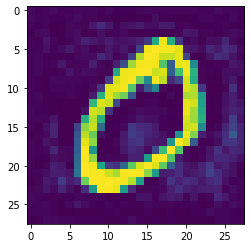

540
l2 dist: 1.5390387
target class:  2
pred of adv ex:  2


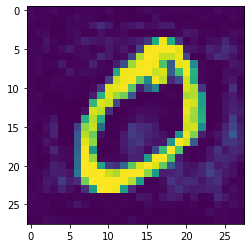

541
l2 dist: 1.5374832
target class:  2
pred of adv ex:  2


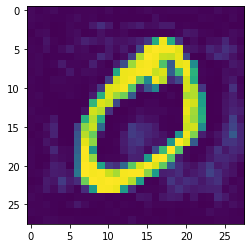

542
l2 dist: 1.5332032
target class:  2
pred of adv ex:  2


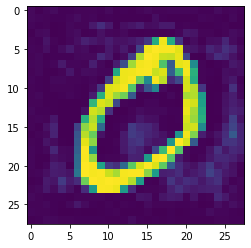

543
l2 dist: 1.5265062
target class:  2
pred of adv ex:  2


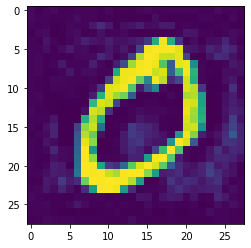

544
l2 dist: 1.5176959
target class:  2
pred of adv ex:  2


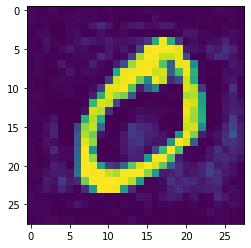

545
l2 dist: 1.5070666
target class:  2
pred of adv ex:  0


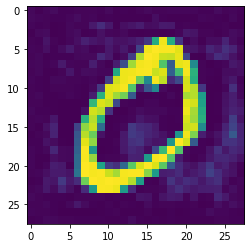

546
l2 dist: 1.518265
target class:  2
pred of adv ex:  2


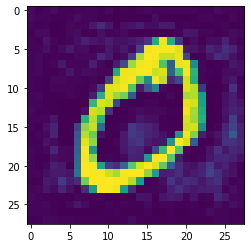

547
l2 dist: 1.5256838
target class:  2
pred of adv ex:  2


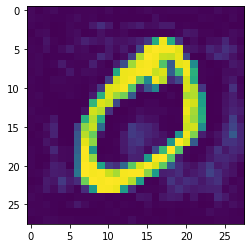

548
l2 dist: 1.5295919
target class:  2
pred of adv ex:  2


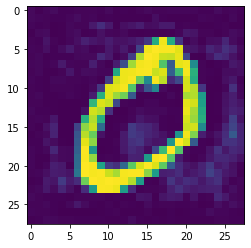

549
l2 dist: 1.5302798
target class:  2
pred of adv ex:  2


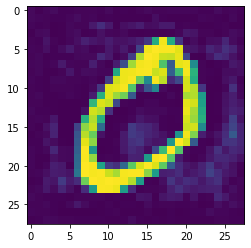

550
l2 dist: 1.5280496
target class:  2
pred of adv ex:  2


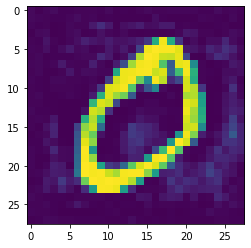

551
l2 dist: 1.5232085
target class:  2
pred of adv ex:  2


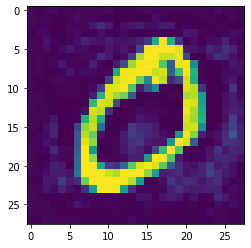

552
l2 dist: 1.5160606
target class:  2
pred of adv ex:  2


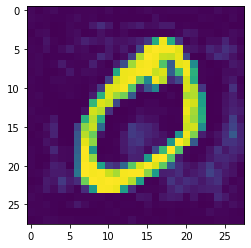

553
l2 dist: 1.5069025
target class:  2
pred of adv ex:  0


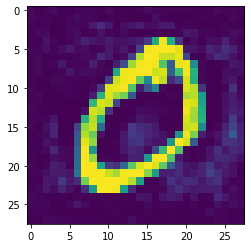

554
l2 dist: 1.5194627
target class:  2
pred of adv ex:  2


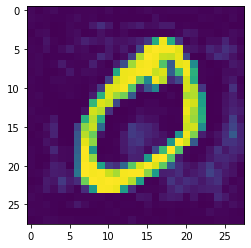

555
l2 dist: 1.5281111
target class:  2
pred of adv ex:  2


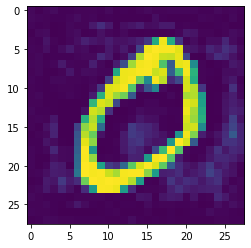

556
l2 dist: 1.5331085
target class:  2
pred of adv ex:  2


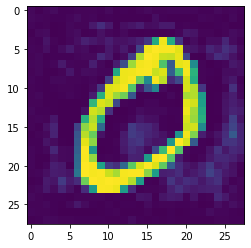

557
l2 dist: 1.534741
target class:  2
pred of adv ex:  2


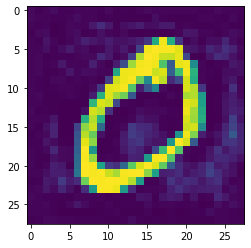

558
l2 dist: 1.5333114
target class:  2
pred of adv ex:  2


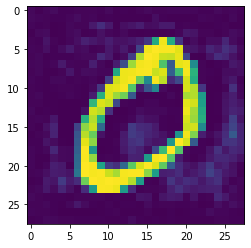

559
l2 dist: 1.5291302
target class:  2
pred of adv ex:  2


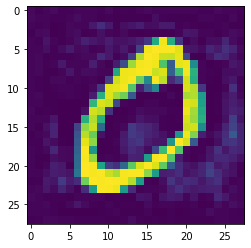

560
l2 dist: 1.522511
target class:  2
pred of adv ex:  2


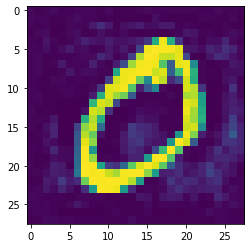

561
l2 dist: 1.513762
target class:  2
pred of adv ex:  2


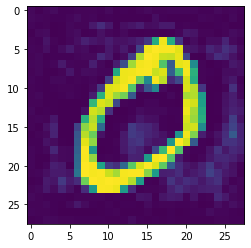

562
l2 dist: 1.5031806
target class:  2
pred of adv ex:  0


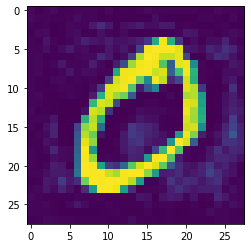

563
l2 dist: 1.5144583
target class:  2
pred of adv ex:  2


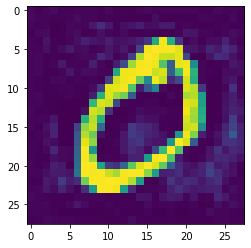

564
l2 dist: 1.5219429
target class:  2
pred of adv ex:  2


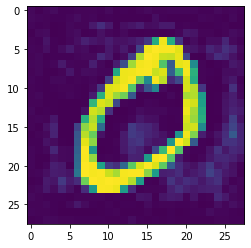

565
l2 dist: 1.5259054
target class:  2
pred of adv ex:  2


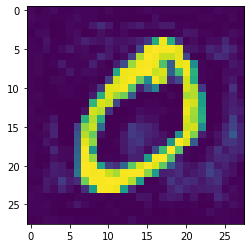

566
l2 dist: 1.5266365
target class:  2
pred of adv ex:  2


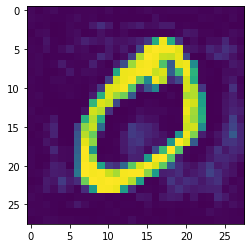

567
l2 dist: 1.5244383
target class:  2
pred of adv ex:  2


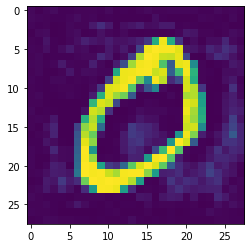

568
l2 dist: 1.519616
target class:  2
pred of adv ex:  2


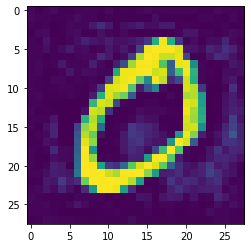

569
l2 dist: 1.5124724
target class:  2
pred of adv ex:  2


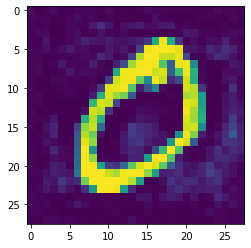

570
l2 dist: 1.5033035
target class:  2
pred of adv ex:  0


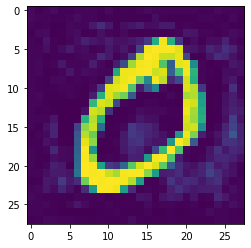

571
l2 dist: 1.5159451
target class:  2
pred of adv ex:  2


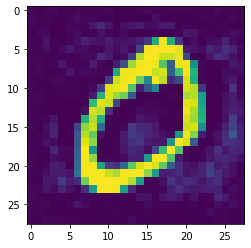

572
l2 dist: 1.5246614
target class:  2
pred of adv ex:  2


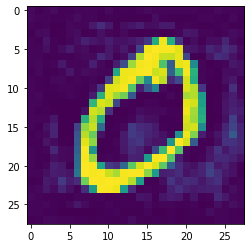

573
l2 dist: 1.5297133
target class:  2
pred of adv ex:  2


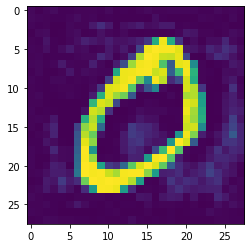

574
l2 dist: 1.5313853
target class:  2
pred of adv ex:  2


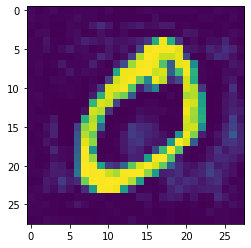

575
l2 dist: 1.5299778
target class:  2
pred of adv ex:  2


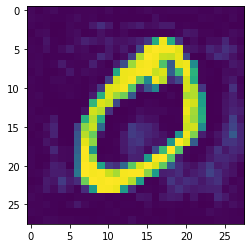

576
l2 dist: 1.5258002
target class:  2
pred of adv ex:  2


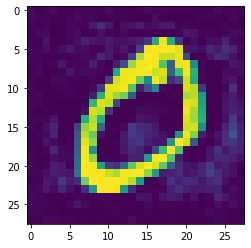

577
l2 dist: 1.5191653
target class:  2
pred of adv ex:  2


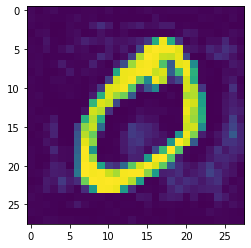

578
l2 dist: 1.5103818
target class:  2
pred of adv ex:  2


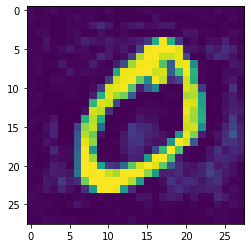

579
l2 dist: 1.49975
target class:  2
pred of adv ex:  0


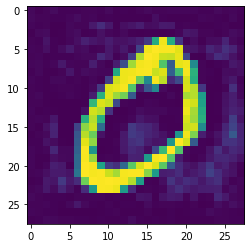

580
l2 dist: 1.5111825
target class:  2
pred of adv ex:  2


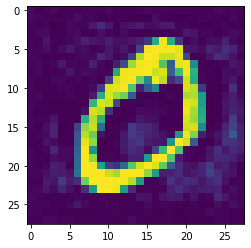

581
l2 dist: 1.5187829
target class:  2
pred of adv ex:  2


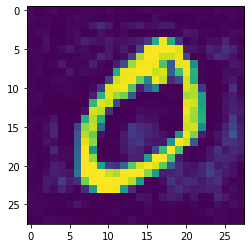

582
l2 dist: 1.522825
target class:  2
pred of adv ex:  2


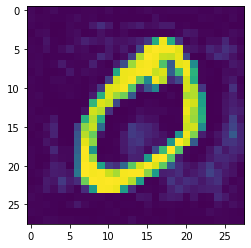

583
l2 dist: 1.5236046
target class:  2
pred of adv ex:  2


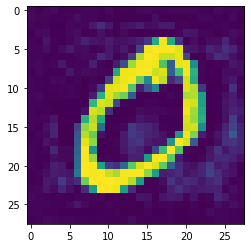

584
l2 dist: 1.521429
target class:  2
pred of adv ex:  2


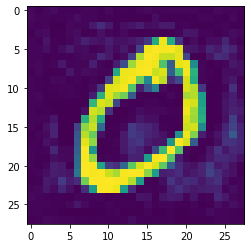

585
l2 dist: 1.5166091
target class:  2
pred of adv ex:  2


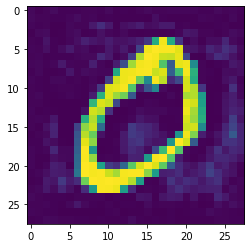

586
l2 dist: 1.5094532
target class:  2
pred of adv ex:  2


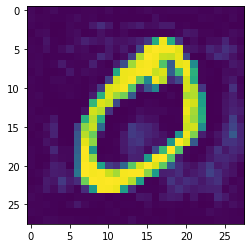

587
l2 dist: 1.5002618
target class:  2
pred of adv ex:  0


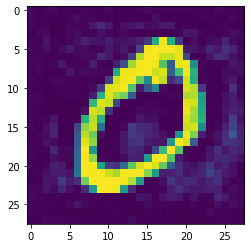

588
l2 dist: 1.5130229
target class:  2
pred of adv ex:  2


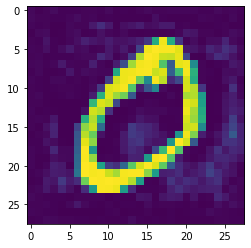

589
l2 dist: 1.521825
target class:  2
pred of adv ex:  2


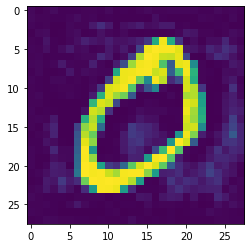

590
l2 dist: 1.5269328
target class:  2
pred of adv ex:  2


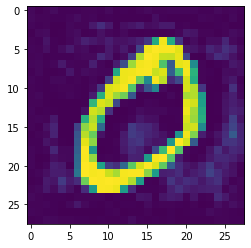

591
l2 dist: 1.5286365
target class:  2
pred of adv ex:  2


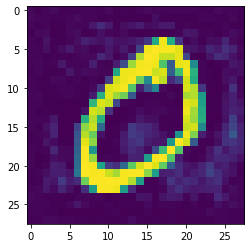

592
l2 dist: 1.5272423
target class:  2
pred of adv ex:  2


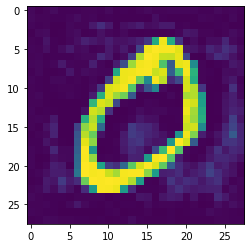

593
l2 dist: 1.5230651
target class:  2
pred of adv ex:  2


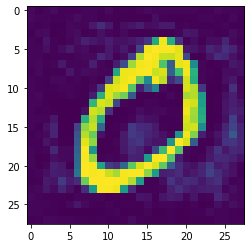

594
l2 dist: 1.516422
target class:  2
pred of adv ex:  2


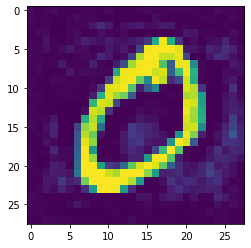

595
l2 dist: 1.5076255
target class:  2
pred of adv ex:  2


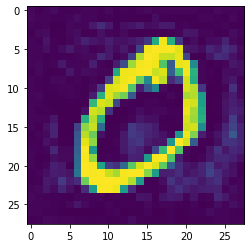

596
l2 dist: 1.4969766
target class:  2
pred of adv ex:  0


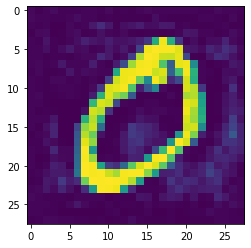

597
l2 dist: 1.5084194
target class:  2
pred of adv ex:  2


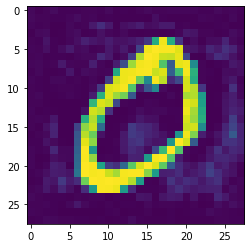

598
l2 dist: 1.516027
target class:  2
pred of adv ex:  2


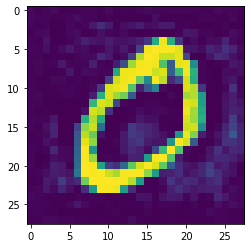

599
l2 dist: 1.5200738
target class:  2
pred of adv ex:  2


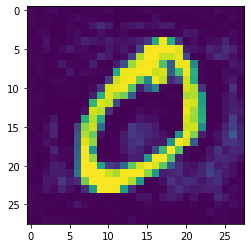

600
l2 dist: 1.5208539
target class:  2
pred of adv ex:  2


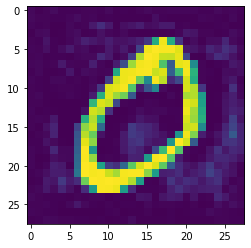

601
l2 dist: 1.518673
target class:  2
pred of adv ex:  2


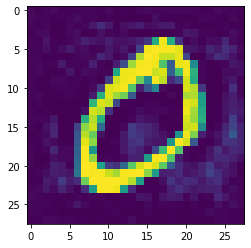

602
l2 dist: 1.5138395
target class:  2
pred of adv ex:  2


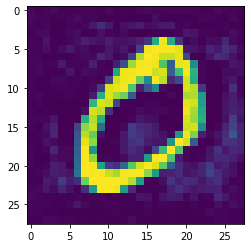

603
l2 dist: 1.5066605
target class:  2
pred of adv ex:  2


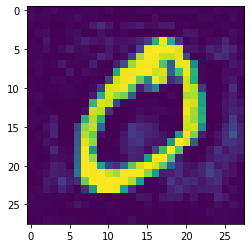

604
l2 dist: 1.4974346
target class:  2
pred of adv ex:  0


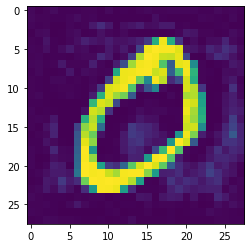

605
l2 dist: 1.5102496
target class:  2
pred of adv ex:  2


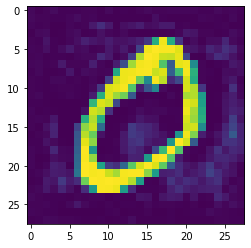

606
l2 dist: 1.5190976
target class:  2
pred of adv ex:  2


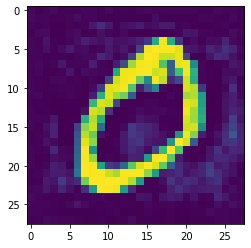

607
l2 dist: 1.5242418
target class:  2
pred of adv ex:  2


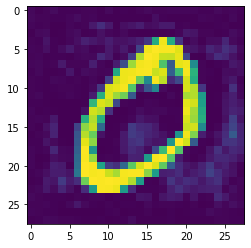

608
l2 dist: 1.5259701
target class:  2
pred of adv ex:  2


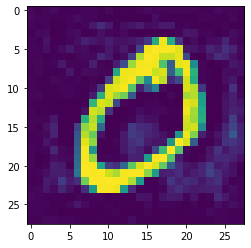

609
l2 dist: 1.5245856
target class:  2
pred of adv ex:  2


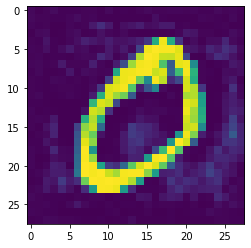

610
l2 dist: 1.520401
target class:  2
pred of adv ex:  2


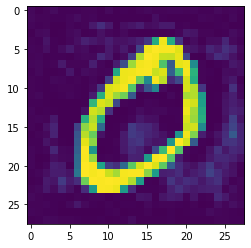

611
l2 dist: 1.5137327
target class:  2
pred of adv ex:  2


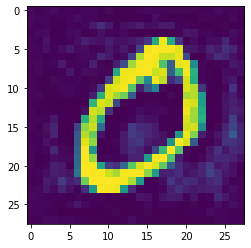

612
l2 dist: 1.5048938
target class:  2
pred of adv ex:  2


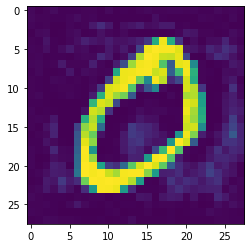

613
l2 dist: 1.4941876
target class:  2
pred of adv ex:  0


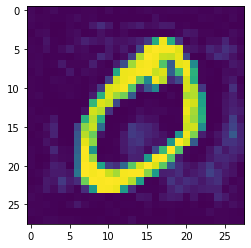

614
l2 dist: 1.5057749
target class:  2
pred of adv ex:  2


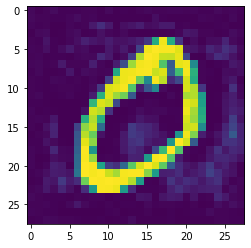

615
l2 dist: 1.5134897
target class:  2
pred of adv ex:  2


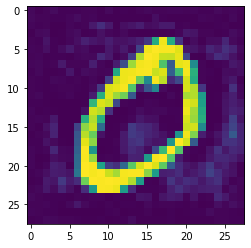

616
l2 dist: 1.5176096
target class:  2
pred of adv ex:  2


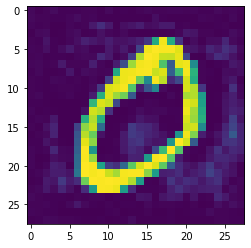

617
l2 dist: 1.5184327
target class:  2
pred of adv ex:  2


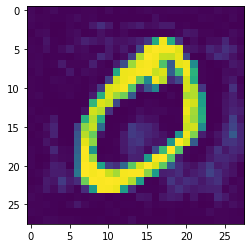

618
l2 dist: 1.5162698
target class:  2
pred of adv ex:  2


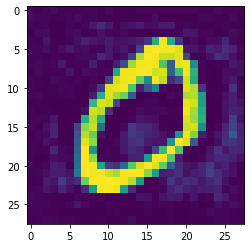

619
l2 dist: 1.5114354
target class:  2
pred of adv ex:  2


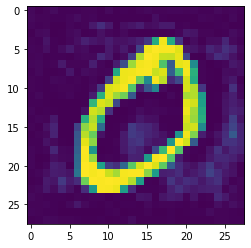

620
l2 dist: 1.5042415
target class:  2
pred of adv ex:  2


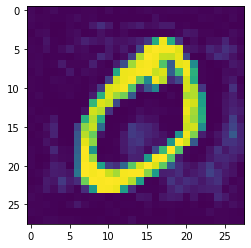

621
l2 dist: 1.4949914
target class:  2
pred of adv ex:  2


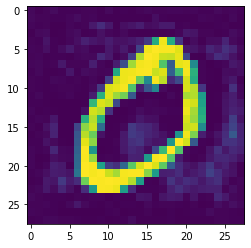

622
l2 dist: 1.483976
target class:  2
pred of adv ex:  0


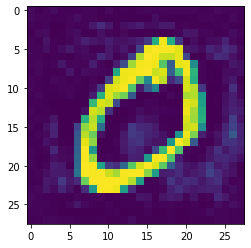

623
l2 dist: 1.4951011
target class:  2
pred of adv ex:  2


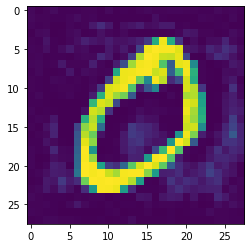

624
l2 dist: 1.5024683
target class:  2
pred of adv ex:  2


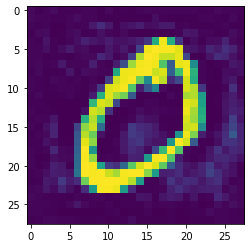

625
l2 dist: 1.5063411
target class:  2
pred of adv ex:  2


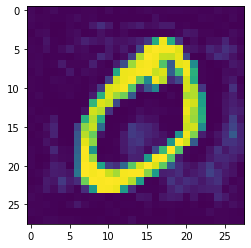

626
l2 dist: 1.5070024
target class:  2
pred of adv ex:  2


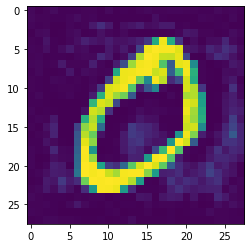

627
l2 dist: 1.504747
target class:  2
pred of adv ex:  2


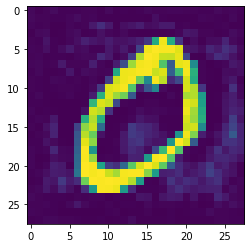

628
l2 dist: 1.4998764
target class:  2
pred of adv ex:  2


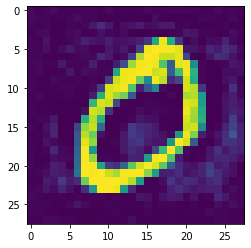

629
l2 dist: 1.4926939
target class:  2
pred of adv ex:  0


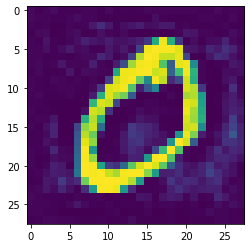

630
l2 dist: 1.5074939
target class:  2
pred of adv ex:  2


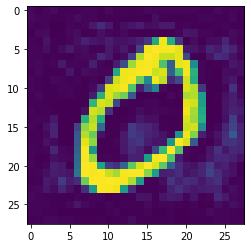

631
l2 dist: 1.5181146
target class:  2
pred of adv ex:  2


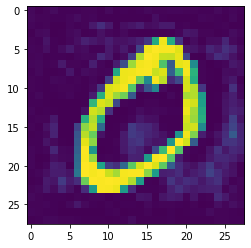

632
l2 dist: 1.5248177
target class:  2
pred of adv ex:  2


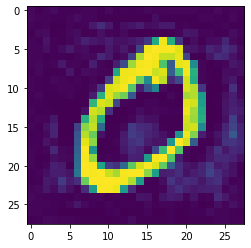

633
l2 dist: 1.5278986
target class:  2
pred of adv ex:  2


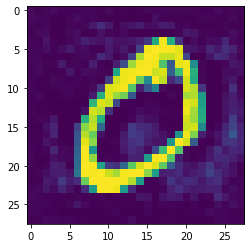

634
l2 dist: 1.5276734
target class:  2
pred of adv ex:  2


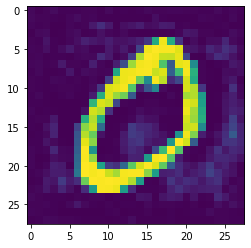

635
l2 dist: 1.5244682
target class:  2
pred of adv ex:  2


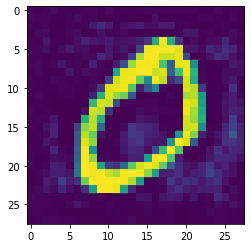

636
l2 dist: 1.5186111
target class:  2
pred of adv ex:  2


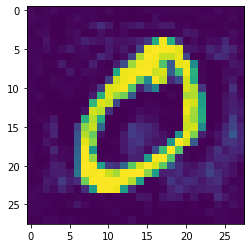

637
l2 dist: 1.5104253
target class:  2
pred of adv ex:  2


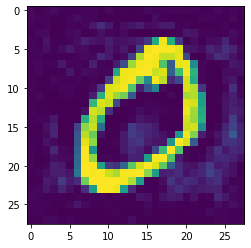

638
l2 dist: 1.5002235
target class:  2
pred of adv ex:  2


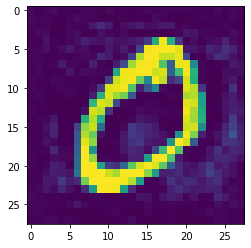

639
l2 dist: 1.4883035
target class:  2
pred of adv ex:  0


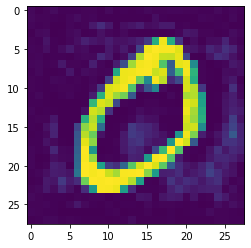

640
l2 dist: 1.4988538
target class:  2
pred of adv ex:  2


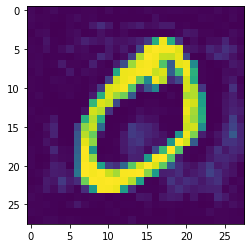

641
l2 dist: 1.5056367
target class:  2
pred of adv ex:  2


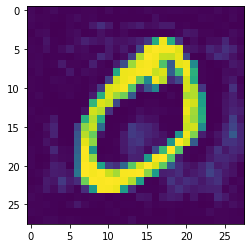

642
l2 dist: 1.5089302
target class:  2
pred of adv ex:  2


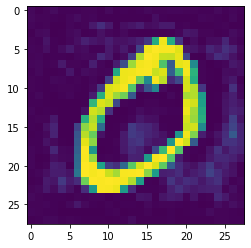

643
l2 dist: 1.5090269
target class:  2
pred of adv ex:  2


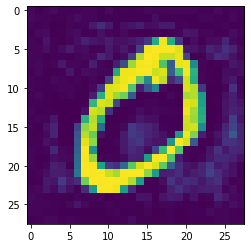

644
l2 dist: 1.506229
target class:  2
pred of adv ex:  2


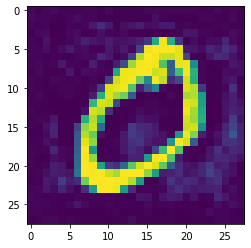

645
l2 dist: 1.5008427
target class:  2
pred of adv ex:  2


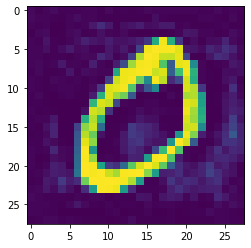

646
l2 dist: 1.4931731
target class:  2
pred of adv ex:  2


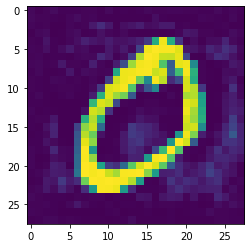

647
l2 dist: 1.4835203
target class:  2
pred of adv ex:  0


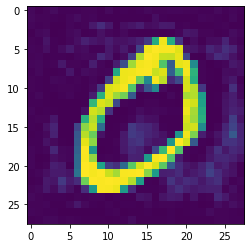

648
l2 dist: 1.496131
target class:  2
pred of adv ex:  2


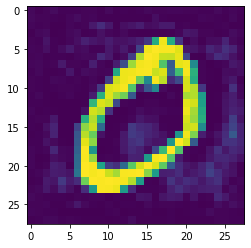

649
l2 dist: 1.5047913
target class:  2
pred of adv ex:  2


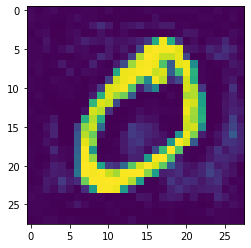

650
l2 dist: 1.5097704
target class:  2
pred of adv ex:  2


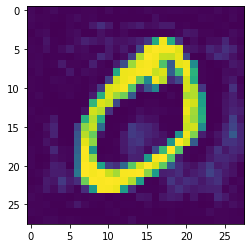

651
l2 dist: 1.5113629
target class:  2
pred of adv ex:  2


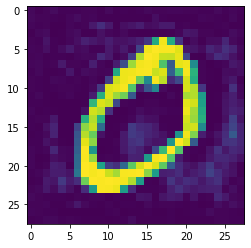

652
l2 dist: 1.5098779
target class:  2
pred of adv ex:  2


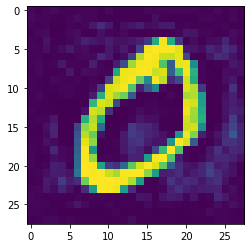

653
l2 dist: 1.5056313
target class:  2
pred of adv ex:  2


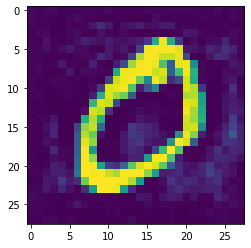

654
l2 dist: 1.4989378
target class:  2
pred of adv ex:  2


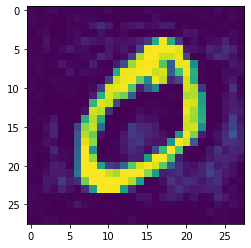

655
l2 dist: 1.4901054
target class:  2
pred of adv ex:  2


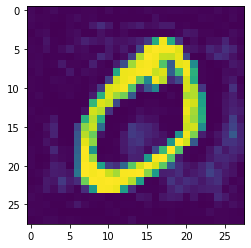

656
l2 dist: 1.4794306
target class:  2
pred of adv ex:  0


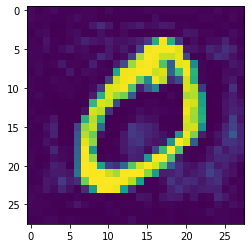

657
l2 dist: 1.4910936
target class:  2
pred of adv ex:  2


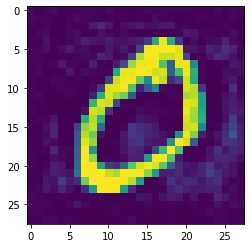

658
l2 dist: 1.498912
target class:  2
pred of adv ex:  2


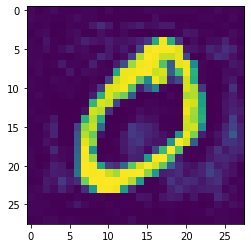

659
l2 dist: 1.5031532
target class:  2
pred of adv ex:  2


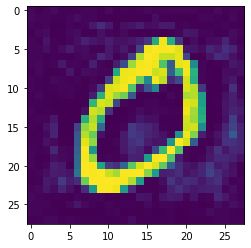

660
l2 dist: 1.5041054
target class:  2
pred of adv ex:  2


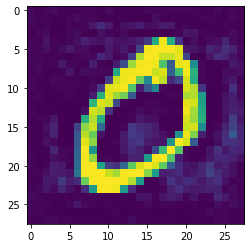

661
l2 dist: 1.5020707
target class:  2
pred of adv ex:  2


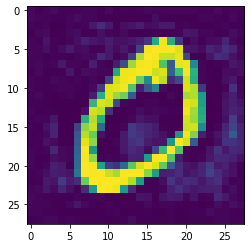

662
l2 dist: 1.4973581
target class:  2
pred of adv ex:  2


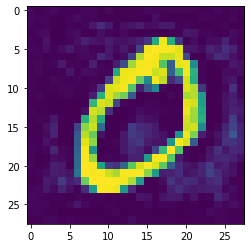

663
l2 dist: 1.4902773
target class:  2
pred of adv ex:  2


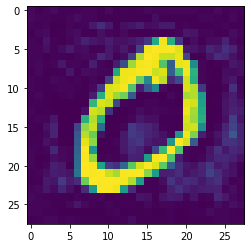

664
l2 dist: 1.4811337
target class:  2
pred of adv ex:  0


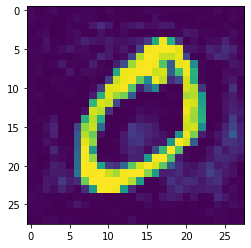

665
l2 dist: 1.4942517
target class:  2
pred of adv ex:  2


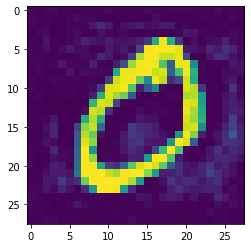

666
l2 dist: 1.5033586
target class:  2
pred of adv ex:  2


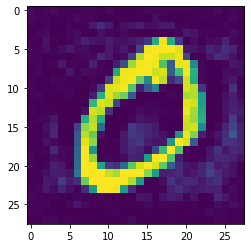

667
l2 dist: 1.5087237
target class:  2
pred of adv ex:  2


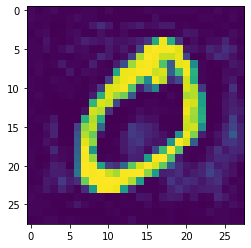

668
l2 dist: 1.5106424
target class:  2
pred of adv ex:  2


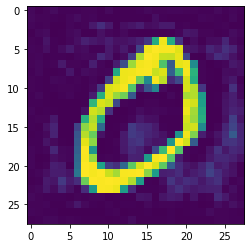

669
l2 dist: 1.5094261
target class:  2
pred of adv ex:  2


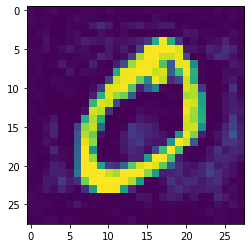

670
l2 dist: 1.5053926
target class:  2
pred of adv ex:  2


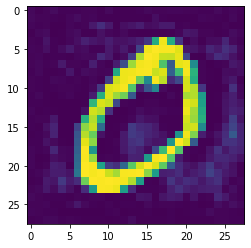

671
l2 dist: 1.4988593
target class:  2
pred of adv ex:  2


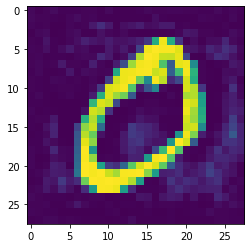

672
l2 dist: 1.4901377
target class:  2
pred of adv ex:  2


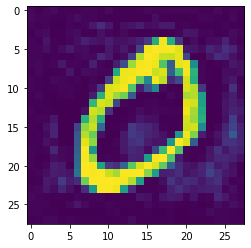

673
l2 dist: 1.4795287
target class:  2
pred of adv ex:  0


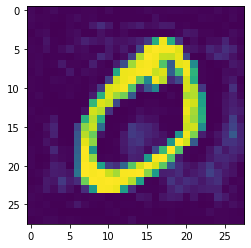

674
l2 dist: 1.4913886
target class:  2
pred of adv ex:  2


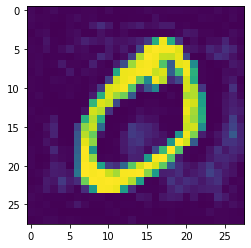

675
l2 dist: 1.4993587
target class:  2
pred of adv ex:  2


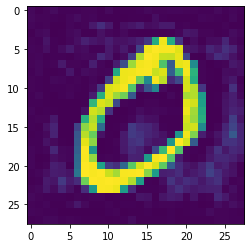

676
l2 dist: 1.5037091
target class:  2
pred of adv ex:  2


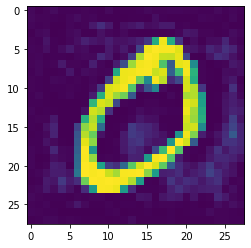

677
l2 dist: 1.5047301
target class:  2
pred of adv ex:  2


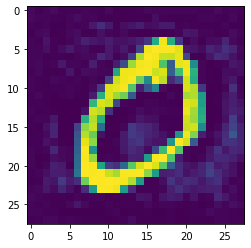

678
l2 dist: 1.5027252
target class:  2
pred of adv ex:  2


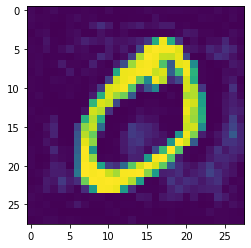

679
l2 dist: 1.4980056
target class:  2
pred of adv ex:  2


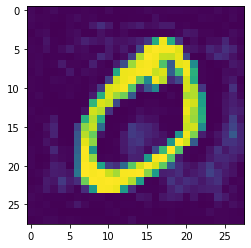

680
l2 dist: 1.4908845
target class:  2
pred of adv ex:  2


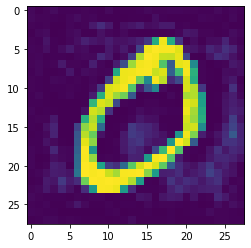

681
l2 dist: 1.4816712
target class:  2
pred of adv ex:  2


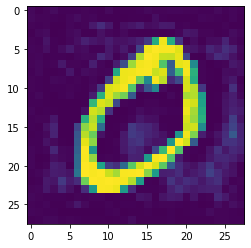

682
l2 dist: 1.470665
target class:  2
pred of adv ex:  0


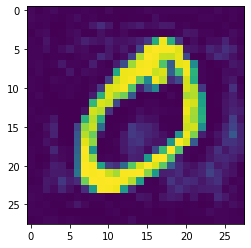

683
l2 dist: 1.4821293
target class:  2
pred of adv ex:  2


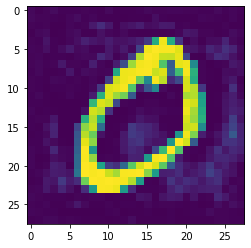

684
l2 dist: 1.4897697
target class:  2
pred of adv ex:  2


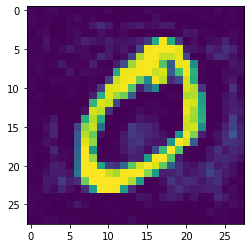

685
l2 dist: 1.493858
target class:  2
pred of adv ex:  2


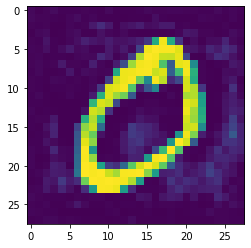

686
l2 dist: 1.4946868
target class:  2
pred of adv ex:  2


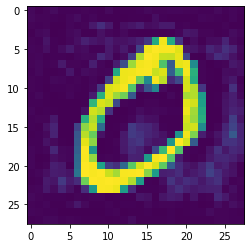

687
l2 dist: 1.4925607
target class:  2
pred of adv ex:  2


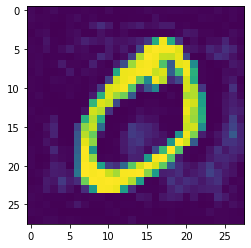

688
l2 dist: 1.4877884
target class:  2
pred of adv ex:  2


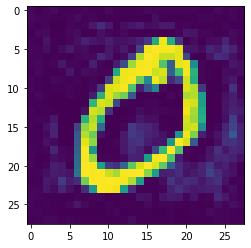

689
l2 dist: 1.480677
target class:  2
pred of adv ex:  2


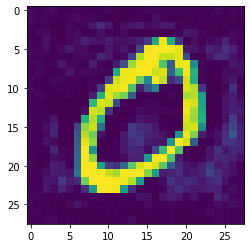

690
l2 dist: 1.4715264
target class:  2
pred of adv ex:  0


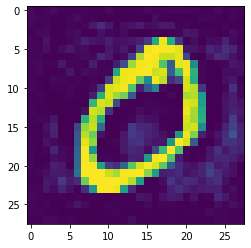

691
l2 dist: 1.4847074
target class:  2
pred of adv ex:  2


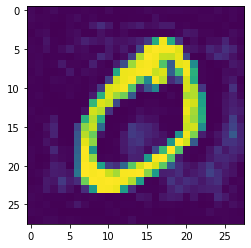

692
l2 dist: 1.4938976
target class:  2
pred of adv ex:  2


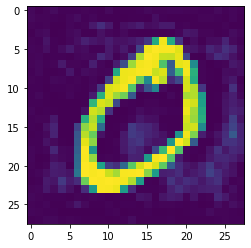

693
l2 dist: 1.4993566
target class:  2
pred of adv ex:  2


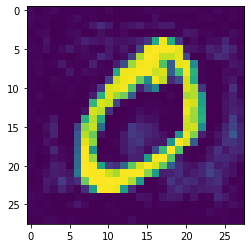

694
l2 dist: 1.5013708
target class:  2
pred of adv ex:  2


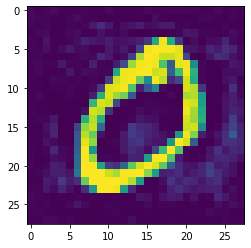

695
l2 dist: 1.5002444
target class:  2
pred of adv ex:  2


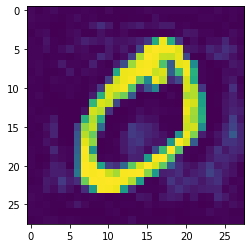

696
l2 dist: 1.4962927
target class:  2
pred of adv ex:  2


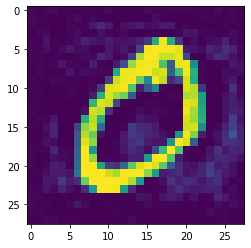

697
l2 dist: 1.4898356
target class:  2
pred of adv ex:  2


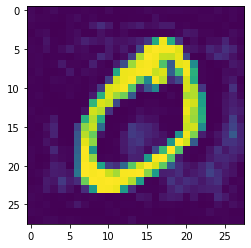

698
l2 dist: 1.4811893
target class:  2
pred of adv ex:  2


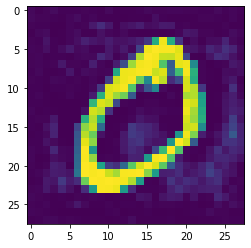

699
l2 dist: 1.4706604
target class:  2
pred of adv ex:  0


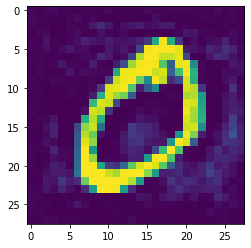

700
l2 dist: 1.4826361
target class:  2
pred of adv ex:  2


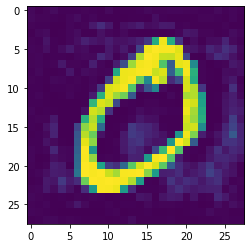

701
l2 dist: 1.4907135
target class:  2
pred of adv ex:  2


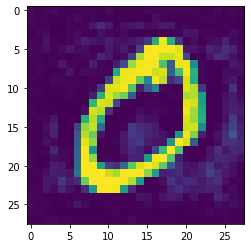

702
l2 dist: 1.4951668
target class:  2
pred of adv ex:  2


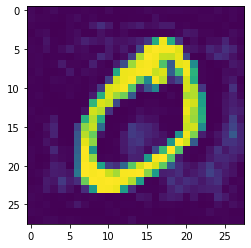

703
l2 dist: 1.4962916
target class:  2
pred of adv ex:  2


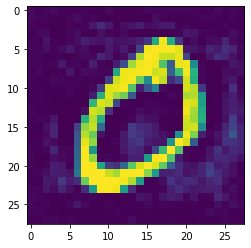

704
l2 dist: 1.4943957
target class:  2
pred of adv ex:  2


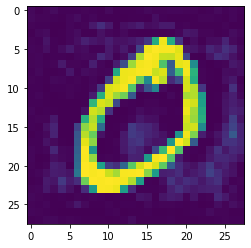

705
l2 dist: 1.489792
target class:  2
pred of adv ex:  2


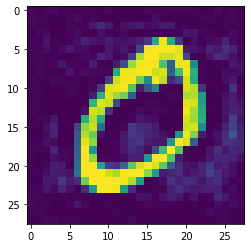

706
l2 dist: 1.4827913
target class:  2
pred of adv ex:  2


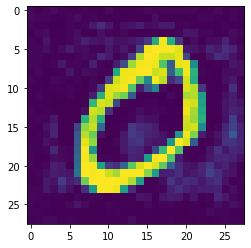

707
l2 dist: 1.4736989
target class:  2
pred of adv ex:  0


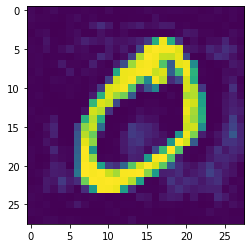

708
l2 dist: 1.4870871
target class:  2
pred of adv ex:  2


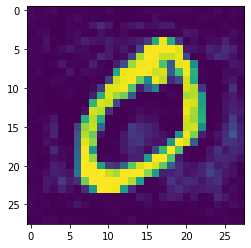

709
l2 dist: 1.4964293
target class:  2
pred of adv ex:  2


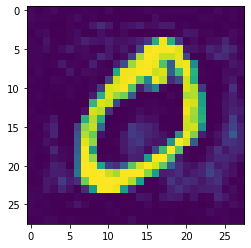

710
l2 dist: 1.5019903
target class:  2
pred of adv ex:  2


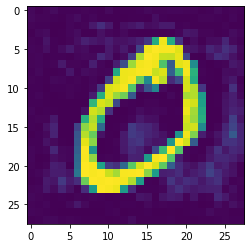

711
l2 dist: 1.5040594
target class:  2
pred of adv ex:  2


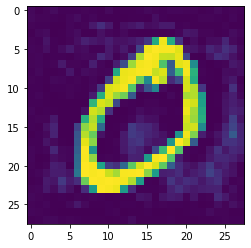

712
l2 dist: 1.5029436
target class:  2
pred of adv ex:  2


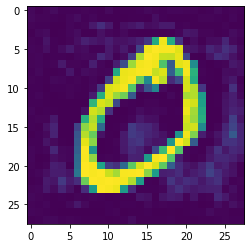

713
l2 dist: 1.4989612
target class:  2
pred of adv ex:  2


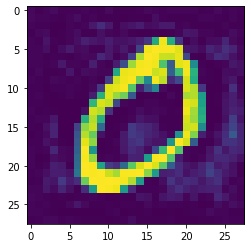

714
l2 dist: 1.4924346
target class:  2
pred of adv ex:  2


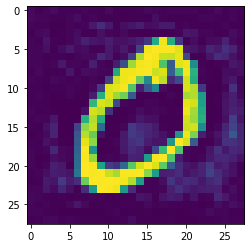

715
l2 dist: 1.4836853
target class:  2
pred of adv ex:  2


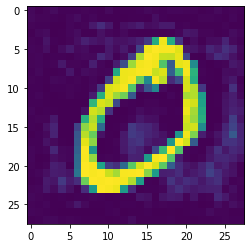

716
l2 dist: 1.4730252
target class:  2
pred of adv ex:  0


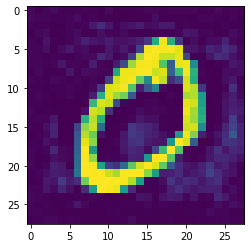

717
l2 dist: 1.4851321
target class:  2
pred of adv ex:  2


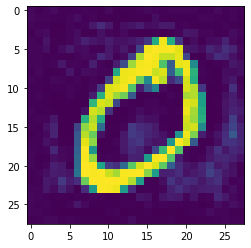

718
l2 dist: 1.4932808
target class:  2
pred of adv ex:  2


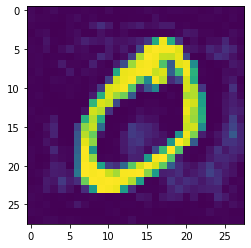

719
l2 dist: 1.4977523
target class:  2
pred of adv ex:  2


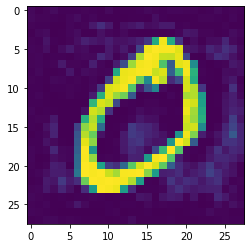

720
l2 dist: 1.4988515
target class:  2
pred of adv ex:  2


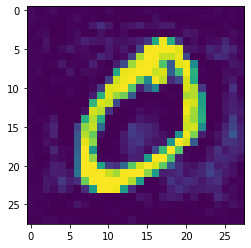

721
l2 dist: 1.4968942
target class:  2
pred of adv ex:  2


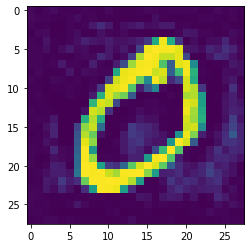

722
l2 dist: 1.4922019
target class:  2
pred of adv ex:  2


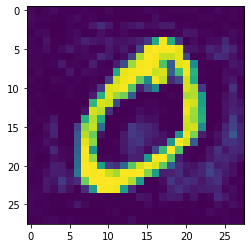

723
l2 dist: 1.4850931
target class:  2
pred of adv ex:  2


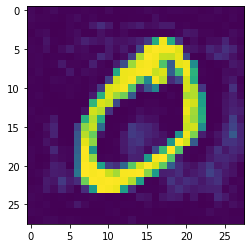

724
l2 dist: 1.475879
target class:  2
pred of adv ex:  2


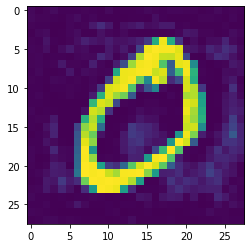

725
l2 dist: 1.464857
target class:  2
pred of adv ex:  0


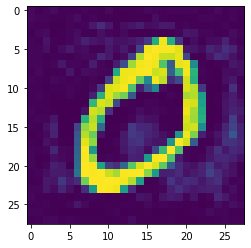

726
l2 dist: 1.4764565
target class:  2
pred of adv ex:  2


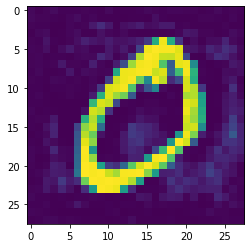

727
l2 dist: 1.4842154
target class:  2
pred of adv ex:  2


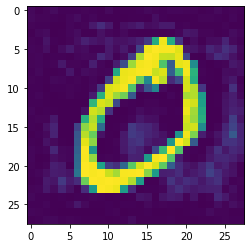

728
l2 dist: 1.4884003
target class:  2
pred of adv ex:  2


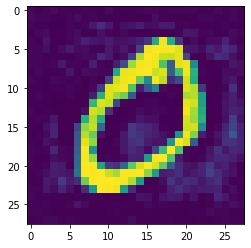

729
l2 dist: 1.4892979
target class:  2
pred of adv ex:  2


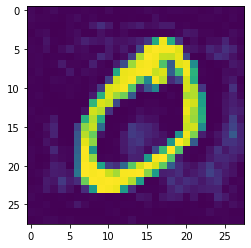

730
l2 dist: 1.4872079
target class:  2
pred of adv ex:  2


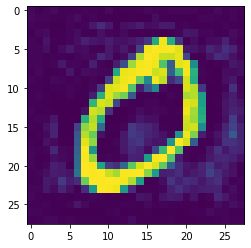

731
l2 dist: 1.4824376
target class:  2
pred of adv ex:  2


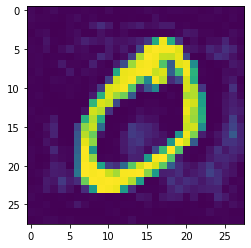

732
l2 dist: 1.4752976
target class:  2
pred of adv ex:  2


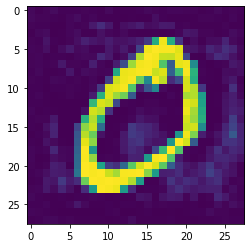

733
l2 dist: 1.4660937
target class:  2
pred of adv ex:  0


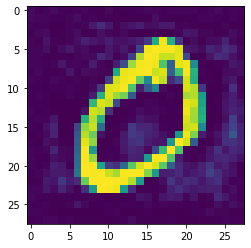

734
l2 dist: 1.4793987
target class:  2
pred of adv ex:  2


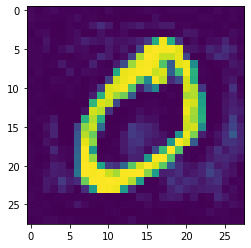

735
l2 dist: 1.4886738
target class:  2
pred of adv ex:  2


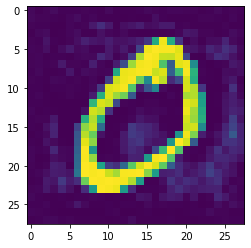

736
l2 dist: 1.4941876
target class:  2
pred of adv ex:  2


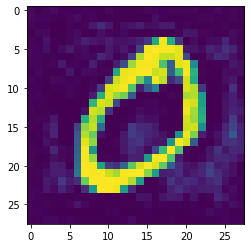

737
l2 dist: 1.4962339
target class:  2
pred of adv ex:  2


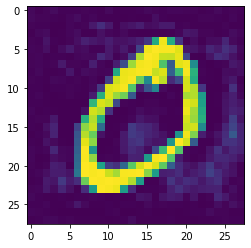

738
l2 dist: 1.4951236
target class:  2
pred of adv ex:  2


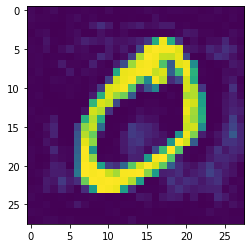

739
l2 dist: 1.4911736
target class:  2
pred of adv ex:  2


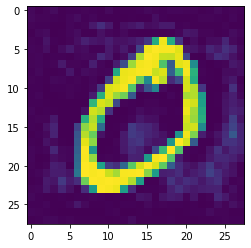

740
l2 dist: 1.4847026
target class:  2
pred of adv ex:  2


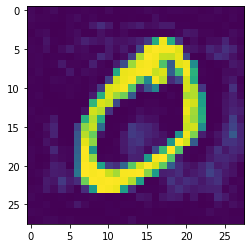

741
l2 dist: 1.4760234
target class:  2
pred of adv ex:  2


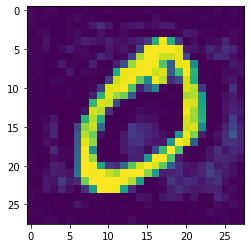

742
l2 dist: 1.4654385
target class:  2
pred of adv ex:  0


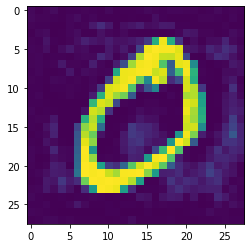

743
l2 dist: 1.4775814
target class:  2
pred of adv ex:  2


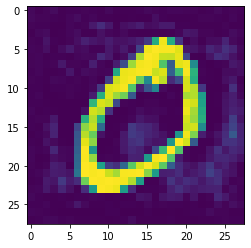

744
l2 dist: 1.4857987
target class:  2
pred of adv ex:  2


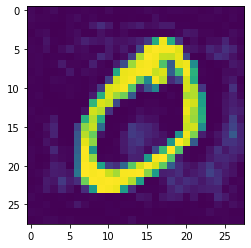

745
l2 dist: 1.4903605
target class:  2
pred of adv ex:  2


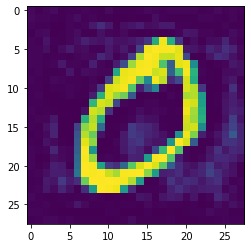

746
l2 dist: 1.4915565
target class:  2
pred of adv ex:  2


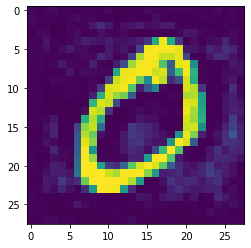

747
l2 dist: 1.4896909
target class:  2
pred of adv ex:  2


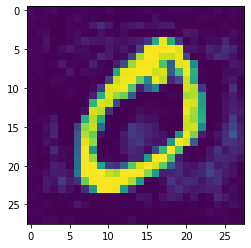

748
l2 dist: 1.4850765
target class:  2
pred of adv ex:  2


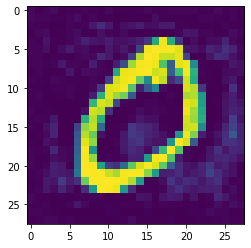

749
l2 dist: 1.4780295
target class:  2
pred of adv ex:  2


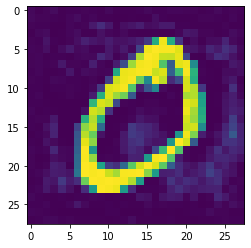

750
l2 dist: 1.4688625
target class:  2
pred of adv ex:  2


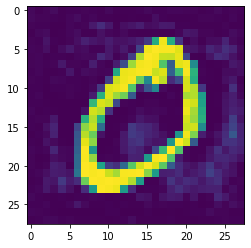

751
l2 dist: 1.4578793
target class:  2
pred of adv ex:  0


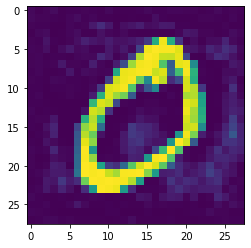

752
l2 dist: 1.4696442
target class:  2
pred of adv ex:  2


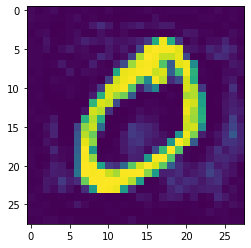

753
l2 dist: 1.4775385
target class:  2
pred of adv ex:  2


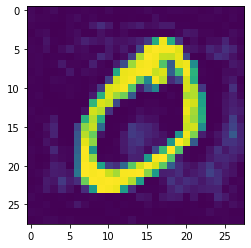

754
l2 dist: 1.4818358
target class:  2
pred of adv ex:  2


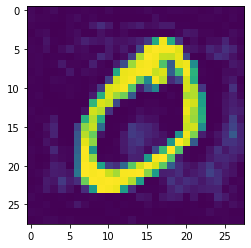

755
l2 dist: 1.4828316
target class:  2
pred of adv ex:  2


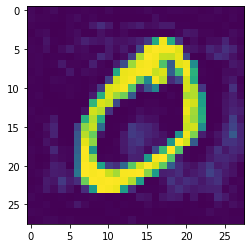

756
l2 dist: 1.4808329
target class:  2
pred of adv ex:  2


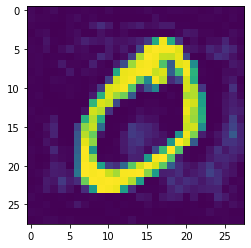

757
l2 dist: 1.4761522
target class:  2
pred of adv ex:  2


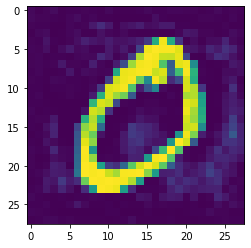

758
l2 dist: 1.4690998
target class:  2
pred of adv ex:  2


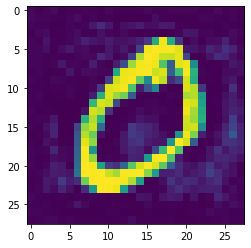

759
l2 dist: 1.4599794
target class:  2
pred of adv ex:  0


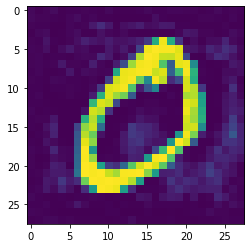

760
l2 dist: 1.4734774
target class:  2
pred of adv ex:  2


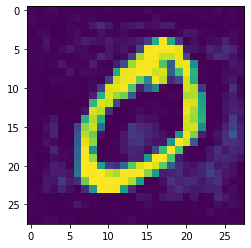

761
l2 dist: 1.4829322
target class:  2
pred of adv ex:  2


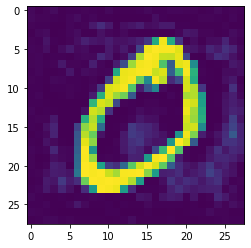

762
l2 dist: 1.488606
target class:  2
pred of adv ex:  2


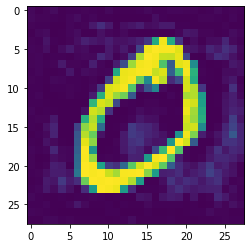

763
l2 dist: 1.4907867
target class:  2
pred of adv ex:  2


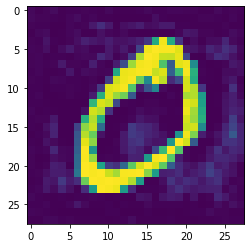

764
l2 dist: 1.4897815
target class:  2
pred of adv ex:  2


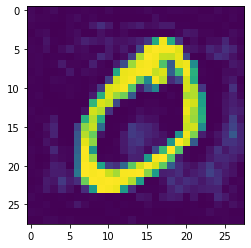

765
l2 dist: 1.48591
target class:  2
pred of adv ex:  2


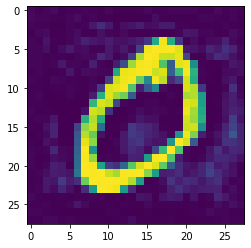

766
l2 dist: 1.4794961
target class:  2
pred of adv ex:  2


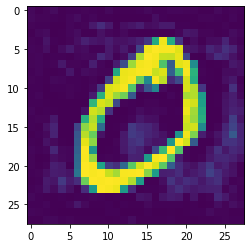

767
l2 dist: 1.4708613
target class:  2
pred of adv ex:  2


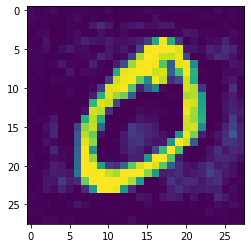

768
l2 dist: 1.460317
target class:  2
pred of adv ex:  0


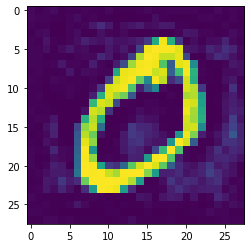

769
l2 dist: 1.4725789
target class:  2
pred of adv ex:  2


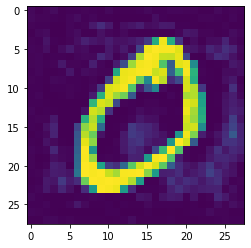

770
l2 dist: 1.4808888
target class:  2
pred of adv ex:  2


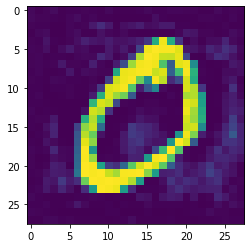

771
l2 dist: 1.4855239
target class:  2
pred of adv ex:  2


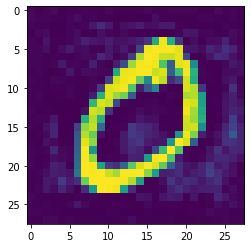

772
l2 dist: 1.4867831
target class:  2
pred of adv ex:  2


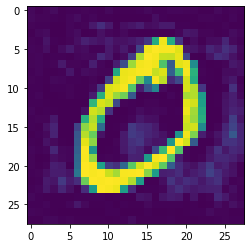

773
l2 dist: 1.4849777
target class:  2
pred of adv ex:  2


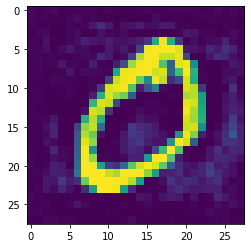

774
l2 dist: 1.480424
target class:  2
pred of adv ex:  2


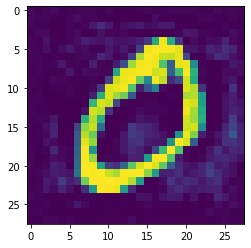

775
l2 dist: 1.4734384
target class:  2
pred of adv ex:  2


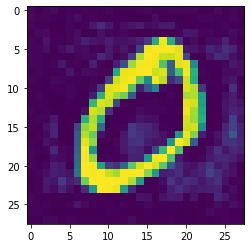

776
l2 dist: 1.4643294
target class:  2
pred of adv ex:  0


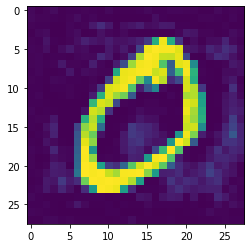

777
l2 dist: 1.478009
target class:  2
pred of adv ex:  2


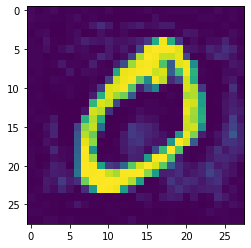

778
l2 dist: 1.487587
target class:  2
pred of adv ex:  2


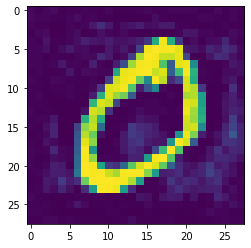

779
l2 dist: 1.4933301
target class:  2
pred of adv ex:  2


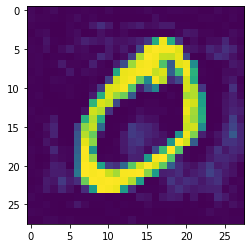

780
l2 dist: 1.4955304
target class:  2
pred of adv ex:  2


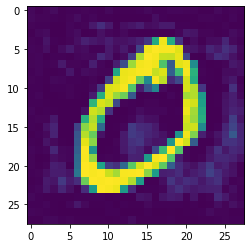

781
l2 dist: 1.4944977
target class:  2
pred of adv ex:  2


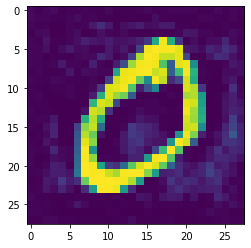

782
l2 dist: 1.4905545
target class:  2
pred of adv ex:  2


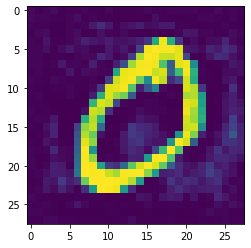

783
l2 dist: 1.4840285
target class:  2
pred of adv ex:  2


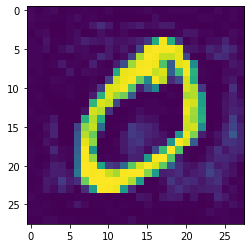

784
l2 dist: 1.4752463
target class:  2
pred of adv ex:  2


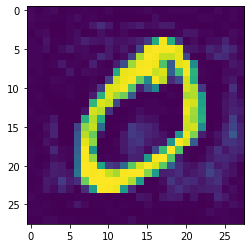

785
l2 dist: 1.4645258
target class:  2
pred of adv ex:  2


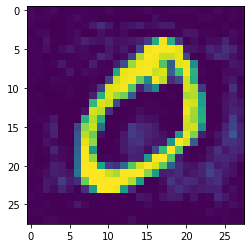

786
l2 dist: 1.4521692
target class:  2
pred of adv ex:  0


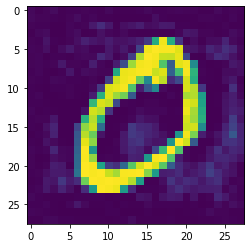

787
l2 dist: 1.462812
target class:  2
pred of adv ex:  0


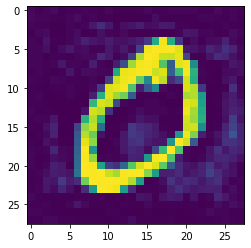

788
l2 dist: 1.4946089
target class:  2
pred of adv ex:  2


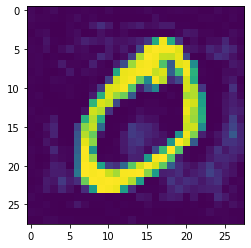

789
l2 dist: 1.5209452
target class:  2
pred of adv ex:  2


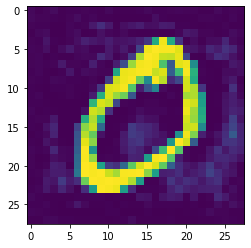

790
l2 dist: 1.5418935
target class:  2
pred of adv ex:  2


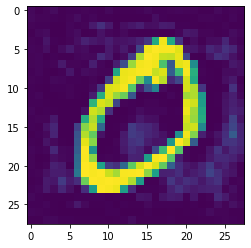

791
l2 dist: 1.5576402
target class:  2
pred of adv ex:  2


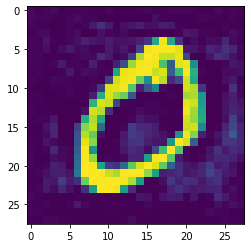

792
l2 dist: 1.5684601
target class:  2
pred of adv ex:  2


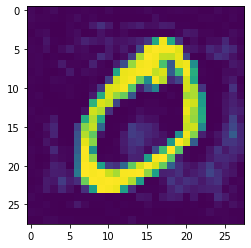

793
l2 dist: 1.5746956
target class:  2
pred of adv ex:  2


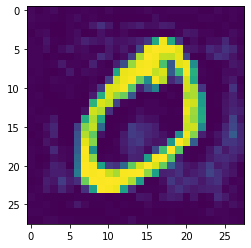

794
l2 dist: 1.5767344
target class:  2
pred of adv ex:  2


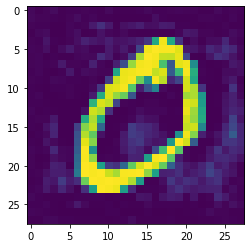

795
l2 dist: 1.5749917
target class:  2
pred of adv ex:  2


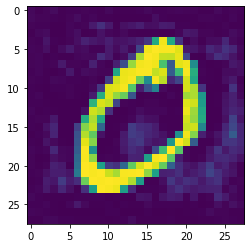

796
l2 dist: 1.5698931
target class:  2
pred of adv ex:  2


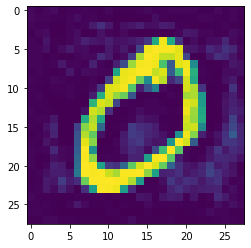

797
l2 dist: 1.5618593
target class:  2
pred of adv ex:  2


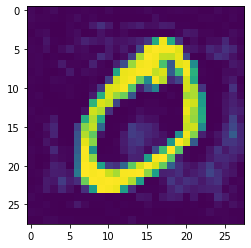

798
l2 dist: 1.5512962
target class:  2
pred of adv ex:  2


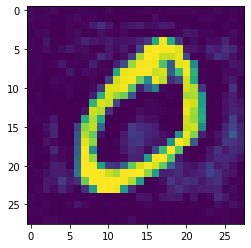

799
l2 dist: 1.5385854
target class:  2
pred of adv ex:  2


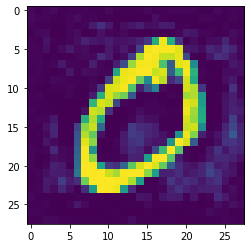

800
l2 dist: 1.5240796
target class:  2
pred of adv ex:  2


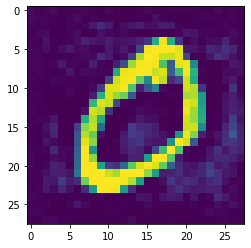

801
l2 dist: 1.5080993
target class:  2
pred of adv ex:  2


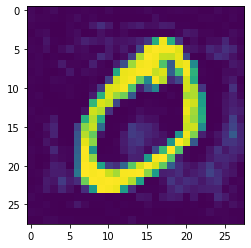

802
l2 dist: 1.4909335
target class:  2
pred of adv ex:  2


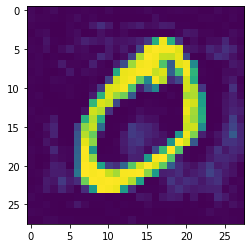

803
l2 dist: 1.4728395
target class:  2
pred of adv ex:  2


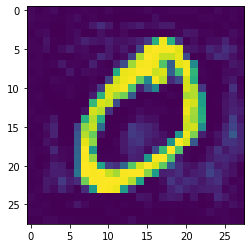

804
l2 dist: 1.4540441
target class:  2
pred of adv ex:  0


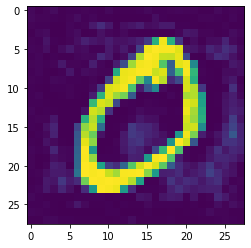

805
l2 dist: 1.458625
target class:  2
pred of adv ex:  0


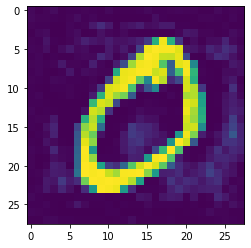

806
l2 dist: 1.4844613
target class:  2
pred of adv ex:  2


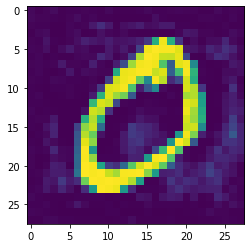

807
l2 dist: 1.5054731
target class:  2
pred of adv ex:  2


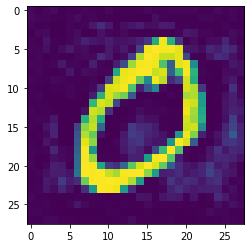

808
l2 dist: 1.5217471
target class:  2
pred of adv ex:  2


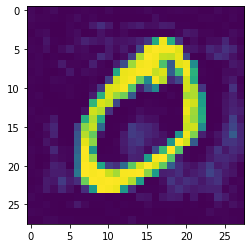

809
l2 dist: 1.5334524
target class:  2
pred of adv ex:  2


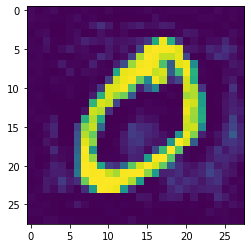

810
l2 dist: 1.5408342
target class:  2
pred of adv ex:  2


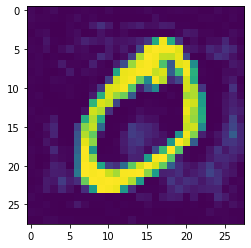

811
l2 dist: 1.5442011
target class:  2
pred of adv ex:  2


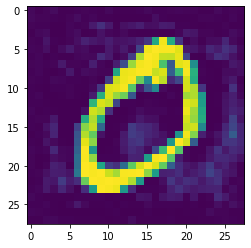

812
l2 dist: 1.5439073
target class:  2
pred of adv ex:  2


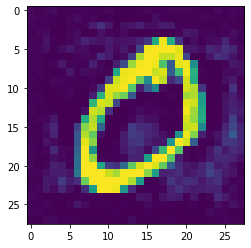

813
l2 dist: 1.5403318
target class:  2
pred of adv ex:  2


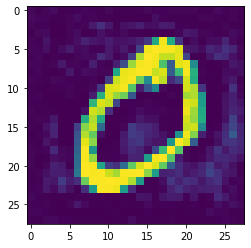

814
l2 dist: 1.5338595
target class:  2
pred of adv ex:  2


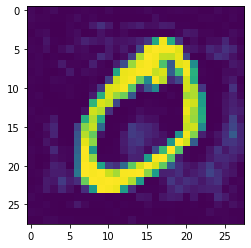

815
l2 dist: 1.5248654
target class:  2
pred of adv ex:  2


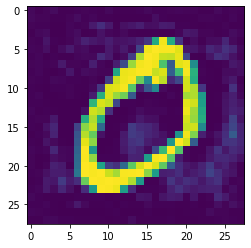

816
l2 dist: 1.5137032
target class:  2
pred of adv ex:  2


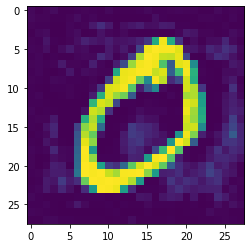

817
l2 dist: 1.5007006
target class:  2
pred of adv ex:  2


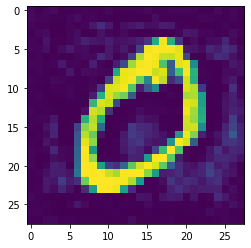

818
l2 dist: 1.4861574
target class:  2
pred of adv ex:  2


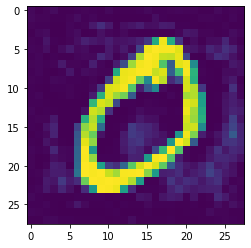

819
l2 dist: 1.4703476
target class:  2
pred of adv ex:  2


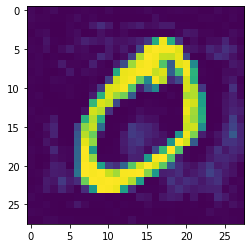

820
l2 dist: 1.4535204
target class:  2
pred of adv ex:  0


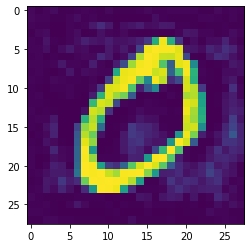

821
l2 dist: 1.4599843
target class:  2
pred of adv ex:  2


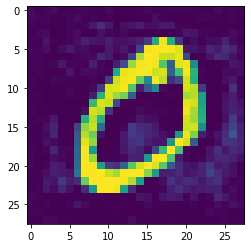

822
l2 dist: 1.4631081
target class:  2
pred of adv ex:  2


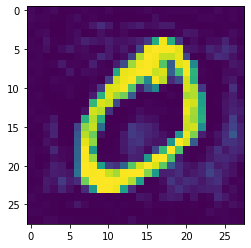

823
l2 dist: 1.4631717
target class:  2
pred of adv ex:  2


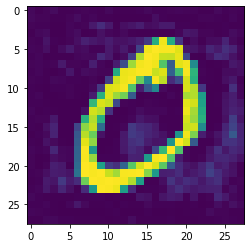

824
l2 dist: 1.4604663
target class:  2
pred of adv ex:  2


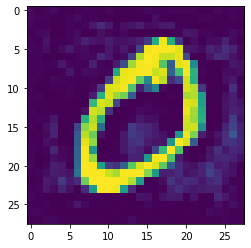

825
l2 dist: 1.4552842
target class:  2
pred of adv ex:  0


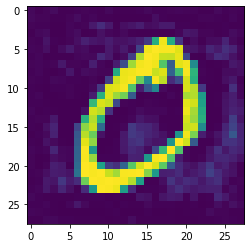

826
l2 dist: 1.472442
target class:  2
pred of adv ex:  2


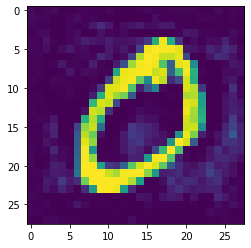

827
l2 dist: 1.4853228
target class:  2
pred of adv ex:  2


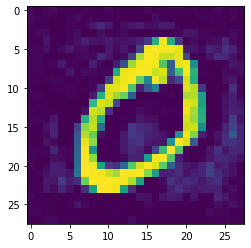

828
l2 dist: 1.4941312
target class:  2
pred of adv ex:  2


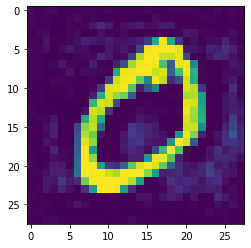

829
l2 dist: 1.4991193
target class:  2
pred of adv ex:  2


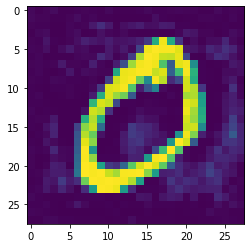

830
l2 dist: 1.5005738
target class:  2
pred of adv ex:  2


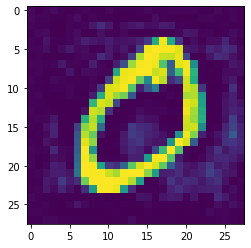

831
l2 dist: 1.4988061
target class:  2
pred of adv ex:  2


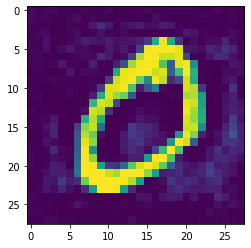

832
l2 dist: 1.4941419
target class:  2
pred of adv ex:  2


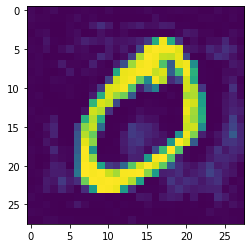

833
l2 dist: 1.486911
target class:  2
pred of adv ex:  2


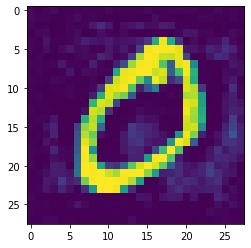

834
l2 dist: 1.4774419
target class:  2
pred of adv ex:  2


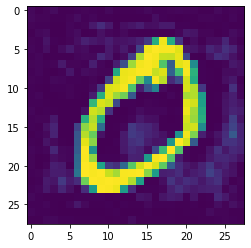

835
l2 dist: 1.4660512
target class:  2
pred of adv ex:  2


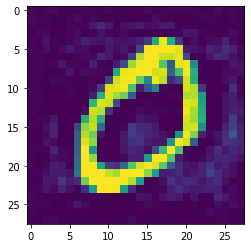

836
l2 dist: 1.4530406
target class:  2
pred of adv ex:  0


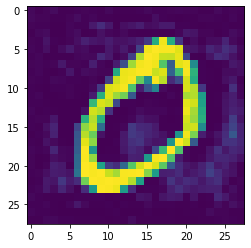

837
l2 dist: 1.4634546
target class:  2
pred of adv ex:  2


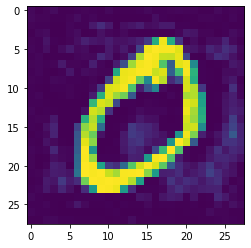

838
l2 dist: 1.4701186
target class:  2
pred of adv ex:  2


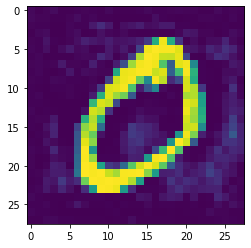

839
l2 dist: 1.473297
target class:  2
pred of adv ex:  2


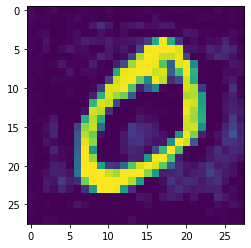

840
l2 dist: 1.4732748
target class:  2
pred of adv ex:  2


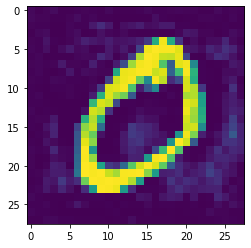

841
l2 dist: 1.4703517
target class:  2
pred of adv ex:  2


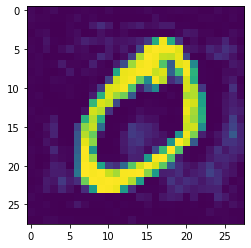

842
l2 dist: 1.4648356
target class:  2
pred of adv ex:  2


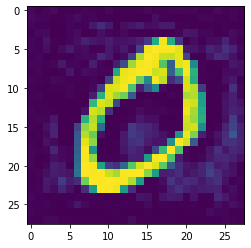

843
l2 dist: 1.4570351
target class:  2
pred of adv ex:  2


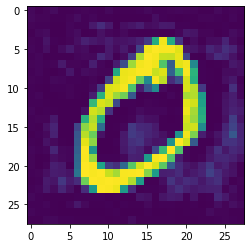

844
l2 dist: 1.4472517
target class:  2
pred of adv ex:  0


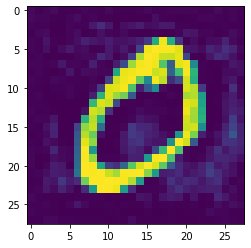

845
l2 dist: 1.4603527
target class:  2
pred of adv ex:  2


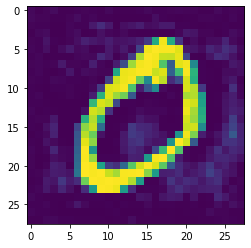

846
l2 dist: 1.4694471
target class:  2
pred of adv ex:  2


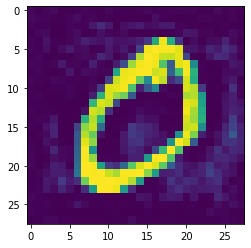

847
l2 dist: 1.4748008
target class:  2
pred of adv ex:  2


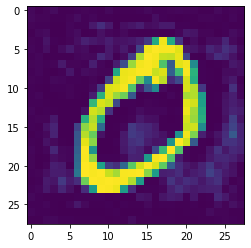

848
l2 dist: 1.4767054
target class:  2
pred of adv ex:  2


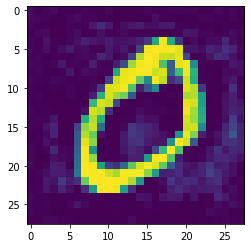

849
l2 dist: 1.4754679
target class:  2
pred of adv ex:  2


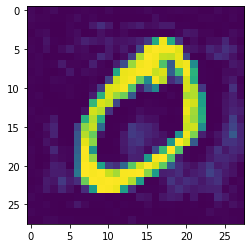

850
l2 dist: 1.4714047
target class:  2
pred of adv ex:  2


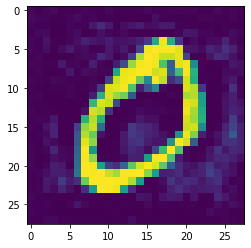

851
l2 dist: 1.4648348
target class:  2
pred of adv ex:  2


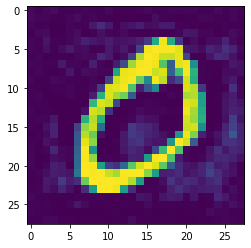

852
l2 dist: 1.4560729
target class:  2
pred of adv ex:  2


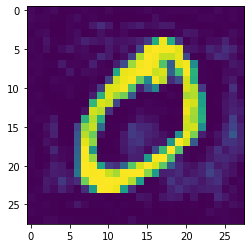

853
l2 dist: 1.4454248
target class:  2
pred of adv ex:  0


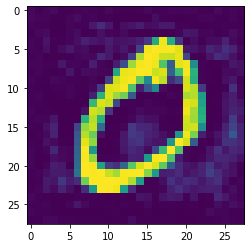

854
l2 dist: 1.4578258
target class:  2
pred of adv ex:  2


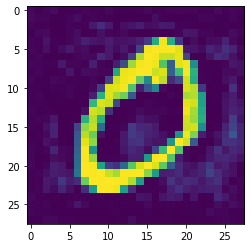

855
l2 dist: 1.4662945
target class:  2
pred of adv ex:  2


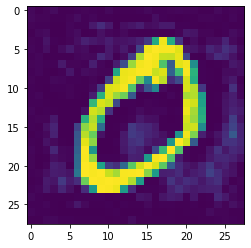

856
l2 dist: 1.4710865
target class:  2
pred of adv ex:  2


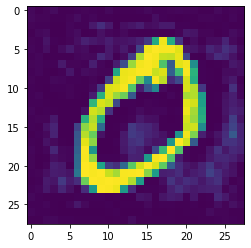

857
l2 dist: 1.4724828
target class:  2
pred of adv ex:  2


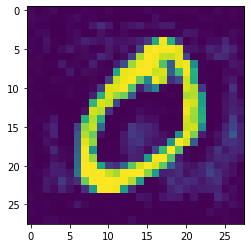

858
l2 dist: 1.4707845
target class:  2
pred of adv ex:  2


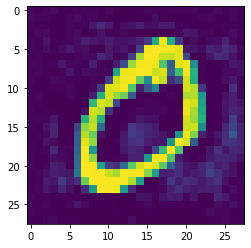

859
l2 dist: 1.4663079
target class:  2
pred of adv ex:  2


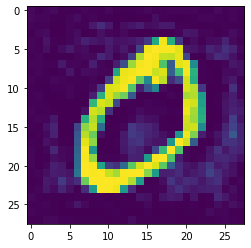

860
l2 dist: 1.4593759
target class:  2
pred of adv ex:  2


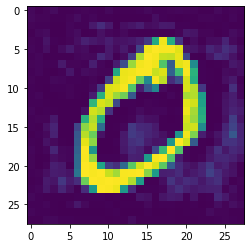

861
l2 dist: 1.4503098
target class:  2
pred of adv ex:  0


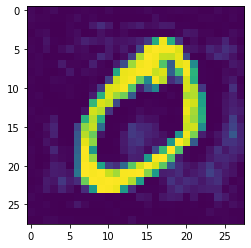

862
l2 dist: 1.4643126
target class:  2
pred of adv ex:  2


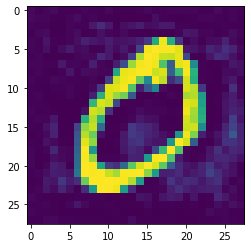

863
l2 dist: 1.4741654
target class:  2
pred of adv ex:  2


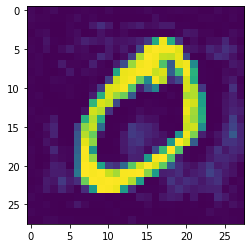

864
l2 dist: 1.480145
target class:  2
pred of adv ex:  2


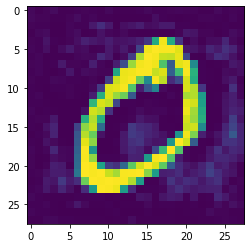

865
l2 dist: 1.4825554
target class:  2
pred of adv ex:  2


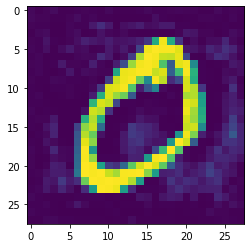

866
l2 dist: 1.4817171
target class:  2
pred of adv ex:  2


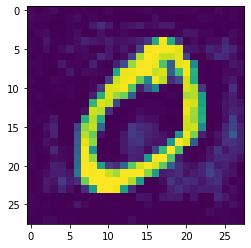

867
l2 dist: 1.4779586
target class:  2
pred of adv ex:  2


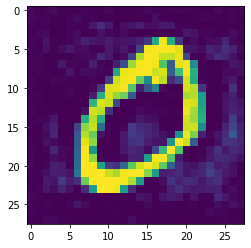

868
l2 dist: 1.4716085
target class:  2
pred of adv ex:  2


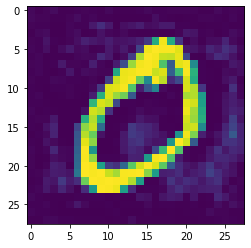

869
l2 dist: 1.46299
target class:  2
pred of adv ex:  2


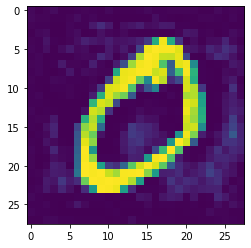

870
l2 dist: 1.4524155
target class:  2
pred of adv ex:  2


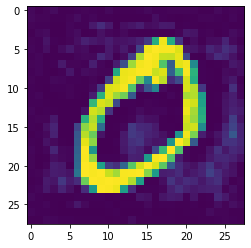

871
l2 dist: 1.4401819
target class:  2
pred of adv ex:  0


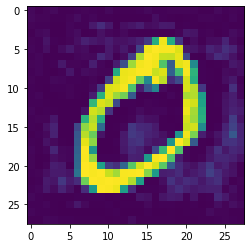

872
l2 dist: 1.4510777
target class:  2
pred of adv ex:  0


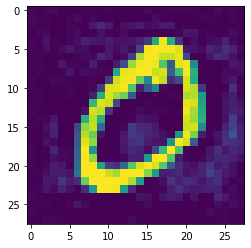

873
l2 dist: 1.4833552
target class:  2
pred of adv ex:  2


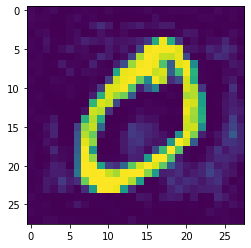

874
l2 dist: 1.5102015
target class:  2
pred of adv ex:  2


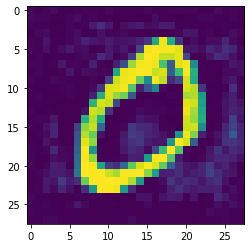

875
l2 dist: 1.5316312
target class:  2
pred of adv ex:  2


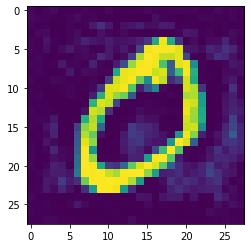

876
l2 dist: 1.547782
target class:  2
pred of adv ex:  2


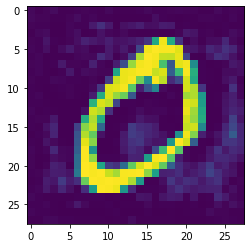

877
l2 dist: 1.5589001
target class:  2
pred of adv ex:  2


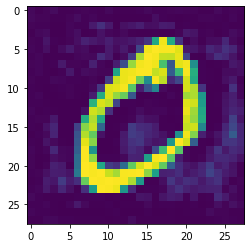

878
l2 dist: 1.5653253
target class:  2
pred of adv ex:  2


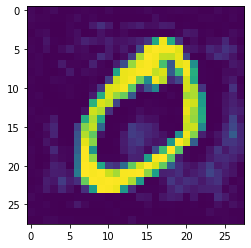

879
l2 dist: 1.567464
target class:  2
pred of adv ex:  2


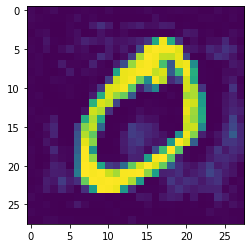

880
l2 dist: 1.5657619
target class:  2
pred of adv ex:  2


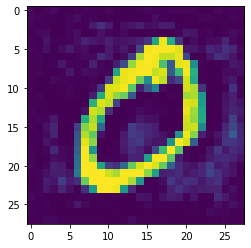

881
l2 dist: 1.5606773
target class:  2
pred of adv ex:  2


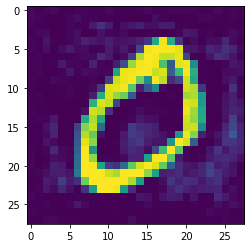

882
l2 dist: 1.5526567
target class:  2
pred of adv ex:  2


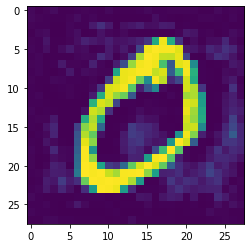

883
l2 dist: 1.542119
target class:  2
pred of adv ex:  2


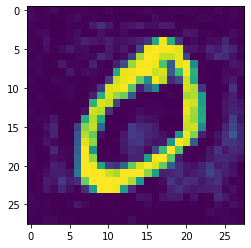

884
l2 dist: 1.529447
target class:  2
pred of adv ex:  2


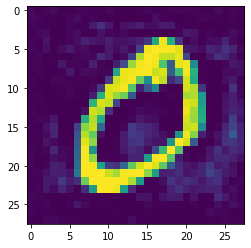

885
l2 dist: 1.5149851
target class:  2
pred of adv ex:  2


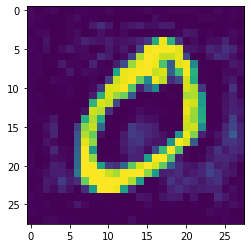

886
l2 dist: 1.499042
target class:  2
pred of adv ex:  2


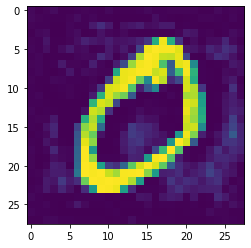

887
l2 dist: 1.4818952
target class:  2
pred of adv ex:  2


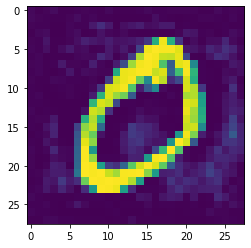

888
l2 dist: 1.4637953
target class:  2
pred of adv ex:  2


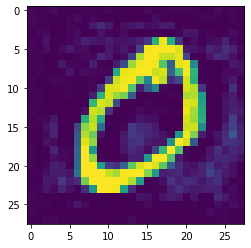

889
l2 dist: 1.4449695
target class:  2
pred of adv ex:  0


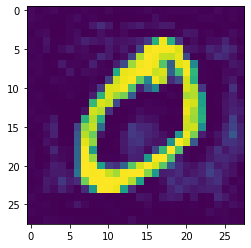

890
l2 dist: 1.449693
target class:  2
pred of adv ex:  0


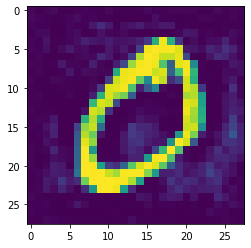

891
l2 dist: 1.4758123
target class:  2
pred of adv ex:  2


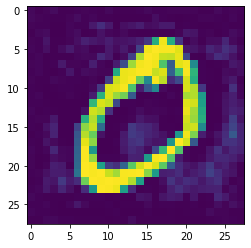

892
l2 dist: 1.4970491
target class:  2
pred of adv ex:  2


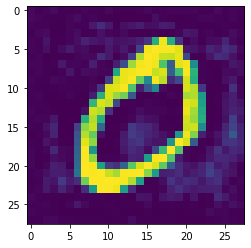

893
l2 dist: 1.5135318
target class:  2
pred of adv ex:  2


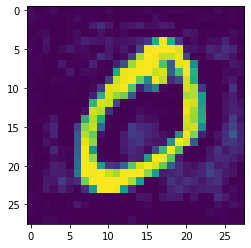

894
l2 dist: 1.5254586
target class:  2
pred of adv ex:  2


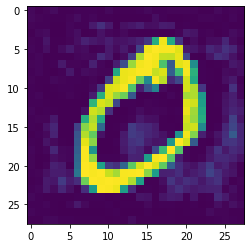

895
l2 dist: 1.5330837
target class:  2
pred of adv ex:  2


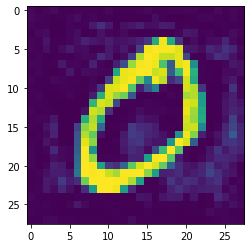

896
l2 dist: 1.5367022
target class:  2
pred of adv ex:  2


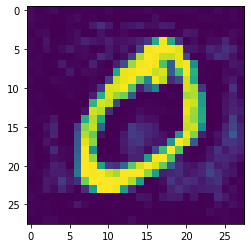

897
l2 dist: 1.536641
target class:  2
pred of adv ex:  2


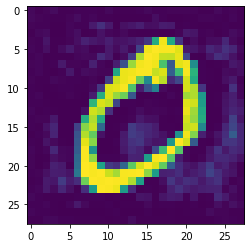

898
l2 dist: 1.5332481
target class:  2
pred of adv ex:  2


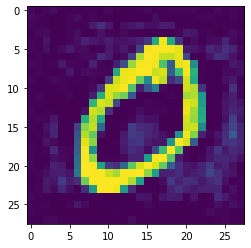

899
l2 dist: 1.5268828
target class:  2
pred of adv ex:  2


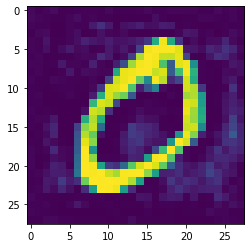

900
l2 dist: 1.5179065
target class:  2
pred of adv ex:  2


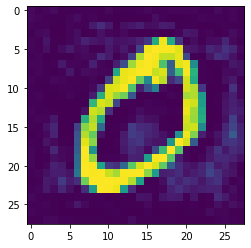

901
l2 dist: 1.5066752
target class:  2
pred of adv ex:  2


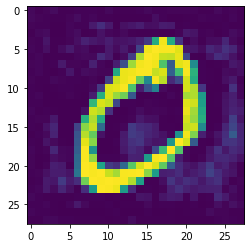

902
l2 dist: 1.4935298
target class:  2
pred of adv ex:  2


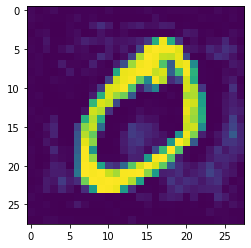

903
l2 dist: 1.4787908
target class:  2
pred of adv ex:  2


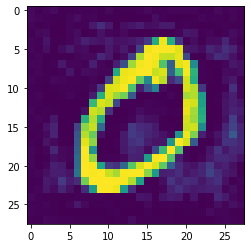

904
l2 dist: 1.4627542
target class:  2
pred of adv ex:  2


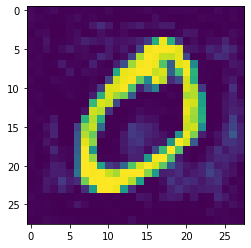

905
l2 dist: 1.4456879
target class:  2
pred of adv ex:  0


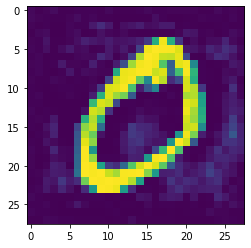

906
l2 dist: 1.452312
target class:  2
pred of adv ex:  2


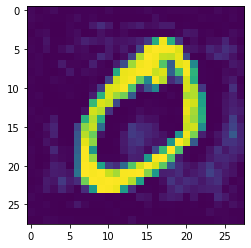

907
l2 dist: 1.4555619
target class:  2
pred of adv ex:  2


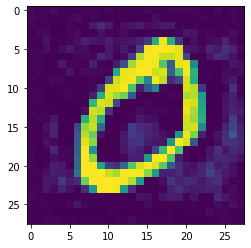

908
l2 dist: 1.455714
target class:  2
pred of adv ex:  2


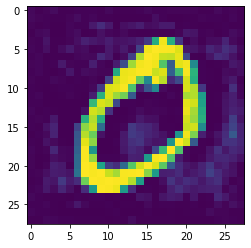

909
l2 dist: 1.4530532
target class:  2
pred of adv ex:  2


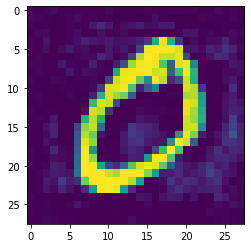

910
l2 dist: 1.4478694
target class:  2
pred of adv ex:  2


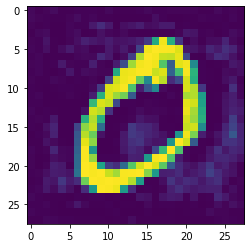

911
l2 dist: 1.440452
target class:  2
pred of adv ex:  0


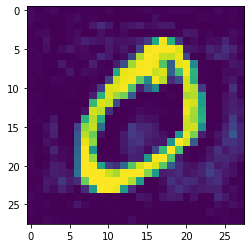

912
l2 dist: 1.4557978
target class:  2
pred of adv ex:  2


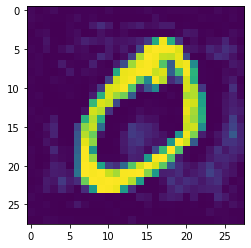

913
l2 dist: 1.4669869
target class:  2
pred of adv ex:  2


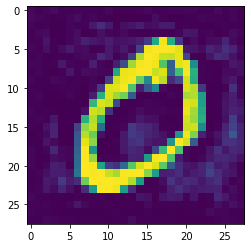

914
l2 dist: 1.4742509
target class:  2
pred of adv ex:  2


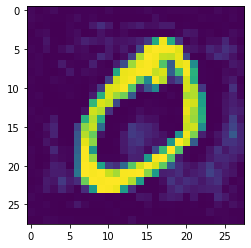

915
l2 dist: 1.4778606
target class:  2
pred of adv ex:  2


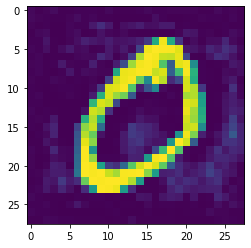

916
l2 dist: 1.4781134
target class:  2
pred of adv ex:  2


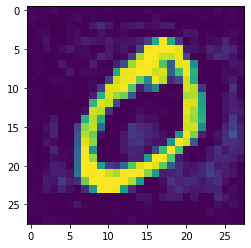

917
l2 dist: 1.475326
target class:  2
pred of adv ex:  2


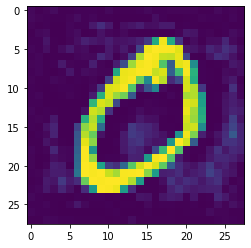

918
l2 dist: 1.469822
target class:  2
pred of adv ex:  2


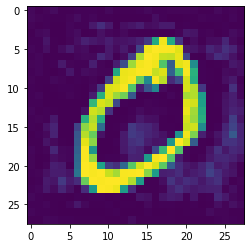

919
l2 dist: 1.4619272
target class:  2
pred of adv ex:  2


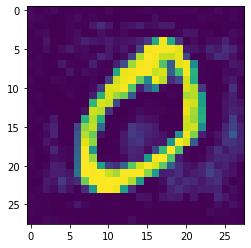

920
l2 dist: 1.4519595
target class:  2
pred of adv ex:  2


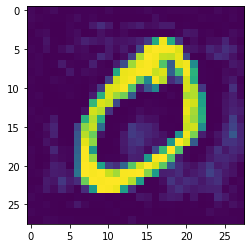

921
l2 dist: 1.4402242
target class:  2
pred of adv ex:  0


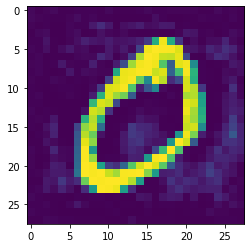

922
l2 dist: 1.4520352
target class:  2
pred of adv ex:  2


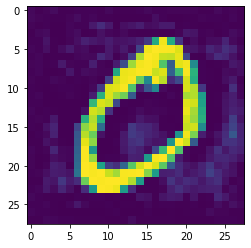

923
l2 dist: 1.4599752
target class:  2
pred of adv ex:  2


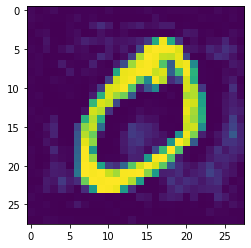

924
l2 dist: 1.4642988
target class:  2
pred of adv ex:  2


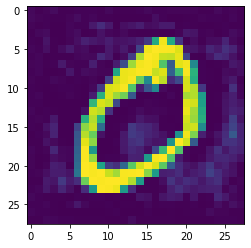

925
l2 dist: 1.4652832
target class:  2
pred of adv ex:  2


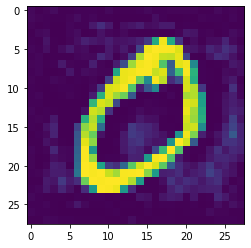

926
l2 dist: 1.4632251
target class:  2
pred of adv ex:  2


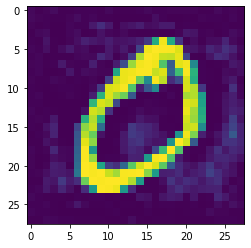

927
l2 dist: 1.458435
target class:  2
pred of adv ex:  2


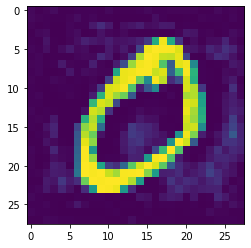

928
l2 dist: 1.45123
target class:  2
pred of adv ex:  2


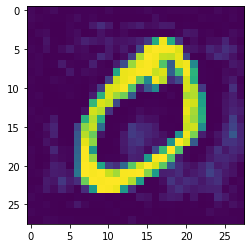

929
l2 dist: 1.4419258
target class:  2
pred of adv ex:  0


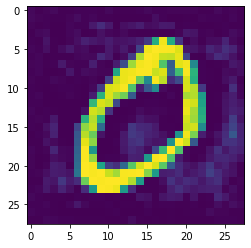

930
l2 dist: 1.4557557
target class:  2
pred of adv ex:  2


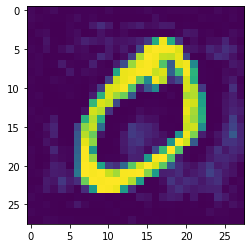

931
l2 dist: 1.4654776
target class:  2
pred of adv ex:  2


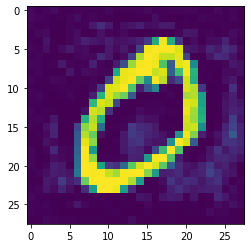

932
l2 dist: 1.4713635
target class:  2
pred of adv ex:  2


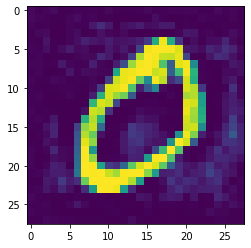

933
l2 dist: 1.4737104
target class:  2
pred of adv ex:  2


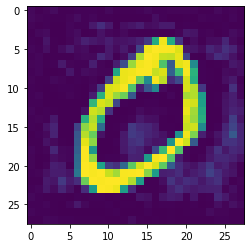

934
l2 dist: 1.4728299
target class:  2
pred of adv ex:  2


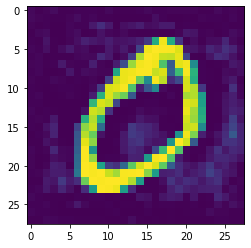

935
l2 dist: 1.4690425
target class:  2
pred of adv ex:  2


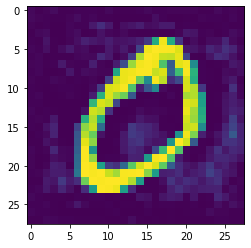

936
l2 dist: 1.4626702
target class:  2
pred of adv ex:  2


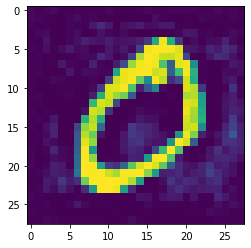

937
l2 dist: 1.4540335
target class:  2
pred of adv ex:  2


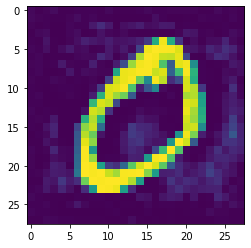

938
l2 dist: 1.4434428
target class:  2
pred of adv ex:  0


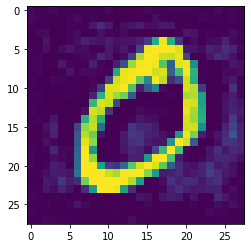

939
l2 dist: 1.4562416
target class:  2
pred of adv ex:  2


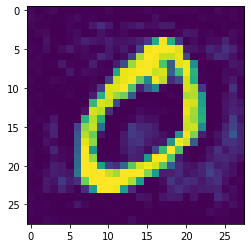

940
l2 dist: 1.4650085
target class:  2
pred of adv ex:  2


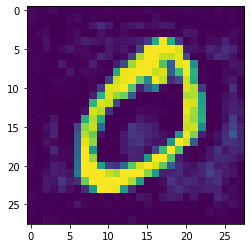

941
l2 dist: 1.4700109
target class:  2
pred of adv ex:  2


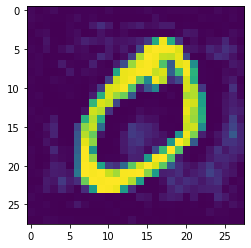

942
l2 dist: 1.4715407
target class:  2
pred of adv ex:  2


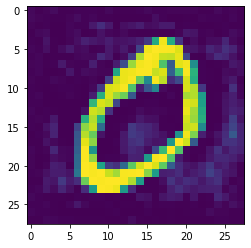

943
l2 dist: 1.4699084
target class:  2
pred of adv ex:  2


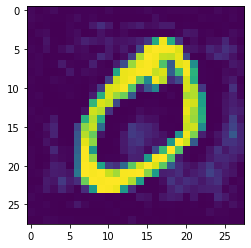

944
l2 dist: 1.4654373
target class:  2
pred of adv ex:  2


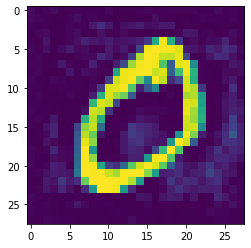

945
l2 dist: 1.4584564
target class:  2
pred of adv ex:  2


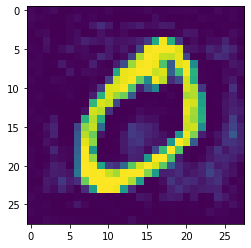

946
l2 dist: 1.4492924
target class:  2
pred of adv ex:  2


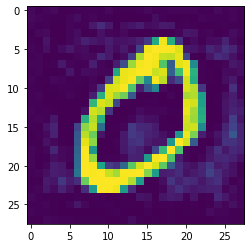

947
l2 dist: 1.4382616
target class:  2
pred of adv ex:  0


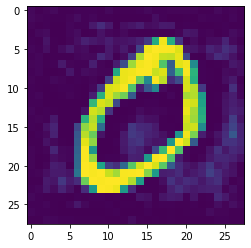

948
l2 dist: 1.4505644
target class:  2
pred of adv ex:  2


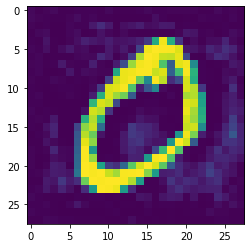

949
l2 dist: 1.458904
target class:  2
pred of adv ex:  2


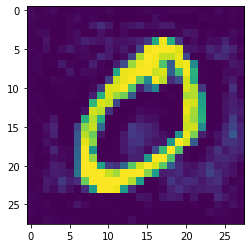

950
l2 dist: 1.4635556
target class:  2
pred of adv ex:  2


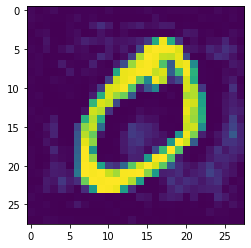

951
l2 dist: 1.4648148
target class:  2
pred of adv ex:  2


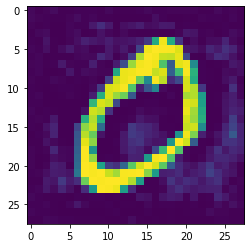

952
l2 dist: 1.46299
target class:  2
pred of adv ex:  2


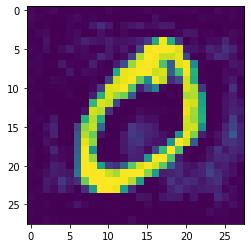

953
l2 dist: 1.4583968
target class:  2
pred of adv ex:  2


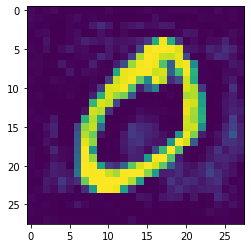

954
l2 dist: 1.4513508
target class:  2
pred of adv ex:  2


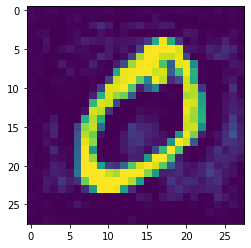

955
l2 dist: 1.4421636
target class:  2
pred of adv ex:  0


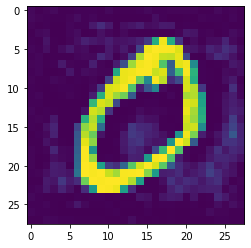

956
l2 dist: 1.4562519
target class:  2
pred of adv ex:  2


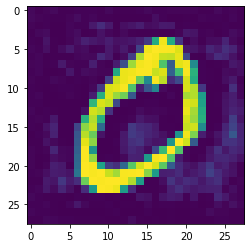

957
l2 dist: 1.4661949
target class:  2
pred of adv ex:  2


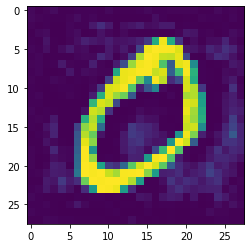

958
l2 dist: 1.4722542
target class:  2
pred of adv ex:  2


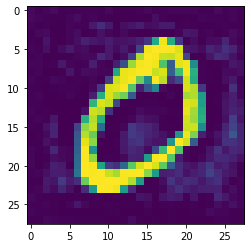

959
l2 dist: 1.4747165
target class:  2
pred of adv ex:  2


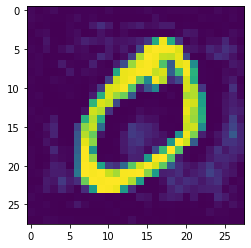

960
l2 dist: 1.473888
target class:  2
pred of adv ex:  2


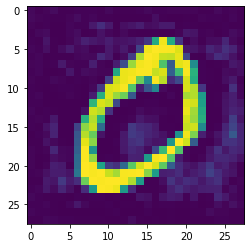

961
l2 dist: 1.4700907
target class:  2
pred of adv ex:  2


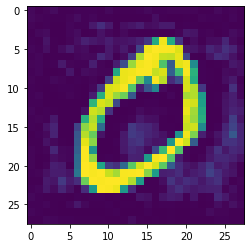

962
l2 dist: 1.4636557
target class:  2
pred of adv ex:  2


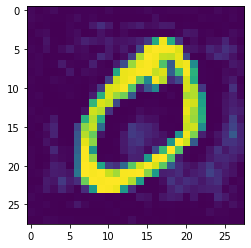

963
l2 dist: 1.4549166
target class:  2
pred of adv ex:  2


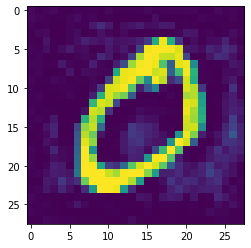

964
l2 dist: 1.4441996
target class:  2
pred of adv ex:  2


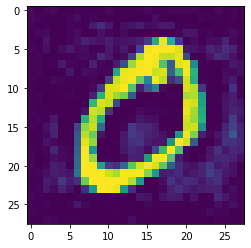

965
l2 dist: 1.4318162
target class:  2
pred of adv ex:  0


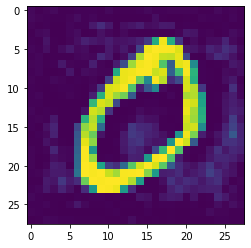

966
l2 dist: 1.4429442
target class:  2
pred of adv ex:  2


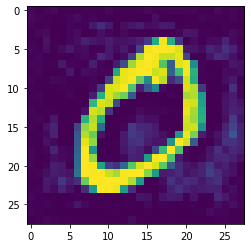

967
l2 dist: 1.4502317
target class:  2
pred of adv ex:  2


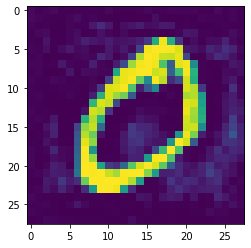

968
l2 dist: 1.4539586
target class:  2
pred of adv ex:  2


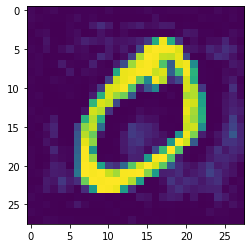

969
l2 dist: 1.4544231
target class:  2
pred of adv ex:  2


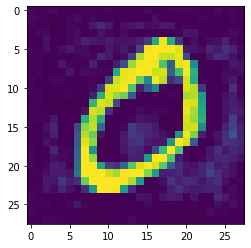

970
l2 dist: 1.4519335
target class:  2
pred of adv ex:  2


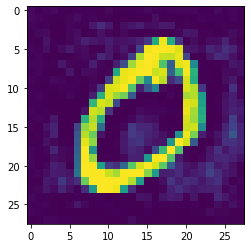

971
l2 dist: 1.4468023
target class:  2
pred of adv ex:  2


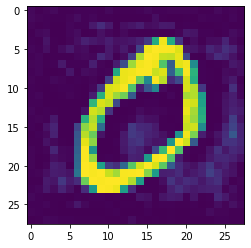

972
l2 dist: 1.4393396
target class:  2
pred of adv ex:  0


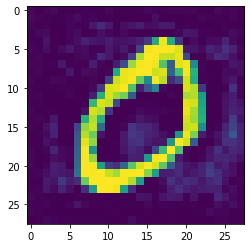

973
l2 dist: 1.4550312
target class:  2
pred of adv ex:  2


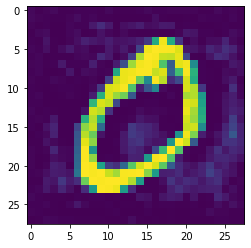

974
l2 dist: 1.466428
target class:  2
pred of adv ex:  2


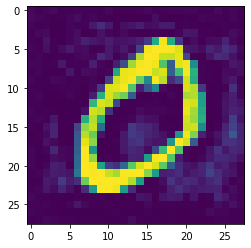

975
l2 dist: 1.4737833
target class:  2
pred of adv ex:  2


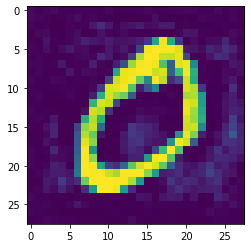

976
l2 dist: 1.4773836
target class:  2
pred of adv ex:  2


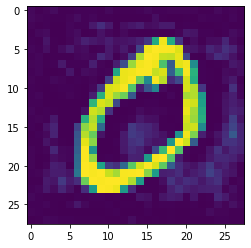

977
l2 dist: 1.4775422
target class:  2
pred of adv ex:  2


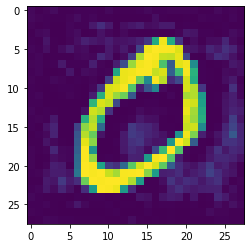

978
l2 dist: 1.4745909
target class:  2
pred of adv ex:  2


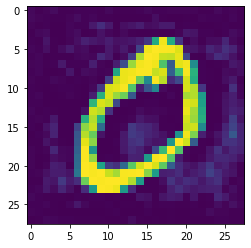

979
l2 dist: 1.4688711
target class:  2
pred of adv ex:  2


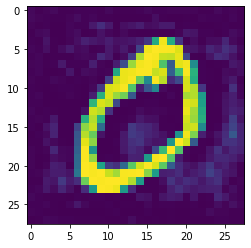

980
l2 dist: 1.4607263
target class:  2
pred of adv ex:  2


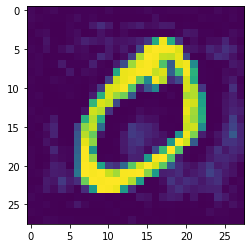

981
l2 dist: 1.4504917
target class:  2
pred of adv ex:  2


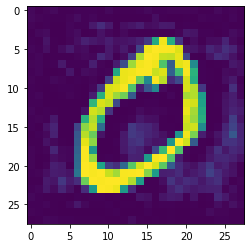

982
l2 dist: 1.4384863
target class:  2
pred of adv ex:  0


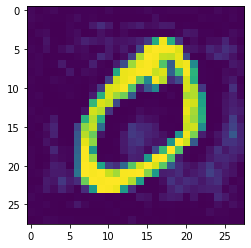

983
l2 dist: 1.4500961
target class:  2
pred of adv ex:  2


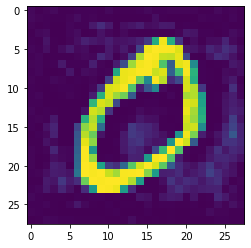

984
l2 dist: 1.4577699
target class:  2
pred of adv ex:  2


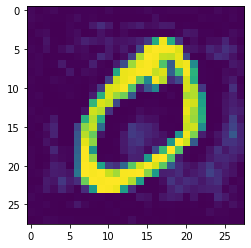

985
l2 dist: 1.4617909
target class:  2
pred of adv ex:  2


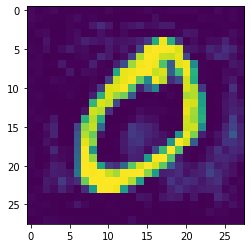

986
l2 dist: 1.4624617
target class:  2
pred of adv ex:  2


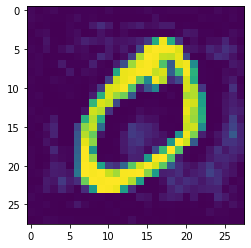

987
l2 dist: 1.4600962
target class:  2
pred of adv ex:  2


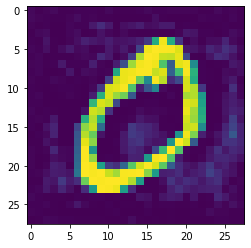

988
l2 dist: 1.4550133
target class:  2
pred of adv ex:  2


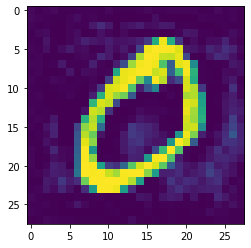

989
l2 dist: 1.4475307
target class:  2
pred of adv ex:  2


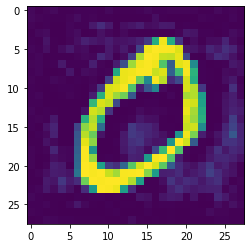

990
l2 dist: 1.4379599
target class:  2
pred of adv ex:  0


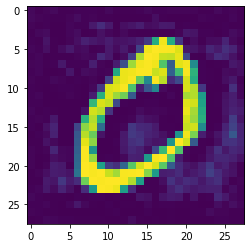

991
l2 dist: 1.4519639
target class:  2
pred of adv ex:  2


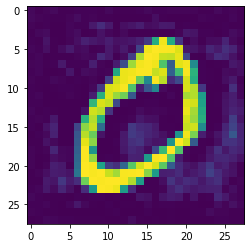

992
l2 dist: 1.4618636
target class:  2
pred of adv ex:  2


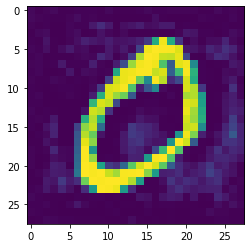

993
l2 dist: 1.4679097
target class:  2
pred of adv ex:  2


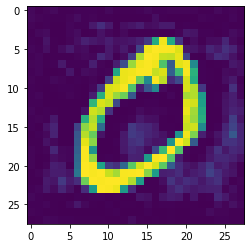

994
l2 dist: 1.4703778
target class:  2
pred of adv ex:  2


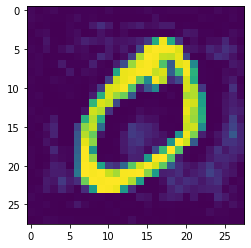

995
l2 dist: 1.4695653
target class:  2
pred of adv ex:  2


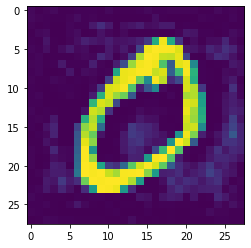

996
l2 dist: 1.4657874
target class:  2
pred of adv ex:  2


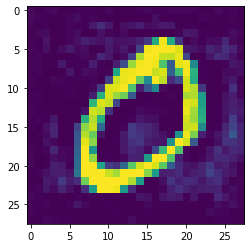

997
l2 dist: 1.4593719
target class:  2
pred of adv ex:  2


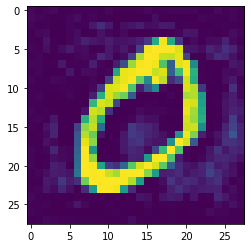

998
l2 dist: 1.4506499
target class:  2
pred of adv ex:  2


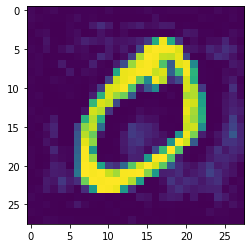

999
l2 dist: 1.4399467
target class:  2
pred of adv ex:  2


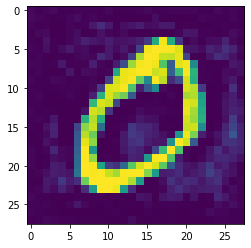

In [21]:
x = tf.convert_to_tensor(tf.expand_dims(x_train[1], axis=0), tf.float32)
w = tf.Variable(initial_value=tf.zeros(x.shape))
#print(modifier)
show_adv = []
optimizer = tf.keras.optimizers.Adam(.03)
target = find_second_most_probable_class(get_logits(model,x))
#target = 1
for i in range(1000):
    print(i)
    with tf.GradientTape() as tape:
        #tape.watch(w)
        adv_image = .5 * (tf.tanh(w) + 1)
        #print(show_adv)
        preds = model(adv_image)
        const= 1
        loss = loss_function(x=x, adv_image=adv_image, const=const, target=target)
        l2_distance = tf.norm(adv_image - x).numpy()
        #linf_distance = tf.norm(adv_image - x, ord=np.inf).numpy
        #l1_distance = tf.norm(adv_image - x, ord=1).numpy
        
        #loss = alternate_loss_fn(adv_image, x)
        #print(loss)
        grads = tape.gradient(loss, w)
        optimizer.apply_gradients([(grads, w)])
        #print(modifier)
        #print('loss:',loss.numpy())
        #print('clean',np.argmax(model(x)))
        print('l2 dist:', l2_distance)
        #print('l1 dist:', l1_distance)
        #print('l_inf dist:', linf_distance)
        print('target class: ',target)
        print('pred of adv ex: ',np.argmax(model(adv_image)))
        #print('adv',tf.nn.softmax(model(adv_image)))
        #print(adv_image)
        plt.figure()
        plt.imshow(tf.reshape(adv_image, (28,28)))
        plt.show()
        #show_adv = adv_image
        #print('pred:',np.argmax(tf.nn.softmax(model(adv_image))))#
        #print(show_adv)
#print(show_adv)
#plt.show()
    

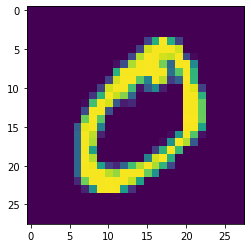

In [20]:
#plt.figure()
#plt.imshow(tf.reshape(adv_image, (28,28)))
#plt.show()
plt.figure()
plt.imshow(tf.reshape(x, (28,28)))
plt.show()

In [25]:
w = tf.Variable(initial_value=tf.zeros(x.shape))
x = tf.convert_to_tensor(tf.expand_dims(x_train[3], axis=0), tf.float32)

In [5]:
#
def to_attack_space(x, clip_max = 1, clip_min = 0):
    a = (clip_min + clip_max) / 2
    b = (clip_max - clip_min) / 2
    x = (x - a) / b # from (min, max) to (-1, 1)
    x = x * 0.9999999 #from (-1, 1) to ~(-1, 1)
    return tf.atanh(x) # from ~(-1, 1) to (-inf, inf)

def to_model_space(x, clip_max = 1, clip_min = 0):
    x = tf.tanh(x) # from (-inf, +inf) to (-1, 1)
    a = (clip_min + clip_max) / 2
    b = (clip_max - clip_min) / 2
    return x * b + a # from (-1, 1) to (clip_min, clip_max), (0, 1) mostly

def clip_tanh(x, clip_min, clip_max):
    x = (tf.tanh(x) + 1) / 2
    return x * (self.clip_max - self.clip_min) + self.clip_min

def find_second_most_probable_class(logits):
    logits = logits.numpy().flatten()
    return np.argpartition(logits,len(logits)-2)[len(logits)-2]

        


In [6]:
def get_least_probable(model, x):
    all_logits = get_logits(model, x)
    #print(all_logits)
    return tf.math.argmin(all_logits)


def get_logit_of_best_except_target(model, adv_x, target):
    all_logits = get_logits(model, adv_x)
    #print('all_logits', all_logits)
    most_probable_class = tf.math.argmax(all_logits)
    second_most_probable_class = find_second_most_probable_class(all_logits)
    if target == most_probable_class: 
        return all_logits[second_most_probable_class ]
    if target != most_probable_class: 
        return all_logits[most_probable_class ]

def get_logit_of_target(model, adv_x, target):
    all_logits = get_logits(model, adv_x)
    return all_logits[target]



• Average Case: select the target class uniformly at random
among the labels that are not the correct label. <br>
• Best Case: perform the attack against all incorrect classes,
and report the target class that was least difficult to attack. <br>
• Worst Case: perform the attack against all incorrect
classes, and report the target class that was most difficult
to attack.

In [7]:
def get_logits(model, x):
    
    model(x)
    
    return model.pre_softmax[0]
    

In [8]:
ds = tfds.load(name="imagenette", with_info=True, split=["train","validation"])
ds_train=ds[0][0]
ds_test=ds[0][1]
assert isinstance(ds_train, tf.data.Dataset)

def normalize(x):
    y = {'image': tf.image.convert_image_dtype(x['image'], tf.float32), 'label': x['label']}
    y = (tf.image.resize(y['image'], (224,224)), y['label'])
    return y
    
ds_train = ds_train.map(lambda x: normalize(x))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(100)
ds_train = ds_train.batch(8)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(8)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:

def unroll(tensor, shape):
    return tf.transpose(tf.reshape(tensor, shape))

def roll_back(tensor, shape):
    return(tf.reshape(tf.transpose(tensor), shape))


shape=(50176,3)
y = unroll(x, shape)
print(y.shape)
shape=(224,224,3)
z = roll_back(y, shape)
print(z.shape)


plt.figure()
plt.imshow(z)
plt.show()

NameError: name 'x' is not defined

tf.Tensor(9, shape=(), dtype=int64)
(224, 224, 3)


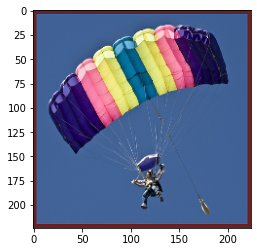

In [10]:
for z in ds_test.take(1):
    print(z[1][0])
    print(z[0][0].shape)
    x = z[0][0].numpy()
    tf.reshape
    plt.figure()
    plt.imshow(x)
    plt.show()

In [31]:
tfds.__version__

'1.2.0'

In [138]:
zzz = tf.Variable([1,2,3,4,5,6])
#print(np.argmin(zzz.numpy()))

0


In [522]:
model(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[1.6736643e-21, 3.1095958e-19, 1.2851257e-26, 6.1183505e-19,
        1.7574131e-11, 7.5577641e-15, 1.5379399e-28, 3.1209009e-13,
        2.4079222e-13, 1.0000000e+00]], dtype=float32)>

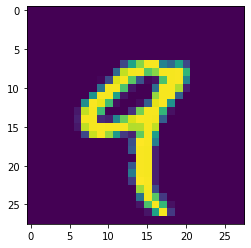

In [521]:
plt.figure()
plt.imshow(tf.reshape(x, (28,28)))
plt.show()

In [533]:
d=[0,0,0,0,0,0,2]
e = tf.reduce_max(d).numpy()
f = tf.equal(e, d)
print(d)
print(e)
print(f)
print(tf.argmax(d).numpy())

[0, 0, 0, 0, 0, 0, 2]
2
tf.Tensor([False False False False False False  True], shape=(7,), dtype=bool)
6


# Define and Train Model

## Definiton of MLP DNN

In [11]:
class CustomLayer(layers.Layer):

    def __init__(self, units=32, activation='relu', input_shape=(784)):
        super(CustomLayer, self).__init__()
        self.units = units
        self.activation = activation
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True,
                                 name='weight'
                                )
        self.mask = self.add_weight(shape=(self.w.shape),
                                    initializer='ones',
                                    trainable=False,
                                    name='mask'
                                   )
        self.pruned_w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='ones',
                                 trainable=False,
                                 name='pruned_weights'
                                )

   
    def call(self, inputs):
        #self.mask_2 = tf.multiply(self.mask, self.mask_2)
        self.pruned_w = tf.multiply(self.w, self.mask)
        #print('layer inputy', inputs.shape)
        x = tf.matmul(inputs, self.pruned_w)
        
        if self.activation == 'relu':
            return tf.keras.activations.relu(x)
        if self.activation == 'softmax':
            return tf.keras.activations.softmax(x)
        if self.activation == None:
            return x
            
        raise ValueError('Activation function not implemented')


class LeNet300_100(tf.keras.Model):
    def __init__(self):
        super(LeNet300_100, self).__init__()
        self.dense1 = CustomLayer(300, input_shape=(None, 784))
        self.dense2 = CustomLayer(100, input_shape=(None, 300))
        self.dense3 = CustomLayer(10, activation=None, input_shape=(None, 100))
        
    def call(self, inputs):
        #print('NN call',inputs.shape)
        x = tf.keras.layers.Flatten()(inputs)
        x = self.dense1(x)
        
        x = self.dense2(x)
        x = self.dense3(x)
        self.pre_softmax = x
        return tf.keras.activations.softmax(x)
        #return x
    


In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255


In [13]:
def ld_mnist():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label

    dataset, info = tfds.load('mnist', 
                              data_dir='gs://tfds-data/datasets', 
                              with_info=True,
                              as_supervised=True)
    mnist_train, mnist_test = dataset['train'], dataset['test']
    mnist_train = mnist_train.map(convert_types).shuffle(10000).batch(128)
    mnist_test = mnist_test.map(convert_types).batch(128)
    return EasyDict(train=mnist_train, test=mnist_test)
data = ld_mnist()

In [14]:
def initialize_model():
    model = LeNet300_100()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                  metrics=['accuracy'],
                  experimental_run_tf_function=False
                 )
    return model

def train_model(model):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.fit(x=data.train,
              #batch_size=64,
              epochs=500,
              callbacks=[callback],
              validation_data=(x_test, y_test),
             )


In [15]:
model = initialize_model()
train_model(model)

Epoch 1/500
469/469 [==============================] - 10s 20ms/step - loss: 1.6679 - accuracy: 0.8112 - val_loss: 1.6091 - val_accuracy: 0.8535
Epoch 2/500
469/469 [==============================] - 8s 16ms/step - loss: 1.5976 - accuracy: 0.8654 - val_loss: 1.5296 - val_accuracy: 0.9351
Epoch 3/500
469/469 [==============================] - 7s 14ms/step - loss: 1.5085 - accuracy: 0.9561 - val_loss: 1.5042 - val_accuracy: 0.9598
Epoch 4/500
469/469 [==============================] - 7s 16ms/step - loss: 1.4951 - accuracy: 0.9686 - val_loss: 1.4951 - val_accuracy: 0.9685
Epoch 5/500
469/469 [==============================] - 7s 16ms/step - loss: 1.4889 - accuracy: 0.9742 - val_loss: 1.4926 - val_accuracy: 0.9710
Epoch 6/500
469/469 [==============================] - 7s 15ms/step - loss: 1.4851 - accuracy: 0.9775 - val_loss: 1.4933 - val_accuracy: 0.9696
Epoch 7/500
469/469 [==============================] - 8s 17ms/step - loss: 1.4819 - accuracy: 0.9805 - val_loss: 1.4865 - val_accuracy